# Lab 1: Day-ahead load prediction for ERCOT (Texas) markets. 

In this lab, you train a neural network to predict 24-hour aggregate load from Texas for a day using history of demands. The goals for this lab are:
1. Load the data and analyze to find patterns.
2. Define a neural network for the regression. Try different number of layers, learning rates, linear v/s nonlinear regression, activation functions, number of epochs, etc.
3. Explore the effects of wind energy on load prediction. 

In [1]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import random
import datetime
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt

# The following line suppresses certain warnings.
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

## Load the ERCOT data from 2015.

The load data is given in the column named 'ERCOT Load, MW' in the csv file provided.

In [2]:
year = 2015
dfDemand = pd.read_csv("ERCOT_Hourly_Wind_Output_" + str(year) + ".csv")

demands = dfDemand['ERCOT Load, MW']

# Count the number of days for which we have demand data.
numberOfDays = int(len(demands)/24)
print("Hourly demand data loaded for %d days." % numberOfDays)


Hourly demand data loaded for 365 days.


## Understand the data.

It is always useful to get accustomed to the data you are trying to learn. Visualize it if you can.

#### Q1. How does load vary over the year in Texas?

Text(0, 0.5, 'Net demand of Texas (in MW)')

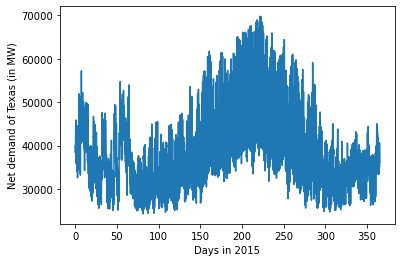

In [3]:
fig = plt.figure()

plt.plot([hour/24 for hour in range(numberOfDays * 24)], demands.values)
plt.xlabel("Days in " + str(year))
plt.ylabel("Net demand of Texas (in MW)")

**Fact.** A significant portion of the demand is usually thermal, i.e., for air conditioners and heating systems.

**Question (10 points).** From the above plot, what can you infer about the climate of Texas? What would you expect if you plotted the same in Illinois? 

**Based on the plot, Texas has very hot summers and mild winters because most of their electricity consumption is during the summer time. The plot for Illinois would likely show two peaks, one for the winter and one for the summer, since we tend to get harsh winters and hot summers.**


#### Q2. How does day of week affect the load profiles?

The first day in the first plot is Jan 31, 2015.
Day 1 was a Saturday.


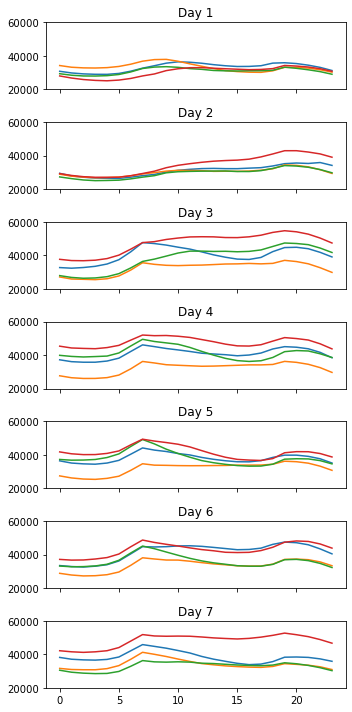

In [4]:
# Plot the load data of the same day of the week over several weeks.

dayStart = 30
numberOfWeeks = 4

DayOfWeek = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
print("The first day in the first plot is Jan 31, " + str(year) + ".")
print("Day 1", "was a", DayOfWeek[datetime.date(year, 1, 31).weekday()] + ".")

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(5,10))
axs = axs.ravel()

for dayInFirstWeek in range(7):
    for week in range(numberOfWeeks):

        axs[dayInFirstWeek].plot(range(24), dfDemand.loc[(dayStart + 7 * week + dayInFirstWeek) * 24: 
                                                         (dayStart + 7 * week + dayInFirstWeek + 1) * 24 - 1, 
                                                         'ERCOT Load, MW'].values.flatten())
    axs[dayInFirstWeek].set_ylim(bottom=20000, top=60000)
    axs[dayInFirstWeek].set_title("Day " + str(dayInFirstWeek + 1))

fig.tight_layout()
plt.show()

**Question (15 points).** Can you find any discernible change in the load profiles of different days of the week? Redo the above exercise for the months of August and September. Make 'Day 1' correspond to August 15th. What do you observe differently? 


**For the above exercise, the load profiles for the weekends tend be lower than the load profiles for the weekdays. For the months of August and September, the load profiles look very similar to each other, regardless of the day of the week.**

The first day in the first plot is August 15, 2015.
Day 1  was a  Saturday.


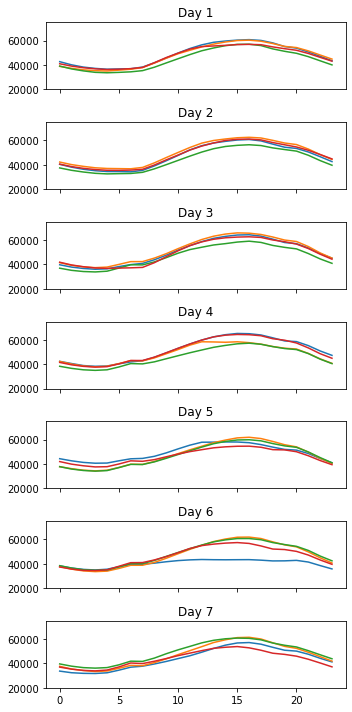

In [5]:
# Modify the following code

# Plot the load data of the same day of the week over several weeks.

dayStart = 226 # 8/15 = day 227, 226 because index starts at 0
numberOfWeeks = 4

DayOfWeek = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
print("The first day in the first plot is August 15, " + str(year) + ".")
print("Day 1", " was a ", DayOfWeek[datetime.date(year, 8, 15).weekday()] + ".")

fig, axs = plt.subplots(7, 1, sharex=True, figsize=(5,10))
axs = axs.ravel()

for dayInFirstWeek in range(7):
    for week in range(numberOfWeeks):

        axs[dayInFirstWeek].plot(range(24), dfDemand.loc[(dayStart + 7 * week + dayInFirstWeek) * 24: 
                                                         (dayStart + 7 * week + dayInFirstWeek + 1) * 24 - 1, 
                                                         'ERCOT Load, MW'].values.flatten())
    axs[dayInFirstWeek].set_ylim(bottom=20000, top=75000)
    axs[dayInFirstWeek].set_title("Day " + str(dayInFirstWeek + 1))

fig.tight_layout()
plt.show()

## Define the demand prediction module.

Use past demand profiles to predict demands a day in advance. We draw two conclusions from the above analysis:
1. Demand profiles have seasonal effects. Therefore, data from the past few days will help in predicting the demands tomorrow.
2. Demand profiles have weekly dependencies. Therefore, data from the same days but a week or two before can be useful in load prediction.

How much past data you want to train over depends on two considerations:
1. Which data in the past is useful in prediction?
2. How complex you want your training process to be? The more features of past data you want to train on, the more complex your neural network should be, and it will require more time to train it.

To strike a balance, use the demand profile from $d-7, d-2, d-1$ to predict the load profile of day $d$.

In [6]:
daysToTrainOn = [-7, -2, -1]
rangeOfDays = range(-np.min(daysToTrainOn), numberOfDays)

X = [np.concatenate([dfDemand.loc[(day + h) * 24: (day + h + 1) * 24 -1, 'ERCOT Load, MW'].values.flatten()
     for h in daysToTrainOn]) for day in rangeOfDays]
Y = [dfDemand.loc[day * 24: (day + 1) * 24 - 1, 'ERCOT Load, MW'].values.flatten() for day in rangeOfDays]


When you perform regression, it is often desirable to scale the inputs so that it has zero mean and unit variance. Other types of scaling are possible. Here, we cheat a little and scale both the training and test data together. Ideally, they should be scaled separately.

Split the data into two sets: training set and testing set. Train the neural network on the training set, and test how well it performs on the testing set. You should typically never sample from the training set to test your algorithms. The learnt model for prediction should work well on data that the algorithm has never encountered before.

The function 'train_test_split' helps you to split the data into two parts, where 'test_size'
indicates the fraction of the data you want to test on.

In [7]:
X = preprocessing.StandardScaler().fit_transform(X)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2)

trainX = trainX.astype(np.float32)
testX = testX.astype(np.float32)
trainY = np.array(trainY)
testY = np.array(testY)

print("Scaled and split the data into two parts:")

nTrain = np.shape(trainX)[0]
nTest = np.shape(testX)[0]

print("Neural network will train on data from %d days, and test on %d days." % (nTrain, nTest))


Scaled and split the data into two parts:
Neural network will train on data from 286 days, and test on 72 days.


### Design the neural network (NN) for demand prediction with only one hidden layer.

**Question (25 points). Insert code to design the NN and its optimizer (use the relu function)** 

In [8]:
nHidden = 150

# Store the dimension of each row of 'X' in 'nDimX' and that of 'Y' in 'nDimY' .
nDimX = np.shape(trainX)[1]
nDimY = np.shape(trainY)[1]

# Construct the neural network using relu - https://keras.io/api/layers/activations/
inputs = keras.Input(shape=(72,), name="input")
nn_layer = keras.layers.Dense(nHidden, activation="relu", name="dense_1", use_bias=True, bias_initializer='zeros')(inputs)
outputs = keras.layers.Dense(24, name="output")(nn_layer)

model = keras.Model(inputs=inputs, outputs=outputs)

# Define the loss function (MSE) and the optimizer (AdagradOptimizer).

# insert code - define loss metric to minimize using the desired optimizer
model.compile(
    optimizer=tf.optimizers.Adagrad(learning_rate=0.01), # Optimizer - https://keras.io/api/optimizers/
    loss=keras.losses.MeanSquaredError() # Loss metric - https://keras.io/api/metrics/
)


### Train the neural network via Keras.

Create the training module for the NN. 

Keras is a user-friendly framework to define, train and test neural networks. Check their page out for more details. https://keras.io/ 

Feed the training data in batches of size 'batchSize'.Usually, going through the training data once does not train your NN. You train over the same data multiple times. More precisely, train it 'nEpochs' times. It is similar to the idea that you never learn a material by reading through it once!

**Question (20 points). Insert code to define the training module**

In [9]:
batchSize = 75
nEpochs = 10000

# Train the model
print("Fit model on training data")

history = model.fit(
    trainX,
    trainY,
    batch_size=batchSize,
    epochs=nEpochs
)

Fit model on training data
Train on 286 samples
Epoch 1/10000
286/286 [==============================] - 0s 2ms/sample - loss: 1630754558.6573
Epoch 2/10000
286/286 [==============================] - 0s 58us/sample - loss: 1630258916.6993
Epoch 3/10000
286/286 [==============================] - 0s 45us/sample - loss: 1629620089.2867
Epoch 4/10000
286/286 [==============================] - 0s 49us/sample - loss: 1628890342.4895
Epoch 5/10000
286/286 [==============================] - 0s 47us/sample - loss: 1628092481.7902
Epoch 6/10000
286/286 [==============================] - 0s 49us/sample - loss: 1627245146.8531
Epoch 7/10000
286/286 [==============================] - 0s 48us/sample - loss: 1626357389.8741
Epoch 8/10000
286/286 [==============================] - 0s 50us/sample - loss: 1625441415.6084
Epoch 9/10000
286/286 [==============================] - 0s 46us/sample - loss: 1624521143.0490
Epoch 10/10000
286/286 [==============================] - 0s 46us/sample - loss: 16235849

286/286 [==============================] - 0s 41us/sample - loss: 1550691786.2937
Epoch 86/10000
286/286 [==============================] - 0s 41us/sample - loss: 1549730579.6923
Epoch 87/10000
286/286 [==============================] - 0s 39us/sample - loss: 1548767039.1049
Epoch 88/10000
286/286 [==============================] - 0s 45us/sample - loss: 1547809950.4336
Epoch 89/10000
286/286 [==============================] - 0s 43us/sample - loss: 1546845499.5245
Epoch 90/10000
286/286 [==============================] - 0s 42us/sample - loss: 1545887919.4406
Epoch 91/10000
286/286 [==============================] - 0s 41us/sample - loss: 1544930346.0699
Epoch 92/10000
286/286 [==============================] - 0s 42us/sample - loss: 1543966783.5524
Epoch 93/10000
286/286 [==============================] - 0s 43us/sample - loss: 1543006633.6224
Epoch 94/10000
286/286 [==============================] - 0s 45us/sample - loss: 1542049736.0559
Epoch 95/10000
286/286 [=====================

286/286 [==============================] - 0s 43us/sample - loss: 1398689614.7692
Epoch 252/10000
286/286 [==============================] - 0s 45us/sample - loss: 1397816973.4266
Epoch 253/10000
286/286 [==============================] - 0s 44us/sample - loss: 1396951731.9161
Epoch 254/10000
286/286 [==============================] - 0s 45us/sample - loss: 1396081460.3636
Epoch 255/10000
286/286 [==============================] - 0s 40us/sample - loss: 1395214211.5804
Epoch 256/10000
286/286 [==============================] - 0s 43us/sample - loss: 1394350681.5105
Epoch 257/10000
286/286 [==============================] - 0s 43us/sample - loss: 1393479841.1189
Epoch 258/10000
286/286 [==============================] - 0s 41us/sample - loss: 1392611805.0909
Epoch 259/10000
286/286 [==============================] - 0s 40us/sample - loss: 1391746106.1818
Epoch 260/10000
286/286 [==============================] - 0s 44us/sample - loss: 1390882901.4825
Epoch 261/10000
286/286 [===========

286/286 [==============================] - 0s 48us/sample - loss: 1261784257.7902
Epoch 418/10000
286/286 [==============================] - 0s 46us/sample - loss: 1261005597.5385
Epoch 419/10000
286/286 [==============================] - 0s 47us/sample - loss: 1260225545.3986
Epoch 420/10000
286/286 [==============================] - 0s 45us/sample - loss: 1259448624.3357
Epoch 421/10000
286/286 [==============================] - 0s 43us/sample - loss: 1258670426.8531
Epoch 422/10000
286/286 [==============================] - 0s 45us/sample - loss: 1257893674.9650
Epoch 423/10000
286/286 [==============================] - 0s 43us/sample - loss: 1257118305.1189
Epoch 424/10000
286/286 [==============================] - 0s 43us/sample - loss: 1256337988.0280
Epoch 425/10000
286/286 [==============================] - 0s 42us/sample - loss: 1255569220.0280
Epoch 426/10000
286/286 [==============================] - 0s 42us/sample - loss: 1254789196.0839
Epoch 427/10000
286/286 [===========

286/286 [==============================] - 0s 39us/sample - loss: 1139335169.1189
Epoch 584/10000
286/286 [==============================] - 0s 41us/sample - loss: 1138640921.7343
Epoch 585/10000
286/286 [==============================] - 0s 40us/sample - loss: 1137942850.4615
Epoch 586/10000
286/286 [==============================] - 0s 41us/sample - loss: 1137244707.3566
Epoch 587/10000
286/286 [==============================] - 0s 40us/sample - loss: 1136548435.6923
Epoch 588/10000
286/286 [==============================] - 0s 40us/sample - loss: 1135856033.5664
Epoch 589/10000
286/286 [==============================] - 0s 48us/sample - loss: 1135162169.7343
Epoch 590/10000
286/286 [==============================] - 0s 42us/sample - loss: 1134471835.7483
Epoch 591/10000
286/286 [==============================] - 0s 42us/sample - loss: 1133775539.2448
Epoch 592/10000
286/286 [==============================] - 0s 39us/sample - loss: 1133082142.4336
Epoch 593/10000
286/286 [===========

286/286 [==============================] - 0s 42us/sample - loss: 1030325941.4825
Epoch 750/10000
286/286 [==============================] - 0s 42us/sample - loss: 1029706945.7902
Epoch 751/10000
286/286 [==============================] - 0s 41us/sample - loss: 1029089388.5315
Epoch 752/10000
286/286 [==============================] - 0s 39us/sample - loss: 1028469425.0070
Epoch 753/10000
286/286 [==============================] - 0s 43us/sample - loss: 1027851155.2448
Epoch 754/10000
286/286 [==============================] - 0s 41us/sample - loss: 1027235115.4126
Epoch 755/10000
286/286 [==============================] - 0s 39us/sample - loss: 1026618193.2308
Epoch 756/10000
286/286 [==============================] - 0s 42us/sample - loss: 1026002462.4336
Epoch 757/10000
286/286 [==============================] - 0s 45us/sample - loss: 1025388871.1608
Epoch 758/10000
286/286 [==============================] - 0s 41us/sample - loss: 1024774471.1608
Epoch 759/10000
286/286 [===========

286/286 [==============================] - 0s 43us/sample - loss: 979937800.7273
Epoch 834/10000
286/286 [==============================] - 0s 39us/sample - loss: 979357719.4965
Epoch 835/10000
286/286 [==============================] - 0s 40us/sample - loss: 978775752.2797
Epoch 836/10000
286/286 [==============================] - 0s 41us/sample - loss: 978195613.5385
Epoch 837/10000
286/286 [==============================] - 0s 41us/sample - loss: 977617120.4476
Epoch 838/10000
286/286 [==============================] - 0s 40us/sample - loss: 977036093.9860
Epoch 839/10000
286/286 [==============================] - 0s 44us/sample - loss: 976458947.8042
Epoch 840/10000
286/286 [==============================] - 0s 45us/sample - loss: 975880615.8322
Epoch 841/10000
286/286 [==============================] - 0s 43us/sample - loss: 975302905.5105
Epoch 842/10000
286/286 [==============================] - 0s 38us/sample - loss: 974727910.9371
Epoch 843/10000
286/286 [=====================

286/286 [==============================] - 0s 38us/sample - loss: 888223123.4685
Epoch 1002/10000
286/286 [==============================] - 0s 41us/sample - loss: 887712110.7692
Epoch 1003/10000
286/286 [==============================] - 0s 42us/sample - loss: 887200780.5315
Epoch 1004/10000
286/286 [==============================] - 0s 41us/sample - loss: 886690436.2517
Epoch 1005/10000
286/286 [==============================] - 0s 38us/sample - loss: 886178944.0000
Epoch 1006/10000
286/286 [==============================] - 0s 43us/sample - loss: 885668835.8042
Epoch 1007/10000
286/286 [==============================] - 0s 44us/sample - loss: 885157983.1049
Epoch 1008/10000
286/286 [==============================] - 0s 39us/sample - loss: 884649957.5944
Epoch 1009/10000
286/286 [==============================] - 0s 41us/sample - loss: 884139079.1608
Epoch 1010/10000
286/286 [==============================] - 0s 46us/sample - loss: 883628855.4965
Epoch 1011/10000
286/286 [===========

286/286 [==============================] - 0s 41us/sample - loss: 808605233.4545
Epoch 1168/10000
286/286 [==============================] - 0s 41us/sample - loss: 808157570.2378
Epoch 1169/10000
286/286 [==============================] - 0s 42us/sample - loss: 807710256.5594
Epoch 1170/10000
286/286 [==============================] - 0s 40us/sample - loss: 807263588.4755
Epoch 1171/10000
286/286 [==============================] - 0s 42us/sample - loss: 806817365.9301
Epoch 1172/10000
286/286 [==============================] - 0s 41us/sample - loss: 806371125.7063
Epoch 1173/10000
286/286 [==============================] - 0s 40us/sample - loss: 805925103.8881
Epoch 1174/10000
286/286 [==============================] - 0s 40us/sample - loss: 805476806.4895
Epoch 1175/10000
286/286 [==============================] - 0s 45us/sample - loss: 805030308.6993
Epoch 1176/10000
286/286 [==============================] - 0s 40us/sample - loss: 804585386.5175
Epoch 1177/10000
286/286 [===========

286/286 [==============================] - 0s 40us/sample - loss: 738950112.4476
Epoch 1334/10000
286/286 [==============================] - 0s 42us/sample - loss: 738558275.3566
Epoch 1335/10000
286/286 [==============================] - 0s 38us/sample - loss: 738167018.7413
Epoch 1336/10000
286/286 [==============================] - 0s 43us/sample - loss: 737776461.4266
Epoch 1337/10000
286/286 [==============================] - 0s 42us/sample - loss: 737384682.2937
Epoch 1338/10000
286/286 [==============================] - 0s 38us/sample - loss: 736994190.3217
Epoch 1339/10000
286/286 [==============================] - 0s 42us/sample - loss: 736604693.4825
Epoch 1340/10000
286/286 [==============================] - 0s 53us/sample - loss: 736212069.1469
Epoch 1341/10000
286/286 [==============================] - 0s 43us/sample - loss: 735821968.3357
Epoch 1342/10000
286/286 [==============================] - 0s 42us/sample - loss: 735430768.5594
Epoch 1343/10000
286/286 [===========

286/286 [==============================] - 0s 42us/sample - loss: 678227792.5594
Epoch 1500/10000
286/286 [==============================] - 0s 42us/sample - loss: 677886373.3706
Epoch 1501/10000
286/286 [==============================] - 0s 40us/sample - loss: 677545833.1748
Epoch 1502/10000
286/286 [==============================] - 0s 43us/sample - loss: 677206712.1678
Epoch 1503/10000
286/286 [==============================] - 0s 49us/sample - loss: 676867941.3706
Epoch 1504/10000
286/286 [==============================] - 0s 40us/sample - loss: 676528099.1329
Epoch 1505/10000
286/286 [==============================] - 0s 41us/sample - loss: 676189826.9091
Epoch 1506/10000
286/286 [==============================] - 0s 68us/sample - loss: 675851653.3706
Epoch 1507/10000
286/286 [==============================] - 0s 38us/sample - loss: 675512785.4545
Epoch 1508/10000
286/286 [==============================] - 0s 39us/sample - loss: 675175814.9371
Epoch 1509/10000
286/286 [===========

286/286 [==============================] - 0s 41us/sample - loss: 650951314.7972
Epoch 1583/10000
286/286 [==============================] - 0s 42us/sample - loss: 650633964.0839
Epoch 1584/10000
286/286 [==============================] - 0s 41us/sample - loss: 650317872.1119
Epoch 1585/10000
286/286 [==============================] - 0s 41us/sample - loss: 650000536.1678
Epoch 1586/10000
286/286 [==============================] - 0s 40us/sample - loss: 649685247.1049
Epoch 1587/10000
286/286 [==============================] - 0s 43us/sample - loss: 649370715.9720
Epoch 1588/10000
286/286 [==============================] - 0s 42us/sample - loss: 649054101.7063
Epoch 1589/10000
286/286 [==============================] - 0s 43us/sample - loss: 648737900.9790
Epoch 1590/10000
286/286 [==============================] - 0s 41us/sample - loss: 648423374.0979
Epoch 1591/10000
286/286 [==============================] - 0s 42us/sample - loss: 648109596.6434
Epoch 1592/10000
286/286 [===========

286/286 [==============================] - 0s 41us/sample - loss: 602018684.4196
Epoch 1749/10000
286/286 [==============================] - 0s 38us/sample - loss: 601745556.5874
Epoch 1750/10000
286/286 [==============================] - 0s 42us/sample - loss: 601472942.2098
Epoch 1751/10000
286/286 [==============================] - 0s 42us/sample - loss: 601198378.5175
Epoch 1752/10000
286/286 [==============================] - 0s 41us/sample - loss: 600925779.6923
Epoch 1753/10000
286/286 [==============================] - 0s 38us/sample - loss: 600653582.7692
Epoch 1754/10000
286/286 [==============================] - 0s 43us/sample - loss: 600381440.2238
Epoch 1755/10000
286/286 [==============================] - 0s 42us/sample - loss: 600110414.9930
Epoch 1756/10000
286/286 [==============================] - 0s 38us/sample - loss: 599839025.2308
Epoch 1757/10000
286/286 [==============================] - 0s 39us/sample - loss: 599565451.4126
Epoch 1758/10000
286/286 [===========

286/286 [==============================] - 0s 43us/sample - loss: 559844003.1329
Epoch 1915/10000
286/286 [==============================] - 0s 42us/sample - loss: 559608933.4825
Epoch 1916/10000
286/286 [==============================] - 0s 39us/sample - loss: 559375358.0979
Epoch 1917/10000
286/286 [==============================] - 0s 38us/sample - loss: 559139752.2797
Epoch 1918/10000
286/286 [==============================] - 0s 43us/sample - loss: 558905589.7063
Epoch 1919/10000
286/286 [==============================] - 0s 43us/sample - loss: 558671572.0280
Epoch 1920/10000
286/286 [==============================] - 0s 41us/sample - loss: 558436678.2657
Epoch 1921/10000
286/286 [==============================] - 0s 42us/sample - loss: 558203648.5594
Epoch 1922/10000
286/286 [==============================] - 0s 42us/sample - loss: 557969115.6364
Epoch 1923/10000
286/286 [==============================] - 0s 42us/sample - loss: 557735000.9510
Epoch 1924/10000
286/286 [===========

286/286 [==============================] - 0s 41us/sample - loss: 523637625.8462
Epoch 2081/10000
286/286 [==============================] - 0s 43us/sample - loss: 523437036.6434
Epoch 2082/10000
286/286 [==============================] - 0s 40us/sample - loss: 523234559.8881
Epoch 2083/10000
286/286 [==============================] - 0s 40us/sample - loss: 523032887.7203
Epoch 2084/10000
286/286 [==============================] - 0s 40us/sample - loss: 522832928.2238
Epoch 2085/10000
286/286 [==============================] - 0s 41us/sample - loss: 522632249.1748
Epoch 2086/10000
286/286 [==============================] - 0s 41us/sample - loss: 522431153.1189
Epoch 2087/10000
286/286 [==============================] - 0s 39us/sample - loss: 522231295.2168
Epoch 2088/10000
286/286 [==============================] - 0s 41us/sample - loss: 522032138.6294
Epoch 2089/10000
286/286 [==============================] - 0s 41us/sample - loss: 521832127.4406
Epoch 2090/10000
286/286 [===========

286/286 [==============================] - 0s 41us/sample - loss: 492649517.0909
Epoch 2247/10000
286/286 [==============================] - 0s 46us/sample - loss: 492477755.9720
Epoch 2248/10000
286/286 [==============================] - 0s 42us/sample - loss: 492305867.8601
Epoch 2249/10000
286/286 [==============================] - 0s 39us/sample - loss: 492134141.6503
Epoch 2250/10000
286/286 [==============================] - 0s 40us/sample - loss: 491962217.3986
Epoch 2251/10000
286/286 [==============================] - 0s 43us/sample - loss: 491789437.4266
Epoch 2252/10000
286/286 [==============================] - 0s 42us/sample - loss: 491617868.6434
Epoch 2253/10000
286/286 [==============================] - 0s 40us/sample - loss: 491446149.8182
Epoch 2254/10000
286/286 [==============================] - 0s 42us/sample - loss: 491274382.6573
Epoch 2255/10000
286/286 [==============================] - 0s 42us/sample - loss: 491103276.9790
Epoch 2256/10000
286/286 [===========

286/286 [==============================] - 0s 48us/sample - loss: 466198832.2238
Epoch 2413/10000
286/286 [==============================] - 0s 48us/sample - loss: 466051068.6434
Epoch 2414/10000
286/286 [==============================] - 0s 45us/sample - loss: 465904084.6993
Epoch 2415/10000
286/286 [==============================] - 0s 44us/sample - loss: 465757446.6014
Epoch 2416/10000
286/286 [==============================] - 0s 46us/sample - loss: 465610714.2937
Epoch 2417/10000
286/286 [==============================] - 0s 40us/sample - loss: 465464590.5455
Epoch 2418/10000
286/286 [==============================] - 0s 49us/sample - loss: 465319038.7692
Epoch 2419/10000
286/286 [==============================] - 0s 50us/sample - loss: 465173094.4895
Epoch 2420/10000
286/286 [==============================] - 0s 44us/sample - loss: 465027628.3077
Epoch 2421/10000
286/286 [==============================] - 0s 47us/sample - loss: 464881346.7972
Epoch 2422/10000
286/286 [===========

286/286 [==============================] - 0s 42us/sample - loss: 443667938.2378
Epoch 2579/10000
286/286 [==============================] - 0s 44us/sample - loss: 443543834.1818
Epoch 2580/10000
286/286 [==============================] - 0s 44us/sample - loss: 443419359.3287
Epoch 2581/10000
286/286 [==============================] - 0s 46us/sample - loss: 443294678.8252
Epoch 2582/10000
286/286 [==============================] - 0s 45us/sample - loss: 443170581.8182
Epoch 2583/10000
286/286 [==============================] - 0s 41us/sample - loss: 443046778.9650
Epoch 2584/10000
286/286 [==============================] - 0s 41us/sample - loss: 442922530.2378
Epoch 2585/10000
286/286 [==============================] - 0s 46us/sample - loss: 442797454.3217
Epoch 2586/10000
286/286 [==============================] - 0s 42us/sample - loss: 442671855.3287
Epoch 2587/10000
286/286 [==============================] - 0s 42us/sample - loss: 442546791.4965
Epoch 2588/10000
286/286 [===========

286/286 [==============================] - 0s 47us/sample - loss: 424529794.4615
Epoch 2745/10000
286/286 [==============================] - 0s 43us/sample - loss: 424423476.1399
Epoch 2746/10000
286/286 [==============================] - 0s 40us/sample - loss: 424317666.4615
Epoch 2747/10000
286/286 [==============================] - 0s 43us/sample - loss: 424211817.3986
Epoch 2748/10000
286/286 [==============================] - 0s 46us/sample - loss: 424106769.3427
Epoch 2749/10000
286/286 [==============================] - 0s 45us/sample - loss: 424000834.5734
Epoch 2750/10000
286/286 [==============================] - 0s 41us/sample - loss: 423895474.6853
Epoch 2751/10000
286/286 [==============================] - 0s 41us/sample - loss: 423791103.8881
Epoch 2752/10000
286/286 [==============================] - 0s 44us/sample - loss: 423684708.9231
Epoch 2753/10000
286/286 [==============================] - 0s 42us/sample - loss: 423579965.5385
Epoch 2754/10000
286/286 [===========

286/286 [==============================] - 0s 44us/sample - loss: 408279531.0769
Epoch 2911/10000
286/286 [==============================] - 0s 46us/sample - loss: 408188909.3147
Epoch 2912/10000
286/286 [==============================] - 0s 43us/sample - loss: 408099894.8252
Epoch 2913/10000
286/286 [==============================] - 0s 42us/sample - loss: 408009903.3287
Epoch 2914/10000
286/286 [==============================] - 0s 39us/sample - loss: 407919732.4755
Epoch 2915/10000
286/286 [==============================] - 0s 46us/sample - loss: 407829742.2098
Epoch 2916/10000
286/286 [==============================] - 0s 44us/sample - loss: 407741558.2657
Epoch 2917/10000
286/286 [==============================] - 0s 42us/sample - loss: 407651662.3217
Epoch 2918/10000
286/286 [==============================] - 0s 43us/sample - loss: 407562518.3776
Epoch 2919/10000
286/286 [==============================] - 0s 43us/sample - loss: 407473863.9441
Epoch 2920/10000
286/286 [===========

286/286 [==============================] - 0s 43us/sample - loss: 394497334.1538
Epoch 3077/10000
286/286 [==============================] - 0s 44us/sample - loss: 394420883.0210
Epoch 3078/10000
286/286 [==============================] - 0s 44us/sample - loss: 394344078.4336
Epoch 3079/10000
286/286 [==============================] - 0s 41us/sample - loss: 394267761.4545
Epoch 3080/10000
286/286 [==============================] - 0s 43us/sample - loss: 394191850.4056
Epoch 3081/10000
286/286 [==============================] - 0s 48us/sample - loss: 394116356.6993
Epoch 3082/10000
286/286 [==============================] - 0s 43us/sample - loss: 394041146.4056
Epoch 3083/10000
286/286 [==============================] - 0s 42us/sample - loss: 393966076.1958
Epoch 3084/10000
286/286 [==============================] - 0s 41us/sample - loss: 393889868.9790
Epoch 3085/10000
286/286 [==============================] - 0s 44us/sample - loss: 393813775.3287
Epoch 3086/10000
286/286 [===========

286/286 [==============================] - 0s 39us/sample - loss: 382799177.8462
Epoch 3243/10000
286/286 [==============================] - 0s 42us/sample - loss: 382733734.4895
Epoch 3244/10000
286/286 [==============================] - 0s 41us/sample - loss: 382669030.7133
Epoch 3245/10000
286/286 [==============================] - 0s 39us/sample - loss: 382604057.1748
Epoch 3246/10000
286/286 [==============================] - 0s 41us/sample - loss: 382539233.1189
Epoch 3247/10000
286/286 [==============================] - 0s 41us/sample - loss: 382475470.9930
Epoch 3248/10000
286/286 [==============================] - 0s 41us/sample - loss: 382411380.5874
Epoch 3249/10000
286/286 [==============================] - 0s 39us/sample - loss: 382346524.9790
Epoch 3250/10000
286/286 [==============================] - 0s 41us/sample - loss: 382282434.4615
Epoch 3251/10000
286/286 [==============================] - 0s 40us/sample - loss: 382217538.2378
Epoch 3252/10000
286/286 [===========

286/286 [==============================] - 0s 39us/sample - loss: 372875814.2657
Epoch 3409/10000
286/286 [==============================] - 0s 44us/sample - loss: 372820765.9860
Epoch 3410/10000
286/286 [==============================] - 0s 43us/sample - loss: 372765080.2797
Epoch 3411/10000
286/286 [==============================] - 0s 40us/sample - loss: 372710312.1678
Epoch 3412/10000
286/286 [==============================] - 0s 39us/sample - loss: 372655128.8392
Epoch 3413/10000
286/286 [==============================] - 0s 42us/sample - loss: 372599991.1608
Epoch 3414/10000
286/286 [==============================] - 0s 41us/sample - loss: 372545778.5734
Epoch 3415/10000
286/286 [==============================] - 0s 41us/sample - loss: 372492293.3706
Epoch 3416/10000
286/286 [==============================] - 0s 41us/sample - loss: 372437678.6573
Epoch 3417/10000
286/286 [==============================] - 0s 42us/sample - loss: 372383246.5455
Epoch 3418/10000
286/286 [===========

286/286 [==============================] - 0s 42us/sample - loss: 364441000.2797
Epoch 3575/10000
286/286 [==============================] - 0s 45us/sample - loss: 364394829.8741
Epoch 3576/10000
286/286 [==============================] - 0s 44us/sample - loss: 364347858.7972
Epoch 3577/10000
286/286 [==============================] - 0s 42us/sample - loss: 364301425.1189
Epoch 3578/10000
286/286 [==============================] - 0s 42us/sample - loss: 364255315.2448
Epoch 3579/10000
286/286 [==============================] - 0s 42us/sample - loss: 364208501.5944
Epoch 3580/10000
286/286 [==============================] - 0s 40us/sample - loss: 364162303.4406
Epoch 3581/10000
286/286 [==============================] - 0s 43us/sample - loss: 364115668.5874
Epoch 3582/10000
286/286 [==============================] - 0s 42us/sample - loss: 364069182.4336
Epoch 3583/10000
286/286 [==============================] - 0s 43us/sample - loss: 364022639.7762
Epoch 3584/10000
286/286 [===========

286/286 [==============================] - 0s 43us/sample - loss: 357269868.7552
Epoch 3741/10000
286/286 [==============================] - 0s 43us/sample - loss: 357230093.5385
Epoch 3742/10000
286/286 [==============================] - 0s 41us/sample - loss: 357190426.1818
Epoch 3743/10000
286/286 [==============================] - 0s 37us/sample - loss: 357150417.9021
Epoch 3744/10000
286/286 [==============================] - 0s 41us/sample - loss: 357111075.4685
Epoch 3745/10000
286/286 [==============================] - 0s 41us/sample - loss: 357071465.7343
Epoch 3746/10000
286/286 [==============================] - 0s 40us/sample - loss: 357032462.3217
Epoch 3747/10000
286/286 [==============================] - 0s 40us/sample - loss: 356992877.9860
Epoch 3748/10000
286/286 [==============================] - 0s 42us/sample - loss: 356953522.2378
Epoch 3749/10000
286/286 [==============================] - 0s 43us/sample - loss: 356914226.9091
Epoch 3750/10000
286/286 [===========

286/286 [==============================] - 0s 39us/sample - loss: 351159409.1189
Epoch 3907/10000
286/286 [==============================] - 0s 42us/sample - loss: 351124778.2937
Epoch 3908/10000
286/286 [==============================] - 0s 42us/sample - loss: 351090686.3217
Epoch 3909/10000
286/286 [==============================] - 0s 41us/sample - loss: 351057279.2168
Epoch 3910/10000
286/286 [==============================] - 0s 40us/sample - loss: 351023375.1049
Epoch 3911/10000
286/286 [==============================] - 0s 38us/sample - loss: 350989977.7343
Epoch 3912/10000
286/286 [==============================] - 0s 41us/sample - loss: 350955644.1958
Epoch 3913/10000
286/286 [==============================] - 0s 42us/sample - loss: 350921614.6014
Epoch 3914/10000
286/286 [==============================] - 0s 39us/sample - loss: 350887668.8112
Epoch 3915/10000
286/286 [==============================] - 0s 41us/sample - loss: 350854465.0070
Epoch 3916/10000
286/286 [===========

286/286 [==============================] - 0s 45us/sample - loss: 345941542.1538
Epoch 4073/10000
286/286 [==============================] - 0s 44us/sample - loss: 345912393.3986
Epoch 4074/10000
286/286 [==============================] - 0s 43us/sample - loss: 345883394.4056
Epoch 4075/10000
286/286 [==============================] - 0s 44us/sample - loss: 345855454.5455
Epoch 4076/10000
286/286 [==============================] - 0s 43us/sample - loss: 345826316.8671
Epoch 4077/10000
286/286 [==============================] - 0s 44us/sample - loss: 345797626.0699
Epoch 4078/10000
286/286 [==============================] - 0s 42us/sample - loss: 345768756.1399
Epoch 4079/10000
286/286 [==============================] - 0s 42us/sample - loss: 345739580.5315
Epoch 4080/10000
286/286 [==============================] - 0s 42us/sample - loss: 345710328.3916
Epoch 4081/10000
286/286 [==============================] - 0s 43us/sample - loss: 345681611.7483
Epoch 4082/10000
286/286 [===========

286/286 [==============================] - 0s 40us/sample - loss: 341470709.8182
Epoch 4239/10000
286/286 [==============================] - 0s 41us/sample - loss: 341445311.7203
Epoch 4240/10000
286/286 [==============================] - 0s 42us/sample - loss: 341419993.2867
Epoch 4241/10000
286/286 [==============================] - 0s 42us/sample - loss: 341395167.2727
Epoch 4242/10000
286/286 [==============================] - 0s 39us/sample - loss: 341371050.2937
Epoch 4243/10000
286/286 [==============================] - 0s 39us/sample - loss: 341345746.6853
Epoch 4244/10000
286/286 [==============================] - 0s 42us/sample - loss: 341320448.7832
Epoch 4245/10000
286/286 [==============================] - 0s 40us/sample - loss: 341295670.1538
Epoch 4246/10000
286/286 [==============================] - 0s 40us/sample - loss: 341271411.4685
Epoch 4247/10000
286/286 [==============================] - 0s 41us/sample - loss: 341246918.4895
Epoch 4248/10000
286/286 [===========

286/286 [==============================] - 0s 43us/sample - loss: 337631069.8741
Epoch 4405/10000
286/286 [==============================] - 0s 44us/sample - loss: 337609433.8462
Epoch 4406/10000
286/286 [==============================] - 0s 41us/sample - loss: 337588408.3357
Epoch 4407/10000
286/286 [==============================] - 0s 41us/sample - loss: 337567205.5944
Epoch 4408/10000
286/286 [==============================] - 0s 43us/sample - loss: 337545473.0070
Epoch 4409/10000
286/286 [==============================] - 0s 43us/sample - loss: 337524317.5385
Epoch 4410/10000
286/286 [==============================] - 0s 53us/sample - loss: 337502611.6923
Epoch 4411/10000
286/286 [==============================] - 0s 46us/sample - loss: 337480909.4266
Epoch 4412/10000
286/286 [==============================] - 0s 39us/sample - loss: 337460781.7063
Epoch 4413/10000
286/286 [==============================] - 0s 42us/sample - loss: 337438925.0909
Epoch 4414/10000
286/286 [===========

286/286 [==============================] - 0s 41us/sample - loss: 334328542.4336
Epoch 4571/10000
286/286 [==============================] - 0s 42us/sample - loss: 334310020.8112
Epoch 4572/10000
286/286 [==============================] - 0s 41us/sample - loss: 334291522.1259
Epoch 4573/10000
286/286 [==============================] - 0s 38us/sample - loss: 334272988.4755
Epoch 4574/10000
286/286 [==============================] - 0s 42us/sample - loss: 334254841.6224
Epoch 4575/10000
286/286 [==============================] - 0s 46us/sample - loss: 334236236.3077
Epoch 4576/10000
286/286 [==============================] - 0s 40us/sample - loss: 334217872.7832
Epoch 4577/10000
286/286 [==============================] - 0s 38us/sample - loss: 334199742.4336
Epoch 4578/10000
286/286 [==============================] - 0s 43us/sample - loss: 334181216.7832
Epoch 4579/10000
286/286 [==============================] - 0s 42us/sample - loss: 334162633.5105
Epoch 4580/10000
286/286 [===========

286/286 [==============================] - 0s 39us/sample - loss: 331469213.8741
Epoch 4737/10000
286/286 [==============================] - 0s 40us/sample - loss: 331452985.3986
Epoch 4738/10000
286/286 [==============================] - 0s 43us/sample - loss: 331437456.3357
Epoch 4739/10000
286/286 [==============================] - 0s 41us/sample - loss: 331421887.1049
Epoch 4740/10000
286/286 [==============================] - 0s 41us/sample - loss: 331405765.4825
Epoch 4741/10000
286/286 [==============================] - 0s 39us/sample - loss: 331389854.3217
Epoch 4742/10000
286/286 [==============================] - 0s 42us/sample - loss: 331373655.4965
Epoch 4743/10000
286/286 [==============================] - 0s 43us/sample - loss: 331357815.4965
Epoch 4744/10000
286/286 [==============================] - 0s 40us/sample - loss: 331341990.6014
Epoch 4745/10000
286/286 [==============================] - 0s 40us/sample - loss: 331326292.2517
Epoch 4746/10000
286/286 [===========

286/286 [==============================] - 0s 41us/sample - loss: 328992551.7203
Epoch 4903/10000
286/286 [==============================] - 0s 41us/sample - loss: 328977496.5035
Epoch 4904/10000
286/286 [==============================] - 0s 42us/sample - loss: 328964378.8531
Epoch 4905/10000
286/286 [==============================] - 0s 39us/sample - loss: 328950589.0909
Epoch 4906/10000
286/286 [==============================] - 0s 39us/sample - loss: 328935637.9301
Epoch 4907/10000
286/286 [==============================] - 0s 40us/sample - loss: 328922276.5874
Epoch 4908/10000
286/286 [==============================] - 0s 41us/sample - loss: 328908350.3217
Epoch 4909/10000
286/286 [==============================] - 0s 39us/sample - loss: 328894242.4615
Epoch 4910/10000
286/286 [==============================] - 0s 41us/sample - loss: 328880285.8741
Epoch 4911/10000
286/286 [==============================] - 0s 42us/sample - loss: 328866758.8252
Epoch 4912/10000
286/286 [===========

286/286 [==============================] - 0s 40us/sample - loss: 326824837.1469
Epoch 5069/10000
286/286 [==============================] - 0s 42us/sample - loss: 326812558.6573
Epoch 5070/10000
286/286 [==============================] - 0s 42us/sample - loss: 326800511.8881
Epoch 5071/10000
286/286 [==============================] - 0s 41us/sample - loss: 326788043.7483
Epoch 5072/10000
286/286 [==============================] - 0s 47us/sample - loss: 326776681.6783
Epoch 5073/10000
286/286 [==============================] - 0s 43us/sample - loss: 326764292.8112
Epoch 5074/10000
286/286 [==============================] - 0s 39us/sample - loss: 326752246.6573
Epoch 5075/10000
286/286 [==============================] - 0s 42us/sample - loss: 326739837.2028
Epoch 5076/10000
286/286 [==============================] - 0s 45us/sample - loss: 326728456.0559
Epoch 5077/10000
286/286 [==============================] - 0s 39us/sample - loss: 326717162.2937
Epoch 5078/10000
286/286 [===========

286/286 [==============================] - 0s 41us/sample - loss: 324930932.1399
Epoch 5235/10000
286/286 [==============================] - 0s 43us/sample - loss: 324919943.1608
Epoch 5236/10000
286/286 [==============================] - 0s 39us/sample - loss: 324909328.1119
Epoch 5237/10000
286/286 [==============================] - 0s 41us/sample - loss: 324899246.7692
Epoch 5238/10000
286/286 [==============================] - 0s 43us/sample - loss: 324888010.8531
Epoch 5239/10000
286/286 [==============================] - 0s 39us/sample - loss: 324877201.6783
Epoch 5240/10000
286/286 [==============================] - 0s 42us/sample - loss: 324866788.6993
Epoch 5241/10000
286/286 [==============================] - 0s 42us/sample - loss: 324855740.1958
Epoch 5242/10000
286/286 [==============================] - 0s 46us/sample - loss: 324845446.0420
Epoch 5243/10000
286/286 [==============================] - 0s 42us/sample - loss: 324834536.0559
Epoch 5244/10000
286/286 [===========

286/286 [==============================] - 0s 47us/sample - loss: 323261530.5175
Epoch 5401/10000
286/286 [==============================] - 0s 46us/sample - loss: 323253052.2517
Epoch 5402/10000
286/286 [==============================] - 0s 46us/sample - loss: 323244265.5105
Epoch 5403/10000
286/286 [==============================] - 0s 42us/sample - loss: 323234120.3916
Epoch 5404/10000
286/286 [==============================] - 0s 45us/sample - loss: 323225474.6853
Epoch 5405/10000
286/286 [==============================] - 0s 45us/sample - loss: 323215924.0280
Epoch 5406/10000
286/286 [==============================] - 0s 45us/sample - loss: 323206129.6783
Epoch 5407/10000
286/286 [==============================] - 0s 53us/sample - loss: 323196928.4476
Epoch 5408/10000
286/286 [==============================] - 0s 49us/sample - loss: 323187706.8531
Epoch 5409/10000
286/286 [==============================] - 0s 42us/sample - loss: 323177454.2098
Epoch 5410/10000
286/286 [===========

286/286 [==============================] - 0s 42us/sample - loss: 321792202.0699
Epoch 5567/10000
286/286 [==============================] - 0s 41us/sample - loss: 321782978.6853
Epoch 5568/10000
286/286 [==============================] - 0s 44us/sample - loss: 321775039.1608
Epoch 5569/10000
286/286 [==============================] - 0s 40us/sample - loss: 321766490.6294
Epoch 5570/10000
286/286 [==============================] - 0s 40us/sample - loss: 321758080.4476
Epoch 5571/10000
286/286 [==============================] - 0s 43us/sample - loss: 321750158.2098
Epoch 5572/10000
286/286 [==============================] - 0s 44us/sample - loss: 321742723.5245
Epoch 5573/10000
286/286 [==============================] - 0s 39us/sample - loss: 321733299.3566
Epoch 5574/10000
286/286 [==============================] - 0s 43us/sample - loss: 321725035.1888
Epoch 5575/10000
286/286 [==============================] - 0s 42us/sample - loss: 321717174.6014
Epoch 5576/10000
286/286 [===========

286/286 [==============================] - 0s 43us/sample - loss: 320490633.1748
Epoch 5733/10000
286/286 [==============================] - 0s 43us/sample - loss: 320483014.0420
Epoch 5734/10000
286/286 [==============================] - 0s 43us/sample - loss: 320476019.8042
Epoch 5735/10000
286/286 [==============================] - 0s 45us/sample - loss: 320467462.0979
Epoch 5736/10000
286/286 [==============================] - 0s 42us/sample - loss: 320459806.3776
Epoch 5737/10000
286/286 [==============================] - 0s 41us/sample - loss: 320453006.2657
Epoch 5738/10000
286/286 [==============================] - 0s 45us/sample - loss: 320446212.2517
Epoch 5739/10000
286/286 [==============================] - 0s 42us/sample - loss: 320438530.6853
Epoch 5740/10000
286/286 [==============================] - 0s 42us/sample - loss: 320430951.3846
Epoch 5741/10000
286/286 [==============================] - 0s 41us/sample - loss: 320423652.6434
Epoch 5742/10000
286/286 [===========

286/286 [==============================] - 0s 43us/sample - loss: 319325599.2168
Epoch 5899/10000
286/286 [==============================] - 0s 41us/sample - loss: 319319401.5105
Epoch 5900/10000
286/286 [==============================] - 0s 40us/sample - loss: 319313174.9371
Epoch 5901/10000
286/286 [==============================] - 0s 41us/sample - loss: 319305969.4545
Epoch 5902/10000
286/286 [==============================] - 0s 41us/sample - loss: 319299511.3846
Epoch 5903/10000
286/286 [==============================] - 0s 43us/sample - loss: 319293001.7902
Epoch 5904/10000
286/286 [==============================] - 0s 40us/sample - loss: 319286271.2168
Epoch 5905/10000
286/286 [==============================] - 0s 41us/sample - loss: 319279750.0420
Epoch 5906/10000
286/286 [==============================] - 0s 44us/sample - loss: 319273021.0909
Epoch 5907/10000
286/286 [==============================] - 0s 42us/sample - loss: 319266462.8811
Epoch 5908/10000
286/286 [===========

286/286 [==============================] - 0s 42us/sample - loss: 318284224.2797
Epoch 6065/10000
286/286 [==============================] - 0s 43us/sample - loss: 318278455.4965
Epoch 6066/10000
286/286 [==============================] - 0s 39us/sample - loss: 318272499.9720
Epoch 6067/10000
286/286 [==============================] - 0s 40us/sample - loss: 318266579.6923
Epoch 6068/10000
286/286 [==============================] - 0s 43us/sample - loss: 318260200.5035
Epoch 6069/10000
286/286 [==============================] - 0s 42us/sample - loss: 318254179.3566
Epoch 6070/10000
286/286 [==============================] - 0s 40us/sample - loss: 318248486.6014
Epoch 6071/10000
286/286 [==============================] - 0s 46us/sample - loss: 318242710.4895
Epoch 6072/10000
286/286 [==============================] - 0s 44us/sample - loss: 318236750.4336
Epoch 6073/10000
286/286 [==============================] - 0s 48us/sample - loss: 318230898.9091
Epoch 6074/10000
286/286 [===========

286/286 [==============================] - 0s 43us/sample - loss: 317347998.8811
Epoch 6231/10000
286/286 [==============================] - 0s 42us/sample - loss: 317341085.3147
Epoch 6232/10000
286/286 [==============================] - 0s 44us/sample - loss: 317335993.7343
Epoch 6233/10000
286/286 [==============================] - 0s 46us/sample - loss: 317330288.0000
Epoch 6234/10000
286/286 [==============================] - 0s 48us/sample - loss: 317324563.3566
Epoch 6235/10000
286/286 [==============================] - 0s 44us/sample - loss: 317319882.6294
Epoch 6236/10000
286/286 [==============================] - 0s 45us/sample - loss: 317314447.2168
Epoch 6237/10000
286/286 [==============================] - 0s 41us/sample - loss: 317309041.0070
Epoch 6238/10000
286/286 [==============================] - 0s 45us/sample - loss: 317303623.8881
Epoch 6239/10000
286/286 [==============================] - 0s 46us/sample - loss: 317298751.1049
Epoch 6240/10000
286/286 [===========

286/286 [==============================] - 0s 45us/sample - loss: 316497366.8252
Epoch 6397/10000
286/286 [==============================] - 0s 45us/sample - loss: 316492707.0210
Epoch 6398/10000
286/286 [==============================] - 0s 43us/sample - loss: 316487725.8741
Epoch 6399/10000
286/286 [==============================] - 0s 48us/sample - loss: 316482618.5734
Epoch 6400/10000
286/286 [==============================] - 0s 59us/sample - loss: 316478253.2028
Epoch 6401/10000
286/286 [==============================] - 0s 55us/sample - loss: 316472868.3636
Epoch 6402/10000
286/286 [==============================] - 0s 51us/sample - loss: 316468342.4895
Epoch 6403/10000
286/286 [==============================] - 0s 48us/sample - loss: 316463406.7133
Epoch 6404/10000
286/286 [==============================] - 0s 52us/sample - loss: 316458771.6923
Epoch 6405/10000
286/286 [==============================] - 0s 49us/sample - loss: 316453607.9441
Epoch 6406/10000
286/286 [===========

286/286 [==============================] - 0s 49us/sample - loss: 315727276.7552
Epoch 6563/10000
286/286 [==============================] - 0s 52us/sample - loss: 315723267.3007
Epoch 6564/10000
286/286 [==============================] - 0s 47us/sample - loss: 315718335.8881
Epoch 6565/10000
286/286 [==============================] - 0s 48us/sample - loss: 315714732.4755
Epoch 6566/10000
286/286 [==============================] - 0s 39us/sample - loss: 315710401.1189
Epoch 6567/10000
286/286 [==============================] - 0s 43us/sample - loss: 315705365.7622
Epoch 6568/10000
286/286 [==============================] - 0s 41us/sample - loss: 315701399.4965
Epoch 6569/10000
286/286 [==============================] - 0s 41us/sample - loss: 315697460.4755
Epoch 6570/10000
286/286 [==============================] - 0s 41us/sample - loss: 315691893.0350
Epoch 6571/10000
286/286 [==============================] - 0s 46us/sample - loss: 315687639.1049
Epoch 6572/10000
286/286 [===========

286/286 [==============================] - 0s 41us/sample - loss: 315027271.6084
Epoch 6729/10000
286/286 [==============================] - 0s 41us/sample - loss: 315023187.6923
Epoch 6730/10000
286/286 [==============================] - 0s 42us/sample - loss: 315019547.7483
Epoch 6731/10000
286/286 [==============================] - 0s 37us/sample - loss: 315014833.1189
Epoch 6732/10000
286/286 [==============================] - 0s 42us/sample - loss: 315010772.2517
Epoch 6733/10000
286/286 [==============================] - 0s 42us/sample - loss: 315007801.2867
Epoch 6734/10000
286/286 [==============================] - 0s 40us/sample - loss: 315002564.7552
Epoch 6735/10000
286/286 [==============================] - 0s 38us/sample - loss: 314998753.5664
Epoch 6736/10000
286/286 [==============================] - 0s 43us/sample - loss: 314994591.4406
Epoch 6737/10000
286/286 [==============================] - 0s 41us/sample - loss: 314991053.6503
Epoch 6738/10000
286/286 [===========

286/286 [==============================] - 0s 39us/sample - loss: 314384124.0839
Epoch 6895/10000
286/286 [==============================] - 0s 46us/sample - loss: 314380456.8392
Epoch 6896/10000
286/286 [==============================] - 0s 46us/sample - loss: 314376353.7902
Epoch 6897/10000
286/286 [==============================] - 0s 44us/sample - loss: 314372821.9301
Epoch 6898/10000
286/286 [==============================] - 0s 43us/sample - loss: 314368929.5664
Epoch 6899/10000
286/286 [==============================] - 0s 43us/sample - loss: 314365558.6014
Epoch 6900/10000
286/286 [==============================] - 0s 49us/sample - loss: 314361485.5385
Epoch 6901/10000
286/286 [==============================] - 0s 44us/sample - loss: 314357679.1049
Epoch 6902/10000
286/286 [==============================] - 0s 46us/sample - loss: 314354768.6713
Epoch 6903/10000
286/286 [==============================] - 0s 41us/sample - loss: 314350825.3986
Epoch 6904/10000
286/286 [===========

286/286 [==============================] - 0s 39us/sample - loss: 313791877.3706
Epoch 7061/10000
286/286 [==============================] - 0s 42us/sample - loss: 313788468.2517
Epoch 7062/10000
286/286 [==============================] - 0s 42us/sample - loss: 313784831.7203
Epoch 7063/10000
286/286 [==============================] - 0s 38us/sample - loss: 313781707.7483
Epoch 7064/10000
286/286 [==============================] - 0s 44us/sample - loss: 313778011.2448
Epoch 7065/10000
286/286 [==============================] - 0s 41us/sample - loss: 313774765.4266
Epoch 7066/10000
286/286 [==============================] - 0s 40us/sample - loss: 313771813.8182
Epoch 7067/10000
286/286 [==============================] - 0s 40us/sample - loss: 313767776.9510
Epoch 7068/10000
286/286 [==============================] - 0s 43us/sample - loss: 313764299.0769
Epoch 7069/10000
286/286 [==============================] - 0s 42us/sample - loss: 313761338.0140
Epoch 7070/10000
286/286 [===========

286/286 [==============================] - 0s 44us/sample - loss: 313244554.1818
Epoch 7227/10000
286/286 [==============================] - 0s 67us/sample - loss: 313241309.4266
Epoch 7228/10000
286/286 [==============================] - 0s 43us/sample - loss: 313237972.7552
Epoch 7229/10000
286/286 [==============================] - 0s 41us/sample - loss: 313235321.1748
Epoch 7230/10000
286/286 [==============================] - 0s 37us/sample - loss: 313231976.3916
Epoch 7231/10000
286/286 [==============================] - 0s 44us/sample - loss: 313229629.2028
Epoch 7232/10000
286/286 [==============================] - 0s 42us/sample - loss: 313225384.8392
Epoch 7233/10000
286/286 [==============================] - 0s 40us/sample - loss: 313222309.7622
Epoch 7234/10000
286/286 [==============================] - 0s 39us/sample - loss: 313219522.6853
Epoch 7235/10000
286/286 [==============================] - 0s 42us/sample - loss: 313215406.8811
Epoch 7236/10000
286/286 [===========

286/286 [==============================] - 0s 41us/sample - loss: 312735148.9790
Epoch 7393/10000
286/286 [==============================] - 0s 41us/sample - loss: 312732025.5105
Epoch 7394/10000
286/286 [==============================] - 0s 43us/sample - loss: 312730074.5734
Epoch 7395/10000
286/286 [==============================] - 0s 47us/sample - loss: 312725692.8671
Epoch 7396/10000
286/286 [==============================] - 0s 45us/sample - loss: 312723269.9860
Epoch 7397/10000
286/286 [==============================] - 0s 46us/sample - loss: 312720294.1538
Epoch 7398/10000
286/286 [==============================] - 0s 45us/sample - loss: 312717577.9021
Epoch 7399/10000
286/286 [==============================] - 0s 41us/sample - loss: 312714642.9091
Epoch 7400/10000
286/286 [==============================] - 0s 50us/sample - loss: 312711484.0839
Epoch 7401/10000
286/286 [==============================] - 0s 44us/sample - loss: 312708798.8252
Epoch 7402/10000
286/286 [===========

286/286 [==============================] - 0s 49us/sample - loss: 312260213.1469
Epoch 7559/10000
286/286 [==============================] - 0s 47us/sample - loss: 312257375.7762
Epoch 7560/10000
286/286 [==============================] - 0s 44us/sample - loss: 312254985.8462
Epoch 7561/10000
286/286 [==============================] - 0s 46us/sample - loss: 312251906.2378
Epoch 7562/10000
286/286 [==============================] - 0s 44us/sample - loss: 312249532.3077
Epoch 7563/10000
286/286 [==============================] - 0s 42us/sample - loss: 312246785.9021
Epoch 7564/10000
286/286 [==============================] - 0s 43us/sample - loss: 312244184.3916
Epoch 7565/10000
286/286 [==============================] - 0s 52us/sample - loss: 312240661.2587
Epoch 7566/10000
286/286 [==============================] - 0s 46us/sample - loss: 312238325.9301
Epoch 7567/10000
286/286 [==============================] - 0s 46us/sample - loss: 312235550.4336
Epoch 7568/10000
286/286 [===========

286/286 [==============================] - 0s 44us/sample - loss: 311815336.9510
Epoch 7725/10000
286/286 [==============================] - 0s 44us/sample - loss: 311811925.3706
Epoch 7726/10000
286/286 [==============================] - 0s 42us/sample - loss: 311809214.4336
Epoch 7727/10000
286/286 [==============================] - 0s 40us/sample - loss: 311806679.6084
Epoch 7728/10000
286/286 [==============================] - 0s 42us/sample - loss: 311804170.6294
Epoch 7729/10000
286/286 [==============================] - 0s 43us/sample - loss: 311800986.5175
Epoch 7730/10000
286/286 [==============================] - 0s 43us/sample - loss: 311799290.3497
Epoch 7731/10000
286/286 [==============================] - 0s 40us/sample - loss: 311796139.8601
Epoch 7732/10000
286/286 [==============================] - 0s 44us/sample - loss: 311793716.3636
Epoch 7733/10000
286/286 [==============================] - 0s 43us/sample - loss: 311791110.3776
Epoch 7734/10000
286/286 [===========

286/286 [==============================] - 0s 50us/sample - loss: 311394985.2308
Epoch 7891/10000
286/286 [==============================] - 0s 46us/sample - loss: 311392198.7692
Epoch 7892/10000
286/286 [==============================] - 0s 54us/sample - loss: 311390168.4476
Epoch 7893/10000
286/286 [==============================] - 0s 56us/sample - loss: 311387633.0070
Epoch 7894/10000
286/286 [==============================] - 0s 48us/sample - loss: 311384927.3846
Epoch 7895/10000
286/286 [==============================] - 0s 43us/sample - loss: 311382747.1888
Epoch 7896/10000
286/286 [==============================] - 0s 44us/sample - loss: 311380422.3217
Epoch 7897/10000
286/286 [==============================] - 0s 43us/sample - loss: 311377681.0070
Epoch 7898/10000
286/286 [==============================] - 0s 42us/sample - loss: 311375817.7343
Epoch 7899/10000
286/286 [==============================] - 0s 42us/sample - loss: 311372591.8881
Epoch 7900/10000
286/286 [===========

286/286 [==============================] - 0s 41us/sample - loss: 311000483.9161
Epoch 8057/10000
286/286 [==============================] - 0s 44us/sample - loss: 310998396.3077
Epoch 8058/10000
286/286 [==============================] - 0s 43us/sample - loss: 310995894.4895
Epoch 8059/10000
286/286 [==============================] - 0s 40us/sample - loss: 310994131.4126
Epoch 8060/10000
286/286 [==============================] - 0s 38us/sample - loss: 310991211.4126
Epoch 8061/10000
286/286 [==============================] - 0s 43us/sample - loss: 310989388.2517
Epoch 8062/10000
286/286 [==============================] - 0s 42us/sample - loss: 310986320.7832
Epoch 8063/10000
286/286 [==============================] - 0s 40us/sample - loss: 310984900.9231
Epoch 8064/10000
286/286 [==============================] - 0s 42us/sample - loss: 310982629.8182
Epoch 8065/10000
286/286 [==============================] - 0s 42us/sample - loss: 310979561.9580
Epoch 8066/10000
286/286 [===========

286/286 [==============================] - 0s 40us/sample - loss: 310625615.4406
Epoch 8223/10000
286/286 [==============================] - 0s 41us/sample - loss: 310624286.6573
Epoch 8224/10000
286/286 [==============================] - 0s 43us/sample - loss: 310621113.9021
Epoch 8225/10000
286/286 [==============================] - 0s 41us/sample - loss: 310618802.3497
Epoch 8226/10000
286/286 [==============================] - 0s 39us/sample - loss: 310617166.4895
Epoch 8227/10000
286/286 [==============================] - 0s 41us/sample - loss: 310615095.0490
Epoch 8228/10000
286/286 [==============================] - 0s 41us/sample - loss: 310612868.4196
Epoch 8229/10000
286/286 [==============================] - 0s 41us/sample - loss: 310610412.8671
Epoch 8230/10000
286/286 [==============================] - 0s 38us/sample - loss: 310608902.2098
Epoch 8231/10000
286/286 [==============================] - 0s 42us/sample - loss: 310606425.8462
Epoch 8232/10000
286/286 [===========

286/286 [==============================] - 0s 39us/sample - loss: 310269521.0070
Epoch 8389/10000
286/286 [==============================] - 0s 41us/sample - loss: 310267376.5594
Epoch 8390/10000
286/286 [==============================] - 0s 42us/sample - loss: 310265493.2587
Epoch 8391/10000
286/286 [==============================] - 0s 42us/sample - loss: 310262654.0979
Epoch 8392/10000
286/286 [==============================] - 0s 39us/sample - loss: 310260980.5874
Epoch 8393/10000
286/286 [==============================] - 0s 40us/sample - loss: 310258948.9790
Epoch 8394/10000
286/286 [==============================] - 0s 41us/sample - loss: 310256980.5874
Epoch 8395/10000
286/286 [==============================] - 0s 41us/sample - loss: 310254272.2238
Epoch 8396/10000
286/286 [==============================] - 0s 39us/sample - loss: 310252801.9021
Epoch 8397/10000
286/286 [==============================] - 0s 40us/sample - loss: 310251276.6434
Epoch 8398/10000
286/286 [===========

286/286 [==============================] - 0s 44us/sample - loss: 309930328.1119
Epoch 8555/10000
286/286 [==============================] - 0s 43us/sample - loss: 309928590.8811
Epoch 8556/10000
286/286 [==============================] - 0s 39us/sample - loss: 309926119.2168
Epoch 8557/10000
286/286 [==============================] - 0s 41us/sample - loss: 309924690.5175
Epoch 8558/10000
286/286 [==============================] - 0s 41us/sample - loss: 309922023.0490
Epoch 8559/10000
286/286 [==============================] - 0s 40us/sample - loss: 309920583.6643
Epoch 8560/10000
286/286 [==============================] - 0s 42us/sample - loss: 309919161.2867
Epoch 8561/10000
286/286 [==============================] - 0s 44us/sample - loss: 309917090.5175
Epoch 8562/10000
286/286 [==============================] - 0s 45us/sample - loss: 309914280.1119
Epoch 8563/10000
286/286 [==============================] - 0s 45us/sample - loss: 309912705.5664
Epoch 8564/10000
286/286 [===========

286/286 [==============================] - 0s 42us/sample - loss: 309606115.3007
Epoch 8721/10000
286/286 [==============================] - 0s 42us/sample - loss: 309603275.0769
Epoch 8722/10000
286/286 [==============================] - 0s 38us/sample - loss: 309601648.7832
Epoch 8723/10000
286/286 [==============================] - 0s 41us/sample - loss: 309599466.2937
Epoch 8724/10000
286/286 [==============================] - 0s 42us/sample - loss: 309597365.7622
Epoch 8725/10000
286/286 [==============================] - 0s 41us/sample - loss: 309595421.3147
Epoch 8726/10000
286/286 [==============================] - 0s 39us/sample - loss: 309593930.8531
Epoch 8727/10000
286/286 [==============================] - 0s 41us/sample - loss: 309591317.9301
Epoch 8728/10000
286/286 [==============================] - 0s 42us/sample - loss: 309589799.8322
Epoch 8729/10000
286/286 [==============================] - 0s 41us/sample - loss: 309588069.9301
Epoch 8730/10000
286/286 [===========

286/286 [==============================] - 0s 42us/sample - loss: 309293990.7692
Epoch 8887/10000
286/286 [==============================] - 0s 42us/sample - loss: 309292764.1958
Epoch 8888/10000
286/286 [==============================] - 0s 43us/sample - loss: 309290418.5175
Epoch 8889/10000
286/286 [==============================] - 0s 44us/sample - loss: 309288869.9301
Epoch 8890/10000
286/286 [==============================] - 0s 39us/sample - loss: 309287253.9301
Epoch 8891/10000
286/286 [==============================] - 0s 39us/sample - loss: 309284366.3217
Epoch 8892/10000
286/286 [==============================] - 0s 46us/sample - loss: 309283236.9231
Epoch 8893/10000
286/286 [==============================] - 0s 43us/sample - loss: 309281191.0490
Epoch 8894/10000
286/286 [==============================] - 0s 40us/sample - loss: 309279003.4126
Epoch 8895/10000
286/286 [==============================] - 0s 38us/sample - loss: 309276876.4196
Epoch 8896/10000
286/286 [===========

286/286 [==============================] - 0s 48us/sample - loss: 308996531.7483
Epoch 9053/10000
286/286 [==============================] - 0s 42us/sample - loss: 308992329.8462
Epoch 9054/10000
286/286 [==============================] - 0s 46us/sample - loss: 308990767.2168
Epoch 9055/10000
286/286 [==============================] - 0s 43us/sample - loss: 308990006.4895
Epoch 9056/10000
286/286 [==============================] - 0s 46us/sample - loss: 308987501.0909
Epoch 9057/10000
286/286 [==============================] - 0s 44us/sample - loss: 308985172.4196
Epoch 9058/10000
286/286 [==============================] - 0s 43us/sample - loss: 308983568.7832
Epoch 9059/10000
286/286 [==============================] - 0s 40us/sample - loss: 308981569.0629
Epoch 9060/10000
286/286 [==============================] - 0s 46us/sample - loss: 308979831.6084
Epoch 9061/10000
286/286 [==============================] - 0s 45us/sample - loss: 308978421.5944
Epoch 9062/10000
286/286 [===========

286/286 [==============================] - 0s 41us/sample - loss: 308704641.7343
Epoch 9219/10000
286/286 [==============================] - 0s 40us/sample - loss: 308703190.8252
Epoch 9220/10000
286/286 [==============================] - 0s 39us/sample - loss: 308701579.3566
Epoch 9221/10000
286/286 [==============================] - 0s 43us/sample - loss: 308699327.6643
Epoch 9222/10000
286/286 [==============================] - 0s 43us/sample - loss: 308698250.8531
Epoch 9223/10000
286/286 [==============================] - 0s 40us/sample - loss: 308696078.3217
Epoch 9224/10000
286/286 [==============================] - 0s 39us/sample - loss: 308695000.7273
Epoch 9225/10000
286/286 [==============================] - 0s 43us/sample - loss: 308693320.5594
Epoch 9226/10000
286/286 [==============================] - 0s 45us/sample - loss: 308691013.2028
Epoch 9227/10000
286/286 [==============================] - 0s 42us/sample - loss: 308689668.6434
Epoch 9228/10000
286/286 [===========

286/286 [==============================] - 0s 42us/sample - loss: 308424917.7063
Epoch 9385/10000
286/286 [==============================] - 0s 43us/sample - loss: 308423666.3497
Epoch 9386/10000
286/286 [==============================] - 0s 46us/sample - loss: 308423070.6014
Epoch 9387/10000
286/286 [==============================] - 0s 43us/sample - loss: 308419730.2378
Epoch 9388/10000
286/286 [==============================] - 0s 39us/sample - loss: 308418389.2587
Epoch 9389/10000
286/286 [==============================] - 0s 42us/sample - loss: 308416897.2867
Epoch 9390/10000
286/286 [==============================] - 0s 45us/sample - loss: 308414634.1259
Epoch 9391/10000
286/286 [==============================] - 0s 44us/sample - loss: 308412766.8811
Epoch 9392/10000
286/286 [==============================] - 0s 40us/sample - loss: 308411346.1818
Epoch 9393/10000
286/286 [==============================] - 0s 42us/sample - loss: 308410224.8951
Epoch 9394/10000
286/286 [===========

286/286 [==============================] - 0s 44us/sample - loss: 308153269.8741
Epoch 9551/10000
286/286 [==============================] - 0s 41us/sample - loss: 308151855.8881
Epoch 9552/10000
286/286 [==============================] - 0s 43us/sample - loss: 308150460.3077
Epoch 9553/10000
286/286 [==============================] - 0s 43us/sample - loss: 308148567.8322
Epoch 9554/10000
286/286 [==============================] - 0s 43us/sample - loss: 308147554.7972
Epoch 9555/10000
286/286 [==============================] - 0s 40us/sample - loss: 308145430.1538
Epoch 9556/10000
286/286 [==============================] - 0s 42us/sample - loss: 308144751.8881
Epoch 9557/10000
286/286 [==============================] - 0s 43us/sample - loss: 308142178.2378
Epoch 9558/10000
286/286 [==============================] - 0s 43us/sample - loss: 308140294.4895
Epoch 9559/10000
286/286 [==============================] - 0s 38us/sample - loss: 308139398.8252
Epoch 9560/10000
286/286 [===========

286/286 [==============================] - 0s 40us/sample - loss: 307890192.5035
Epoch 9717/10000
286/286 [==============================] - 0s 41us/sample - loss: 307888598.4895
Epoch 9718/10000
286/286 [==============================] - 0s 43us/sample - loss: 307886590.0979
Epoch 9719/10000
286/286 [==============================] - 0s 43us/sample - loss: 307885137.3986
Epoch 9720/10000
286/286 [==============================] - 0s 41us/sample - loss: 307883662.9930
Epoch 9721/10000
286/286 [==============================] - 0s 40us/sample - loss: 307882025.5105
Epoch 9722/10000
286/286 [==============================] - 0s 42us/sample - loss: 307880871.2168
Epoch 9723/10000
286/286 [==============================] - 0s 42us/sample - loss: 307879766.1538
Epoch 9724/10000
286/286 [==============================] - 0s 40us/sample - loss: 307877318.3776
Epoch 9725/10000
286/286 [==============================] - 0s 39us/sample - loss: 307875444.6993
Epoch 9726/10000
286/286 [===========

286/286 [==============================] - 0s 41us/sample - loss: 307632847.5524
Epoch 9883/10000
286/286 [==============================] - 0s 40us/sample - loss: 307630872.5035
Epoch 9884/10000
286/286 [==============================] - 0s 39us/sample - loss: 307629564.9790
Epoch 9885/10000
286/286 [==============================] - 0s 40us/sample - loss: 307628427.1329
Epoch 9886/10000
286/286 [==============================] - 0s 36us/sample - loss: 307626828.6434
Epoch 9887/10000
286/286 [==============================] - 0s 37us/sample - loss: 307624911.2168
Epoch 9888/10000
286/286 [==============================] - 0s 40us/sample - loss: 307623786.4056
Epoch 9889/10000
286/286 [==============================] - 0s 37us/sample - loss: 307622039.6084
Epoch 9890/10000
286/286 [==============================] - 0s 38us/sample - loss: 307620359.7203
Epoch 9891/10000
286/286 [==============================] - 0s 40us/sample - loss: 307619303.3287
Epoch 9892/10000
286/286 [===========

### Let us visualize the results.

**Question (5 points). Usine the NN to predict on test data**


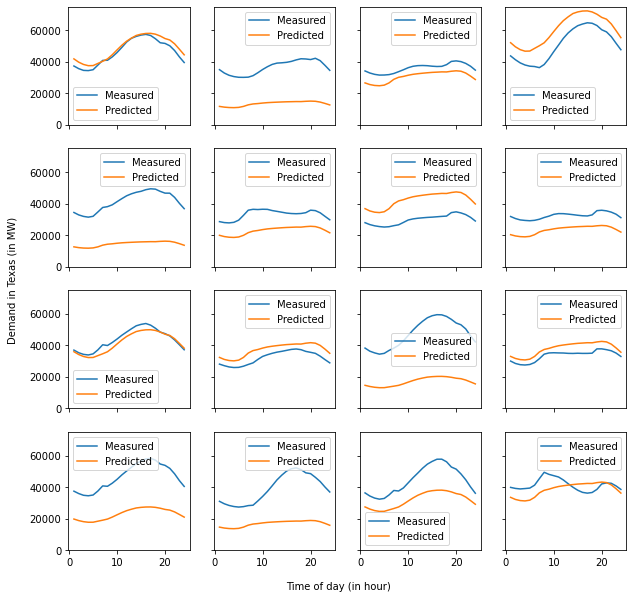

In [10]:
# Output the accuracy of the regressor on the test data.
predictedY = model.predict(testX)

# Plot the predicted load and compare against the actual load from the test data.
assert(nTest >= 16)
days = random.sample(range(nTest), 16)

fig, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(10,10))
axs = axs.ravel()


for dd, day in enumerate(days):
    testYDay = testY[day]
    predictedYDay = predictedY[day]

    l1 = axs[dd].plot(range(1, 25), testYDay, label='Measured')
    l2 = axs[dd].plot(range(1, 25), predictedYDay, label='Predicted')
    
    axs[dd].set_ylim(bottom=0, top=75000)
    axs[dd].legend()

fig.text(0.5, 0.07, 'Time of day (in hour)', ha='center')
fig.text(0.04, 0.5, 'Demand in Texas (in MW)', va='center', rotation='vertical')

plt.show()

**Question (10 points).** Explore how the number of epochs affects the accuracy and speed of training. Start with 10 epochs, and increase it to 100, 1000, 5000, 10000, and maybe more (do not exceed 20000 unless you have a powerful computer, you are only required to do up to 10000 for this lab). Make comments based on your observations. As an engineer, what is your favorite number of epochs, and why? 

**As I increase the number of epochs, the training loss decreases but the time to finish training increases. As an engineer, my favorite number of epochs would be a very very large number, in this case 10,000. Generally as you increase the number of epochs the training loss decreases as well, however, it is also important to not overfit the model by choosing an unreasonably large epoch size.**

**Question (15 points).** Fix the number of epochs to your favorite one. Then, add another layer to the network. Discuss what your observe in terms of speed and accuracy. 

**Your answer (comments here, code below). Your code should show the results for the case with an additional hidden layer. Go back to the codes above for the 1 layer case and run it again for the same number of epochs/neurons.**


**By adding the additional hidden layer the time to finish training increased but the training loss decreased by almost 3 times!. Currently, more than half of the predictions are very similar to the actual results. I think with an additional layer and increasing the number of epochs to be greater than 20,000, I could reduce the training loss so that the majority of the predictions line up with the actual results.**

Fit model on training data
Train on 286 samples
Epoch 1/10000
286/286 [==============================] - 0s 2ms/sample - loss: 1630602227.4685
Epoch 2/10000
286/286 [==============================] - 0s 65us/sample - loss: 1626807116.9790
Epoch 3/10000
286/286 [==============================] - 0s 66us/sample - loss: 1616435068.8671
Epoch 4/10000
286/286 [==============================] - 0s 76us/sample - loss: 1600033408.0000
Epoch 5/10000
286/286 [==============================] - 0s 69us/sample - loss: 1578327749.3706
Epoch 6/10000
286/286 [==============================] - 0s 67us/sample - loss: 1552400766.6573
Epoch 7/10000
286/286 [==============================] - 0s 64us/sample - loss: 1523044710.4895
Epoch 8/10000
286/286 [==============================] - 0s 66us/sample - loss: 1490904465.0070
Epoch 9/10000
286/286 [==============================] - 0s 68us/sample - loss: 1456572586.9650
Epoch 10/10000
286/286 [==============================] - 0s 71us/sample - loss: 14202184

286/286 [==============================] - 0s 60us/sample - loss: 308904399.1049
Epoch 170/10000
286/286 [==============================] - 0s 61us/sample - loss: 308802476.3636
Epoch 171/10000
286/286 [==============================] - 0s 60us/sample - loss: 308663563.4126
Epoch 172/10000
286/286 [==============================] - 0s 63us/sample - loss: 308678693.2028
Epoch 173/10000
286/286 [==============================] - 0s 61us/sample - loss: 308524576.9510
Epoch 174/10000
286/286 [==============================] - 0s 54us/sample - loss: 308417820.3077
Epoch 175/10000
286/286 [==============================] - 0s 57us/sample - loss: 308324434.0140
Epoch 176/10000
286/286 [==============================] - 0s 59us/sample - loss: 308267762.0140
Epoch 177/10000
286/286 [==============================] - 0s 61us/sample - loss: 308163045.4825
Epoch 178/10000
286/286 [==============================] - 0s 62us/sample - loss: 308137038.7133
Epoch 179/10000
286/286 [=====================

286/286 [==============================] - 0s 57us/sample - loss: 297114874.1818
Epoch 338/10000
286/286 [==============================] - 0s 59us/sample - loss: 297022866.2378
Epoch 339/10000
286/286 [==============================] - 0s 57us/sample - loss: 297034058.3497
Epoch 340/10000
286/286 [==============================] - 0s 57us/sample - loss: 296947287.1608
Epoch 341/10000
286/286 [==============================] - 0s 59us/sample - loss: 296838403.4685
Epoch 342/10000
286/286 [==============================] - 0s 56us/sample - loss: 296840097.7902
Epoch 343/10000
286/286 [==============================] - 0s 56us/sample - loss: 296783757.6503
Epoch 344/10000
286/286 [==============================] - 0s 56us/sample - loss: 296674416.8951
Epoch 345/10000
286/286 [==============================] - 0s 62us/sample - loss: 296612827.5804
Epoch 346/10000
286/286 [==============================] - 0s 54us/sample - loss: 296559665.0629
Epoch 347/10000
286/286 [=====================

Epoch 505/10000
286/286 [==============================] - 0s 60us/sample - loss: 287713505.9021
Epoch 506/10000
286/286 [==============================] - 0s 61us/sample - loss: 287629761.0070
Epoch 507/10000
286/286 [==============================] - 0s 61us/sample - loss: 287677656.7832
Epoch 508/10000
286/286 [==============================] - 0s 59us/sample - loss: 287564722.6294
Epoch 509/10000
286/286 [==============================] - 0s 62us/sample - loss: 287514185.6783
Epoch 510/10000
286/286 [==============================] - 0s 61us/sample - loss: 287441415.2168
Epoch 511/10000
286/286 [==============================] - 0s 61us/sample - loss: 287378250.9650
Epoch 512/10000
286/286 [==============================] - 0s 58us/sample - loss: 287331696.1119
Epoch 513/10000
286/286 [==============================] - 0s 61us/sample - loss: 287292495.0490
Epoch 514/10000
286/286 [==============================] - 0s 61us/sample - loss: 287227789.8741
Epoch 515/10000
286/286 [=====

286/286 [==============================] - 0s 60us/sample - loss: 278929430.2657
Epoch 674/10000
286/286 [==============================] - 0s 59us/sample - loss: 278867956.5874
Epoch 675/10000
286/286 [==============================] - 0s 61us/sample - loss: 278787467.8601
Epoch 676/10000
286/286 [==============================] - 0s 58us/sample - loss: 278748379.5804
Epoch 677/10000
286/286 [==============================] - 0s 62us/sample - loss: 278685059.5245
Epoch 678/10000
286/286 [==============================] - 0s 63us/sample - loss: 278602888.9510
Epoch 679/10000
286/286 [==============================] - 0s 67us/sample - loss: 278569014.0420
Epoch 680/10000
286/286 [==============================] - 0s 59us/sample - loss: 278496593.2308
Epoch 681/10000
286/286 [==============================] - 0s 58us/sample - loss: 278443331.0769
Epoch 682/10000
286/286 [==============================] - 0s 57us/sample - loss: 278434417.1748
Epoch 683/10000
286/286 [=====================

286/286 [==============================] - 0s 59us/sample - loss: 269627800.0559
Epoch 842/10000
286/286 [==============================] - 0s 57us/sample - loss: 269658127.2168
Epoch 843/10000
286/286 [==============================] - 0s 60us/sample - loss: 269516705.4545
Epoch 844/10000
286/286 [==============================] - 0s 56us/sample - loss: 269483916.6993
Epoch 845/10000
286/286 [==============================] - 0s 56us/sample - loss: 269403734.6014
Epoch 846/10000
286/286 [==============================] - 0s 55us/sample - loss: 269351837.0909
Epoch 847/10000
286/286 [==============================] - 0s 60us/sample - loss: 269325444.7552
Epoch 848/10000
286/286 [==============================] - 0s 55us/sample - loss: 269245867.4126
Epoch 849/10000
286/286 [==============================] - 0s 57us/sample - loss: 269199651.0210
Epoch 850/10000
286/286 [==============================] - 0s 57us/sample - loss: 269114304.0000
Epoch 851/10000
286/286 [=====================

286/286 [==============================] - 0s 54us/sample - loss: 259459700.7552
Epoch 1010/10000
286/286 [==============================] - 0s 58us/sample - loss: 259395839.5524
Epoch 1011/10000
286/286 [==============================] - 0s 56us/sample - loss: 259301382.6014
Epoch 1012/10000
286/286 [==============================] - 0s 57us/sample - loss: 259225618.9091
Epoch 1013/10000
286/286 [==============================] - 0s 60us/sample - loss: 259182086.2098
Epoch 1014/10000
286/286 [==============================] - 0s 55us/sample - loss: 259117145.3427
Epoch 1015/10000
286/286 [==============================] - 0s 54us/sample - loss: 259061679.2727
Epoch 1016/10000
286/286 [==============================] - 0s 59us/sample - loss: 258981480.5035
Epoch 1017/10000
286/286 [==============================] - 0s 61us/sample - loss: 258931268.8671
Epoch 1018/10000
286/286 [==============================] - 0s 59us/sample - loss: 258815186.0140
Epoch 1019/10000
286/286 [===========

286/286 [==============================] - 0s 64us/sample - loss: 247005507.0210
Epoch 1176/10000
286/286 [==============================] - 0s 64us/sample - loss: 246947670.5455
Epoch 1177/10000
286/286 [==============================] - 0s 59us/sample - loss: 246840053.3147
Epoch 1178/10000
286/286 [==============================] - 0s 57us/sample - loss: 246762652.9790
Epoch 1179/10000
286/286 [==============================] - 0s 59us/sample - loss: 246617277.9860
Epoch 1180/10000
286/286 [==============================] - 0s 55us/sample - loss: 246534751.5524
Epoch 1181/10000
286/286 [==============================] - 0s 60us/sample - loss: 246510380.5874
Epoch 1182/10000
286/286 [==============================] - 0s 57us/sample - loss: 246361295.2168
Epoch 1183/10000
286/286 [==============================] - 0s 62us/sample - loss: 246272587.5804
Epoch 1184/10000
286/286 [==============================] - 0s 64us/sample - loss: 246222380.6434
Epoch 1185/10000
286/286 [===========

286/286 [==============================] - 0s 61us/sample - loss: 229845998.7133
Epoch 1342/10000
286/286 [==============================] - 0s 59us/sample - loss: 229759145.3427
Epoch 1343/10000
286/286 [==============================] - 0s 59us/sample - loss: 229647421.2587
Epoch 1344/10000
286/286 [==============================] - 0s 62us/sample - loss: 229505980.2517
Epoch 1345/10000
286/286 [==============================] - 0s 61us/sample - loss: 229382566.8252
Epoch 1346/10000
286/286 [==============================] - 0s 62us/sample - loss: 229247862.3776
Epoch 1347/10000
286/286 [==============================] - 0s 63us/sample - loss: 229205733.6503
Epoch 1348/10000
286/286 [==============================] - 0s 58us/sample - loss: 229029128.1678
Epoch 1349/10000
286/286 [==============================] - 0s 55us/sample - loss: 228905484.2517
Epoch 1350/10000
286/286 [==============================] - 0s 57us/sample - loss: 228768908.6993
Epoch 1351/10000
286/286 [===========

286/286 [==============================] - 0s 56us/sample - loss: 207392660.6993
Epoch 1508/10000
286/286 [==============================] - 0s 54us/sample - loss: 207255816.8392
Epoch 1509/10000
286/286 [==============================] - 0s 56us/sample - loss: 207094597.5385
Epoch 1510/10000
286/286 [==============================] - 0s 55us/sample - loss: 206923583.3846
Epoch 1511/10000
286/286 [==============================] - 0s 58us/sample - loss: 206768132.4196
Epoch 1512/10000
286/286 [==============================] - 0s 58us/sample - loss: 206627736.1119
Epoch 1513/10000
286/286 [==============================] - 0s 58us/sample - loss: 206514693.2028
Epoch 1514/10000
286/286 [==============================] - 0s 58us/sample - loss: 206322461.6503
Epoch 1515/10000
286/286 [==============================] - 0s 57us/sample - loss: 206181104.5594
Epoch 1516/10000
286/286 [==============================] - 0s 58us/sample - loss: 206003387.3007
Epoch 1517/10000
286/286 [===========

286/286 [==============================] - 0s 56us/sample - loss: 178525568.6713
Epoch 1674/10000
286/286 [==============================] - 0s 57us/sample - loss: 178322825.5664
Epoch 1675/10000
286/286 [==============================] - 0s 57us/sample - loss: 178134292.4755
Epoch 1676/10000
286/286 [==============================] - 0s 56us/sample - loss: 177974102.3776
Epoch 1677/10000
286/286 [==============================] - 0s 56us/sample - loss: 177764629.8182
Epoch 1678/10000
286/286 [==============================] - 0s 81us/sample - loss: 177569412.1678
Epoch 1679/10000
286/286 [==============================] - 0s 56us/sample - loss: 177395842.1259
Epoch 1680/10000
286/286 [==============================] - 0s 53us/sample - loss: 177208965.1469
Epoch 1681/10000
286/286 [==============================] - 0s 55us/sample - loss: 177010701.8741
Epoch 1682/10000
286/286 [==============================] - 0s 57us/sample - loss: 176857469.4825
Epoch 1683/10000
286/286 [===========

286/286 [==============================] - 0s 57us/sample - loss: 146690775.1329
Epoch 1839/10000
286/286 [==============================] - 0s 56us/sample - loss: 146482201.1189
Epoch 1840/10000
286/286 [==============================] - 0s 59us/sample - loss: 146320281.9860
Epoch 1841/10000
286/286 [==============================] - 0s 58us/sample - loss: 146077681.3147
Epoch 1842/10000
286/286 [==============================] - 0s 57us/sample - loss: 145890816.2797
Epoch 1843/10000
286/286 [==============================] - 0s 54us/sample - loss: 145702780.3357
Epoch 1844/10000
286/286 [==============================] - 0s 55us/sample - loss: 145499415.2727
Epoch 1845/10000
286/286 [==============================] - 0s 57us/sample - loss: 145290544.5874
Epoch 1846/10000
286/286 [==============================] - 0s 58us/sample - loss: 145100775.3287
Epoch 1847/10000
286/286 [==============================] - 0s 58us/sample - loss: 144904731.7762
Epoch 1848/10000
286/286 [===========

286/286 [==============================] - 0s 57us/sample - loss: 114552507.4126
Epoch 2005/10000
286/286 [==============================] - 0s 59us/sample - loss: 114348109.2028
Epoch 2006/10000
286/286 [==============================] - 0s 57us/sample - loss: 114191328.9790
Epoch 2007/10000
286/286 [==============================] - 0s 57us/sample - loss: 113984185.0070
Epoch 2008/10000
286/286 [==============================] - 0s 55us/sample - loss: 113799303.9720
Epoch 2009/10000
286/286 [==============================] - 0s 58us/sample - loss: 113618525.5944
Epoch 2010/10000
286/286 [==============================] - 0s 58us/sample - loss: 113426674.0699
Epoch 2011/10000
286/286 [==============================] - 0s 58us/sample - loss: 113234903.3566
Epoch 2012/10000
286/286 [==============================] - 0s 61us/sample - loss: 113058237.8741
Epoch 2013/10000
286/286 [==============================] - 0s 60us/sample - loss: 112884063.8042
Epoch 2014/10000
286/286 [===========

286/286 [==============================] - 0s 56us/sample - loss: 87725292.8951
Epoch 2172/10000
286/286 [==============================] - 0s 59us/sample - loss: 87598260.0280
Epoch 2173/10000
286/286 [==============================] - ETA: 0s - loss: 90692168.00 - 0s 53us/sample - loss: 87450740.7273
Epoch 2174/10000
286/286 [==============================] - 0s 59us/sample - loss: 87325676.0000
Epoch 2175/10000
286/286 [==============================] - 0s 56us/sample - loss: 87220581.8741
Epoch 2176/10000
286/286 [==============================] - 0s 56us/sample - loss: 87078235.0490
Epoch 2177/10000
286/286 [==============================] - 0s 58us/sample - loss: 86927882.4336
Epoch 2178/10000
286/286 [==============================] - 0s 58us/sample - loss: 86809563.7762
Epoch 2179/10000
286/286 [==============================] - 0s 61us/sample - loss: 86683559.1329
Epoch 2180/10000
286/286 [==============================] - 0s 58us/sample - loss: 86539741.5664
Epoch 2181/10000


286/286 [==============================] - 0s 58us/sample - loss: 77631799.8741
Epoch 2256/10000
286/286 [==============================] - 0s 59us/sample - loss: 77507453.9301
Epoch 2257/10000
286/286 [==============================] - 0s 57us/sample - loss: 77402472.3357
Epoch 2258/10000
286/286 [==============================] - 0s 58us/sample - loss: 77289491.5804
Epoch 2259/10000
286/286 [==============================] - 0s 61us/sample - loss: 77197059.0769
Epoch 2260/10000
286/286 [==============================] - 0s 63us/sample - loss: 77095400.7273
Epoch 2261/10000
286/286 [==============================] - 0s 59us/sample - loss: 76978041.9580
Epoch 2262/10000
286/286 [==============================] - 0s 61us/sample - loss: 76863165.4545
Epoch 2263/10000
286/286 [==============================] - 0s 61us/sample - loss: 76769801.2028
Epoch 2264/10000
286/286 [==============================] - 0s 61us/sample - loss: 76674693.6503
Epoch 2265/10000
286/286 [=====================

286/286 [==============================] - 0s 60us/sample - loss: 64056404.2378
Epoch 2424/10000
286/286 [==============================] - 0s 56us/sample - loss: 64004343.2587
Epoch 2425/10000
286/286 [==============================] - 0s 56us/sample - loss: 63942338.4196
Epoch 2426/10000
286/286 [==============================] - 0s 58us/sample - loss: 63897414.7692
Epoch 2427/10000
286/286 [==============================] - 0s 54us/sample - loss: 63839163.0490
Epoch 2428/10000
286/286 [==============================] - 0s 59us/sample - loss: 63773829.8182
Epoch 2429/10000
286/286 [==============================] - 0s 57us/sample - loss: 63717202.1119
Epoch 2430/10000
286/286 [==============================] - 0s 57us/sample - loss: 63655928.9650
Epoch 2431/10000
286/286 [==============================] - 0s 61us/sample - loss: 63614992.4056
Epoch 2432/10000
286/286 [==============================] - 0s 57us/sample - loss: 63564828.0699
Epoch 2433/10000
286/286 [=====================

286/286 [==============================] - 0s 61us/sample - loss: 56622863.6503
Epoch 2592/10000
286/286 [==============================] - 0s 65us/sample - loss: 56591712.0839
Epoch 2593/10000
286/286 [==============================] - 0s 73us/sample - loss: 56555807.8322
Epoch 2594/10000
286/286 [==============================] - 0s 68us/sample - loss: 56533059.9301
Epoch 2595/10000
286/286 [==============================] - 0s 64us/sample - loss: 56488106.2937
Epoch 2596/10000
286/286 [==============================] - 0s 74us/sample - loss: 56449142.7413
Epoch 2597/10000
286/286 [==============================] - 0s 70us/sample - loss: 56423208.9650
Epoch 2598/10000
286/286 [==============================] - 0s 68us/sample - loss: 56376884.2098
Epoch 2599/10000
286/286 [==============================] - 0s 66us/sample - loss: 56340932.5734
Epoch 2600/10000
286/286 [==============================] - 0s 85us/sample - loss: 56319651.0629
Epoch 2601/10000
286/286 [=====================

286/286 [==============================] - 0s 89us/sample - loss: 51607232.8531
Epoch 2760/10000
286/286 [==============================] - 0s 80us/sample - loss: 51571181.3706
Epoch 2761/10000
286/286 [==============================] - 0s 73us/sample - loss: 51542311.9860
Epoch 2762/10000
286/286 [==============================] - 0s 67us/sample - loss: 51525643.3846
Epoch 2763/10000
286/286 [==============================] - 0s 68us/sample - loss: 51497058.6713
Epoch 2764/10000
286/286 [==============================] - 0s 70us/sample - loss: 51477254.1119
Epoch 2765/10000
286/286 [==============================] - 0s 104us/sample - loss: 51446322.8252
Epoch 2766/10000
286/286 [==============================] - 0s 87us/sample - loss: 51418541.2308
Epoch 2767/10000
286/286 [==============================] - 0s 80us/sample - loss: 51394112.0420
Epoch 2768/10000
286/286 [==============================] - 0s 80us/sample - loss: 51364771.4825
Epoch 2769/10000
286/286 [====================

286/286 [==============================] - 0s 61us/sample - loss: 47868102.3217
Epoch 2928/10000
286/286 [==============================] - 0s 62us/sample - loss: 47859169.9301
Epoch 2929/10000
286/286 [==============================] - 0s 63us/sample - loss: 47854836.3497
Epoch 2930/10000
286/286 [==============================] - 0s 60us/sample - loss: 47814777.3846
Epoch 2931/10000
286/286 [==============================] - 0s 62us/sample - loss: 47793937.2448
Epoch 2932/10000
286/286 [==============================] - 0s 65us/sample - loss: 47774537.5245
Epoch 2933/10000
286/286 [==============================] - 0s 62us/sample - loss: 47762910.6154
Epoch 2934/10000
286/286 [==============================] - 0s 59us/sample - loss: 47737872.9650
Epoch 2935/10000
286/286 [==============================] - 0s 59us/sample - loss: 47724977.4406
Epoch 2936/10000
286/286 [==============================] - 0s 64us/sample - loss: 47706725.9580
Epoch 2937/10000
286/286 [=====================

286/286 [==============================] - 0s 63us/sample - loss: 45084387.5804
Epoch 3096/10000
286/286 [==============================] - 0s 57us/sample - loss: 45052791.1049
Epoch 3097/10000
286/286 [==============================] - 0s 55us/sample - loss: 45040396.8531
Epoch 3098/10000
286/286 [==============================] - 0s 56us/sample - loss: 45032477.4895
Epoch 3099/10000
286/286 [==============================] - 0s 53us/sample - loss: 45014289.1329
Epoch 3100/10000
286/286 [==============================] - 0s 52us/sample - loss: 44996205.7063
Epoch 3101/10000
286/286 [==============================] - 0s 54us/sample - loss: 44983059.1748
Epoch 3102/10000
286/286 [==============================] - 0s 54us/sample - loss: 44972404.2238
Epoch 3103/10000
286/286 [==============================] - 0s 55us/sample - loss: 44949903.4406
Epoch 3104/10000
286/286 [==============================] - 0s 54us/sample - loss: 44935873.0769
Epoch 3105/10000
286/286 [=====================

286/286 [==============================] - 0s 59us/sample - loss: 42764115.8322
Epoch 3264/10000
286/286 [==============================] - 0s 56us/sample - loss: 42759325.6364
Epoch 3265/10000
286/286 [==============================] - 0s 57us/sample - loss: 42750694.5175
Epoch 3266/10000
286/286 [==============================] - 0s 58us/sample - loss: 42737504.1538
Epoch 3267/10000
286/286 [==============================] - 0s 55us/sample - loss: 42716399.3007
Epoch 3268/10000
286/286 [==============================] - 0s 55us/sample - loss: 42707736.3497
Epoch 3269/10000
286/286 [==============================] - 0s 58us/sample - loss: 42691796.6154
Epoch 3270/10000
286/286 [==============================] - 0s 57us/sample - loss: 42685835.0350
Epoch 3271/10000
286/286 [==============================] - 0s 57us/sample - loss: 42671949.5874
Epoch 3272/10000
286/286 [==============================] - 0s 56us/sample - loss: 42652557.0210
Epoch 3273/10000
286/286 [=====================

286/286 [==============================] - 0s 55us/sample - loss: 40821889.8601
Epoch 3432/10000
286/286 [==============================] - 0s 56us/sample - loss: 40803104.7832
Epoch 3433/10000
286/286 [==============================] - 0s 54us/sample - loss: 40795201.6503
Epoch 3434/10000
286/286 [==============================] - 0s 54us/sample - loss: 40789323.7343
Epoch 3435/10000
286/286 [==============================] - 0s 55us/sample - loss: 40776594.3497
Epoch 3436/10000
286/286 [==============================] - 0s 57us/sample - loss: 40766984.9021
Epoch 3437/10000
286/286 [==============================] - 0s 55us/sample - loss: 40757701.5385
Epoch 3438/10000
286/286 [==============================] - 0s 55us/sample - loss: 40746283.8881
Epoch 3439/10000
286/286 [==============================] - 0s 56us/sample - loss: 40737628.6923
Epoch 3440/10000
286/286 [==============================] - 0s 58us/sample - loss: 40721088.8811
Epoch 3441/10000
286/286 [=====================

286/286 [==============================] - 0s 55us/sample - loss: 39113193.7483
Epoch 3600/10000
286/286 [==============================] - 0s 58us/sample - loss: 39108605.2378
Epoch 3601/10000
286/286 [==============================] - 0s 57us/sample - loss: 39097156.4406
Epoch 3602/10000
286/286 [==============================] - 0s 58us/sample - loss: 39083854.3077
Epoch 3603/10000
286/286 [==============================] - 0s 56us/sample - loss: 39078009.0979
Epoch 3604/10000
286/286 [==============================] - 0s 60us/sample - loss: 39067000.6154
Epoch 3605/10000
286/286 [==============================] - 0s 58us/sample - loss: 39068139.9580
Epoch 3606/10000
286/286 [==============================] - 0s 60us/sample - loss: 39051661.5944
Epoch 3607/10000
286/286 [==============================] - 0s 58us/sample - loss: 39051015.2727
Epoch 3608/10000
286/286 [==============================] - 0s 59us/sample - loss: 39037221.3706
Epoch 3609/10000
286/286 [=====================

286/286 [==============================] - 0s 56us/sample - loss: 37580493.5245
Epoch 3768/10000
286/286 [==============================] - 0s 57us/sample - loss: 37576071.1608
Epoch 3769/10000
286/286 [==============================] - 0s 63us/sample - loss: 37559782.9091
Epoch 3770/10000
286/286 [==============================] - 0s 67us/sample - loss: 37559921.3357
Epoch 3771/10000
286/286 [==============================] - 0s 64us/sample - loss: 37548761.6713
Epoch 3772/10000
286/286 [==============================] - 0s 63us/sample - loss: 37544859.9371
Epoch 3773/10000
286/286 [==============================] - 0s 66us/sample - loss: 37530495.0350
Epoch 3774/10000
286/286 [==============================] - 0s 63us/sample - loss: 37525423.6503
Epoch 3775/10000
286/286 [==============================] - 0s 64us/sample - loss: 37516862.3776
Epoch 3776/10000
286/286 [==============================] - 0s 68us/sample - loss: 37500133.7832
Epoch 3777/10000
286/286 [=====================

286/286 [==============================] - 0s 57us/sample - loss: 36188572.0839
Epoch 3936/10000
286/286 [==============================] - 0s 57us/sample - loss: 36170923.6084
Epoch 3937/10000
286/286 [==============================] - 0s 57us/sample - loss: 36165191.9930
Epoch 3938/10000
286/286 [==============================] - 0s 57us/sample - loss: 36150419.0909
Epoch 3939/10000
286/286 [==============================] - 0s 56us/sample - loss: 36143129.0769
Epoch 3940/10000
286/286 [==============================] - 0s 57us/sample - loss: 36140532.9091
Epoch 3941/10000
286/286 [==============================] - 0s 57us/sample - loss: 36130414.8392
Epoch 3942/10000
286/286 [==============================] - 0s 56us/sample - loss: 36126697.1818
Epoch 3943/10000
286/286 [==============================] - 0s 58us/sample - loss: 36119254.2028
Epoch 3944/10000
286/286 [==============================] - 0s 58us/sample - loss: 36106045.2028
Epoch 3945/10000
286/286 [=====================

286/286 [==============================] - 0s 57us/sample - loss: 34908475.6084
Epoch 4104/10000
286/286 [==============================] - 0s 65us/sample - loss: 34893153.1818
Epoch 4105/10000
286/286 [==============================] - 0s 61us/sample - loss: 34883540.3706
Epoch 4106/10000
286/286 [==============================] - 0s 62us/sample - loss: 34878333.5105
Epoch 4107/10000
286/286 [==============================] - 0s 61us/sample - loss: 34867717.1259
Epoch 4108/10000
286/286 [==============================] - 0s 61us/sample - loss: 34859295.0420
Epoch 4109/10000
286/286 [==============================] - 0s 61us/sample - loss: 34858362.2937
Epoch 4110/10000
286/286 [==============================] - 0s 61us/sample - loss: 34859327.6853
Epoch 4111/10000
286/286 [==============================] - 0s 64us/sample - loss: 34841338.8112
Epoch 4112/10000
286/286 [==============================] - 0s 63us/sample - loss: 34835066.0000
Epoch 4113/10000
286/286 [=====================

286/286 [==============================] - 0s 58us/sample - loss: 33702645.3427
Epoch 4272/10000
286/286 [==============================] - 0s 57us/sample - loss: 33704266.4476
Epoch 4273/10000
286/286 [==============================] - 0s 60us/sample - loss: 33689981.2238
Epoch 4274/10000
286/286 [==============================] - 0s 61us/sample - loss: 33690964.6434
Epoch 4275/10000
286/286 [==============================] - 0s 60us/sample - loss: 33694563.7972
Epoch 4276/10000
286/286 [==============================] - 0s 59us/sample - loss: 33675790.6434
Epoch 4277/10000
286/286 [==============================] - 0s 57us/sample - loss: 33668631.6434
Epoch 4278/10000
286/286 [==============================] - 0s 57us/sample - loss: 33660069.7483
Epoch 4279/10000
286/286 [==============================] - 0s 61us/sample - loss: 33654058.7063
Epoch 4280/10000
286/286 [==============================] - 0s 55us/sample - loss: 33647925.1958
Epoch 4281/10000
286/286 [=====================

286/286 [==============================] - 0s 57us/sample - loss: 32576010.9790
Epoch 4440/10000
286/286 [==============================] - 0s 58us/sample - loss: 32579050.5455
Epoch 4441/10000
286/286 [==============================] - 0s 59us/sample - loss: 32569955.6783
Epoch 4442/10000
286/286 [==============================] - 0s 57us/sample - loss: 32562291.1608
Epoch 4443/10000
286/286 [==============================] - 0s 60us/sample - loss: 32549443.3357
Epoch 4444/10000
286/286 [==============================] - 0s 58us/sample - loss: 32542096.5315
Epoch 4445/10000
286/286 [==============================] - 0s 56us/sample - loss: 32547209.4476
Epoch 4446/10000
286/286 [==============================] - 0s 56us/sample - loss: 32530633.4126
Epoch 4447/10000
286/286 [==============================] - 0s 59us/sample - loss: 32531553.7902
Epoch 4448/10000
286/286 [==============================] - 0s 59us/sample - loss: 32516617.7622
Epoch 4449/10000
286/286 [=====================

286/286 [==============================] - 0s 62us/sample - loss: 31512429.0000
Epoch 4608/10000
286/286 [==============================] - 0s 61us/sample - loss: 31502026.5944
Epoch 4609/10000
286/286 [==============================] - 0s 64us/sample - loss: 31497120.4406
Epoch 4610/10000
286/286 [==============================] - 0s 59us/sample - loss: 31490874.4755
Epoch 4611/10000
286/286 [==============================] - 0s 61us/sample - loss: 31488445.1119
Epoch 4612/10000
286/286 [==============================] - 0s 61us/sample - loss: 31476383.6084
Epoch 4613/10000
286/286 [==============================] - 0s 58us/sample - loss: 31488115.0839
Epoch 4614/10000
286/286 [==============================] - 0s 62us/sample - loss: 31474919.7133
Epoch 4615/10000
286/286 [==============================] - 0s 57us/sample - loss: 31462459.6923
Epoch 4616/10000
286/286 [==============================] - 0s 60us/sample - loss: 31455996.0699
Epoch 4617/10000
286/286 [=====================

286/286 [==============================] - 0s 55us/sample - loss: 30512266.7972
Epoch 4776/10000
286/286 [==============================] - 0s 57us/sample - loss: 30503081.7552
Epoch 4777/10000
286/286 [==============================] - 0s 57us/sample - loss: 30495010.7133
Epoch 4778/10000
286/286 [==============================] - 0s 57us/sample - loss: 30496842.9371
Epoch 4779/10000
286/286 [==============================] - 0s 57us/sample - loss: 30487183.7762
Epoch 4780/10000
286/286 [==============================] - 0s 59us/sample - loss: 30482767.9371
Epoch 4781/10000
286/286 [==============================] - 0s 60us/sample - loss: 30476272.8182
Epoch 4782/10000
286/286 [==============================] - 0s 57us/sample - loss: 30464778.6783
Epoch 4783/10000
286/286 [==============================] - 0s 70us/sample - loss: 30458540.6364
Epoch 4784/10000
286/286 [==============================] - 0s 62us/sample - loss: 30457346.6014
Epoch 4785/10000
286/286 [=====================

286/286 [==============================] - 0s 58us/sample - loss: 29552237.9930
Epoch 4944/10000
286/286 [==============================] - 0s 58us/sample - loss: 29548019.7832
Epoch 4945/10000
286/286 [==============================] - 0s 59us/sample - loss: 29547958.5944
Epoch 4946/10000
286/286 [==============================] - 0s 63us/sample - loss: 29536655.6713
Epoch 4947/10000
286/286 [==============================] - 0s 55us/sample - loss: 29528368.4965
Epoch 4948/10000
286/286 [==============================] - 0s 58us/sample - loss: 29532545.4196
Epoch 4949/10000
286/286 [==============================] - 0s 55us/sample - loss: 29525792.3357
Epoch 4950/10000
286/286 [==============================] - 0s 59us/sample - loss: 29510581.6224
Epoch 4951/10000
286/286 [==============================] - 0s 56us/sample - loss: 29507525.6434
Epoch 4952/10000
286/286 [==============================] - 0s 60us/sample - loss: 29503691.6294
Epoch 4953/10000
286/286 [=====================

286/286 [==============================] - 0s 56us/sample - loss: 28631450.9860
Epoch 5112/10000
286/286 [==============================] - 0s 66us/sample - loss: 28635108.4615
Epoch 5113/10000
286/286 [==============================] - 0s 57us/sample - loss: 28632573.4476
Epoch 5114/10000
286/286 [==============================] - 0s 56us/sample - loss: 28624718.9510
Epoch 5115/10000
286/286 [==============================] - 0s 70us/sample - loss: 28613156.1259
Epoch 5116/10000
286/286 [==============================] - 0s 57us/sample - loss: 28619288.1608
Epoch 5117/10000
286/286 [==============================] - 0s 60us/sample - loss: 28603064.7832
Epoch 5118/10000
286/286 [==============================] - 0s 60us/sample - loss: 28597719.6014
Epoch 5119/10000
286/286 [==============================] - 0s 58us/sample - loss: 28600380.3287
Epoch 5120/10000
286/286 [==============================] - 0s 56us/sample - loss: 28584974.9510
Epoch 5121/10000
286/286 [=====================

286/286 [==============================] - 0s 59us/sample - loss: 27756971.4056
Epoch 5280/10000
286/286 [==============================] - 0s 60us/sample - loss: 27757789.1189
Epoch 5281/10000
286/286 [==============================] - 0s 58us/sample - loss: 27743894.5804
Epoch 5282/10000
286/286 [==============================] - 0s 62us/sample - loss: 27750170.6643
Epoch 5283/10000
286/286 [==============================] - 0s 58us/sample - loss: 27736542.0699
Epoch 5284/10000
286/286 [==============================] - 0s 58us/sample - loss: 27736566.5245
Epoch 5285/10000
286/286 [==============================] - 0s 64us/sample - loss: 27736702.4755
Epoch 5286/10000
286/286 [==============================] - 0s 57us/sample - loss: 27723351.8042
Epoch 5287/10000
286/286 [==============================] - 0s 62us/sample - loss: 27719654.7273
Epoch 5288/10000
286/286 [==============================] - 0s 59us/sample - loss: 27717173.8322
Epoch 5289/10000
286/286 [=====================

286/286 [==============================] - 0s 56us/sample - loss: 26911052.0140
Epoch 5448/10000
286/286 [==============================] - 0s 58us/sample - loss: 26902310.1329
Epoch 5449/10000
286/286 [==============================] - 0s 58us/sample - loss: 26904825.0350
Epoch 5450/10000
286/286 [==============================] - 0s 62us/sample - loss: 26899050.8322
Epoch 5451/10000
286/286 [==============================] - 0s 59us/sample - loss: 26895858.4196
Epoch 5452/10000
286/286 [==============================] - 0s 58us/sample - loss: 26887904.8322
Epoch 5453/10000
286/286 [==============================] - 0s 66us/sample - loss: 26888035.8462
Epoch 5454/10000
286/286 [==============================] - 0s 59us/sample - loss: 26880750.5594
Epoch 5455/10000
286/286 [==============================] - 0s 55us/sample - loss: 26874193.6853
Epoch 5456/10000
286/286 [==============================] - 0s 58us/sample - loss: 26868529.3357
Epoch 5457/10000
286/286 [=====================

286/286 [==============================] - 0s 58us/sample - loss: 26097655.3427
Epoch 5616/10000
286/286 [==============================] - 0s 58us/sample - loss: 26087261.9790
Epoch 5617/10000
286/286 [==============================] - 0s 64us/sample - loss: 26080844.4056
Epoch 5618/10000
286/286 [==============================] - 0s 60us/sample - loss: 26075398.7273
Epoch 5619/10000
286/286 [==============================] - 0s 57us/sample - loss: 26075349.6993
Epoch 5620/10000
286/286 [==============================] - 0s 60us/sample - loss: 26066705.1888
Epoch 5621/10000
286/286 [==============================] - 0s 62us/sample - loss: 26068551.2797
Epoch 5622/10000
286/286 [==============================] - 0s 58us/sample - loss: 26057879.1888
Epoch 5623/10000
286/286 [==============================] - 0s 66us/sample - loss: 26052242.5385
Epoch 5624/10000
286/286 [==============================] - 0s 63us/sample - loss: 26051907.4615
Epoch 5625/10000
286/286 [=====================

286/286 [==============================] - 0s 60us/sample - loss: 25303782.2657
Epoch 5784/10000
286/286 [==============================] - 0s 58us/sample - loss: 25301041.0000
Epoch 5785/10000
286/286 [==============================] - 0s 62us/sample - loss: 25302747.2098
Epoch 5786/10000
286/286 [==============================] - 0s 58us/sample - loss: 25292978.3007
Epoch 5787/10000
286/286 [==============================] - 0s 64us/sample - loss: 25289423.1189
Epoch 5788/10000
286/286 [==============================] - 0s 59us/sample - loss: 25282932.0420
Epoch 5789/10000
286/286 [==============================] - 0s 63us/sample - loss: 25277519.3497
Epoch 5790/10000
286/286 [==============================] - 0s 59us/sample - loss: 25271492.0210
Epoch 5791/10000
286/286 [==============================] - 0s 62us/sample - loss: 25274461.5175
Epoch 5792/10000
286/286 [==============================] - 0s 60us/sample - loss: 25260300.4406
Epoch 5793/10000
286/286 [=====================

286/286 [==============================] - 0s 58us/sample - loss: 24547490.4336
Epoch 5952/10000
286/286 [==============================] - 0s 57us/sample - loss: 24543248.2168
Epoch 5953/10000
286/286 [==============================] - 0s 62us/sample - loss: 24544337.7902
Epoch 5954/10000
286/286 [==============================] - 0s 62us/sample - loss: 24533020.4126
Epoch 5955/10000
286/286 [==============================] - 0s 67us/sample - loss: 24529817.7622
Epoch 5956/10000
286/286 [==============================] - 0s 64us/sample - loss: 24524429.5035
Epoch 5957/10000
286/286 [==============================] - 0s 68us/sample - loss: 24535048.9161
Epoch 5958/10000
286/286 [==============================] - 0s 63us/sample - loss: 24515864.4685
Epoch 5959/10000
286/286 [==============================] - 0s 65us/sample - loss: 24508946.9790
Epoch 5960/10000
286/286 [==============================] - 0s 64us/sample - loss: 24507566.4056
Epoch 5961/10000
286/286 [=====================

286/286 [==============================] - 0s 60us/sample - loss: 23807930.1538
Epoch 6120/10000
286/286 [==============================] - 0s 56us/sample - loss: 23809118.5455
Epoch 6121/10000
286/286 [==============================] - 0s 57us/sample - loss: 23800320.5944
Epoch 6122/10000
286/286 [==============================] - 0s 56us/sample - loss: 23794649.9720
Epoch 6123/10000
286/286 [==============================] - 0s 62us/sample - loss: 23801212.0909
Epoch 6124/10000
286/286 [==============================] - 0s 57us/sample - loss: 23793334.7063
Epoch 6125/10000
286/286 [==============================] - 0s 61us/sample - loss: 23784210.5245
Epoch 6126/10000
286/286 [==============================] - 0s 60us/sample - loss: 23782003.4476
Epoch 6127/10000
286/286 [==============================] - 0s 61us/sample - loss: 23776096.6573
Epoch 6128/10000
286/286 [==============================] - 0s 58us/sample - loss: 23772966.0140
Epoch 6129/10000
286/286 [=====================

286/286 [==============================] - 0s 55us/sample - loss: 23116430.7203
Epoch 6288/10000
286/286 [==============================] - 0s 57us/sample - loss: 23114826.3217
Epoch 6289/10000
286/286 [==============================] - 0s 61us/sample - loss: 23112306.6434
Epoch 6290/10000
286/286 [==============================] - 0s 58us/sample - loss: 23105206.2517
Epoch 6291/10000
286/286 [==============================] - 0s 61us/sample - loss: 23100253.9371
Epoch 6292/10000
286/286 [==============================] - 0s 55us/sample - loss: 23100520.6573
Epoch 6293/10000
286/286 [==============================] - 0s 59us/sample - loss: 23096781.6783
Epoch 6294/10000
286/286 [==============================] - 0s 57us/sample - loss: 23091242.3986
Epoch 6295/10000
286/286 [==============================] - 0s 59us/sample - loss: 23086533.0350
Epoch 6296/10000
286/286 [==============================] - 0s 59us/sample - loss: 23083187.1888
Epoch 6297/10000
286/286 [=====================

286/286 [==============================] - 0s 62us/sample - loss: 22428675.1678
Epoch 6456/10000
286/286 [==============================] - 0s 57us/sample - loss: 22425922.5175
Epoch 6457/10000
286/286 [==============================] - 0s 58us/sample - loss: 22422166.4406
Epoch 6458/10000
286/286 [==============================] - 0s 59us/sample - loss: 22420164.2448
Epoch 6459/10000
286/286 [==============================] - 0s 57us/sample - loss: 22414702.3077
Epoch 6460/10000
286/286 [==============================] - 0s 59us/sample - loss: 22409569.4965
Epoch 6461/10000
286/286 [==============================] - 0s 56us/sample - loss: 22404038.0420
Epoch 6462/10000
286/286 [==============================] - 0s 59us/sample - loss: 22402129.7762
Epoch 6463/10000
286/286 [==============================] - 0s 57us/sample - loss: 22392983.9720
Epoch 6464/10000
286/286 [==============================] - 0s 58us/sample - loss: 22391313.0490
Epoch 6465/10000
286/286 [=====================

286/286 [==============================] - 0s 68us/sample - loss: 21780663.1189
Epoch 6624/10000
286/286 [==============================] - 0s 68us/sample - loss: 21773428.2692
Epoch 6625/10000
286/286 [==============================] - 0s 64us/sample - loss: 21772617.3357
Epoch 6626/10000
286/286 [==============================] - 0s 70us/sample - loss: 21765824.4790
Epoch 6627/10000
286/286 [==============================] - 0s 65us/sample - loss: 21763524.4615
Epoch 6628/10000
286/286 [==============================] - 0s 63us/sample - loss: 21761108.4755
Epoch 6629/10000
286/286 [==============================] - 0s 72us/sample - loss: 21763513.9720
Epoch 6630/10000
286/286 [==============================] - 0s 67us/sample - loss: 21753527.7273
Epoch 6631/10000
286/286 [==============================] - 0s 58us/sample - loss: 21748563.6923
Epoch 6632/10000
286/286 [==============================] - 0s 61us/sample - loss: 21748809.0000
Epoch 6633/10000
286/286 [=====================

286/286 [==============================] - 0s 58us/sample - loss: 21169752.6329
Epoch 6792/10000
286/286 [==============================] - 0s 57us/sample - loss: 21166666.2657
Epoch 6793/10000
286/286 [==============================] - 0s 57us/sample - loss: 21167230.8811
Epoch 6794/10000
286/286 [==============================] - 0s 61us/sample - loss: 21162424.7238
Epoch 6795/10000
286/286 [==============================] - 0s 60us/sample - loss: 21157649.8741
Epoch 6796/10000
286/286 [==============================] - 0s 60us/sample - loss: 21162041.8881
Epoch 6797/10000
286/286 [==============================] - 0s 56us/sample - loss: 21156394.4860
Epoch 6798/10000
286/286 [==============================] - 0s 57us/sample - loss: 21150777.0944
Epoch 6799/10000
286/286 [==============================] - 0s 58us/sample - loss: 21145256.5804
Epoch 6800/10000
286/286 [==============================] - 0s 60us/sample - loss: 21142556.8811
Epoch 6801/10000
286/286 [=====================

286/286 [==============================] - 0s 69us/sample - loss: 20575276.6643
Epoch 6960/10000
286/286 [==============================] - 0s 67us/sample - loss: 20569311.9196
Epoch 6961/10000
286/286 [==============================] - 0s 72us/sample - loss: 20565967.2937
Epoch 6962/10000
286/286 [==============================] - 0s 77us/sample - loss: 20556018.8182
Epoch 6963/10000
286/286 [==============================] - 0s 71us/sample - loss: 20558573.8042
Epoch 6964/10000
286/286 [==============================] - 0s 72us/sample - loss: 20553875.6014
Epoch 6965/10000
286/286 [==============================] - 0s 66us/sample - loss: 20546861.0000
Epoch 6966/10000
286/286 [==============================] - 0s 65us/sample - loss: 20544786.5035
Epoch 6967/10000
286/286 [==============================] - 0s 69us/sample - loss: 20543302.5175
Epoch 6968/10000
286/286 [==============================] - 0s 65us/sample - loss: 20538232.3112
Epoch 6969/10000
286/286 [=====================

286/286 [==============================] - 0s 63us/sample - loss: 19981349.1259
Epoch 7128/10000
286/286 [==============================] - 0s 65us/sample - loss: 19974482.4965
Epoch 7129/10000
286/286 [==============================] - 0s 69us/sample - loss: 19970905.4266
Epoch 7130/10000
286/286 [==============================] - 0s 64us/sample - loss: 19971358.7413
Epoch 7131/10000
286/286 [==============================] - 0s 64us/sample - loss: 19970800.3916
Epoch 7132/10000
286/286 [==============================] - 0s 59us/sample - loss: 19960508.8636
Epoch 7133/10000
286/286 [==============================] - 0s 64us/sample - loss: 19958472.4825
Epoch 7134/10000
286/286 [==============================] - 0s 63us/sample - loss: 19951555.3322
Epoch 7135/10000
286/286 [==============================] - 0s 63us/sample - loss: 19956386.9720
Epoch 7136/10000
286/286 [==============================] - 0s 64us/sample - loss: 19946503.3357
Epoch 7137/10000
286/286 [=====================

286/286 [==============================] - 0s 57us/sample - loss: 19380572.9196
Epoch 7296/10000
286/286 [==============================] - 0s 58us/sample - loss: 19377044.6364
Epoch 7297/10000
286/286 [==============================] - 0s 58us/sample - loss: 19375143.9091
Epoch 7298/10000
286/286 [==============================] - 0s 57us/sample - loss: 19374896.6154
Epoch 7299/10000
286/286 [==============================] - 0s 58us/sample - loss: 19366756.1888
Epoch 7300/10000
286/286 [==============================] - 0s 58us/sample - loss: 19361896.9930
Epoch 7301/10000
286/286 [==============================] - 0s 58us/sample - loss: 19357800.8601
Epoch 7302/10000
286/286 [==============================] - 0s 57us/sample - loss: 19358538.0594
Epoch 7303/10000
286/286 [==============================] - 0s 56us/sample - loss: 19358592.0035
Epoch 7304/10000
286/286 [==============================] - 0s 56us/sample - loss: 19356907.1469
Epoch 7305/10000
286/286 [=====================

286/286 [==============================] - 0s 56us/sample - loss: 18829034.8147
Epoch 7464/10000
286/286 [==============================] - 0s 55us/sample - loss: 18819279.8881
Epoch 7465/10000
286/286 [==============================] - 0s 58us/sample - loss: 18819745.8601
Epoch 7466/10000
286/286 [==============================] - 0s 55us/sample - loss: 18815602.6713
Epoch 7467/10000
286/286 [==============================] - 0s 58us/sample - loss: 18814145.9860
Epoch 7468/10000
286/286 [==============================] - 0s 58us/sample - loss: 18806683.7343
Epoch 7469/10000
286/286 [==============================] - 0s 55us/sample - loss: 18814270.0455
Epoch 7470/10000
286/286 [==============================] - 0s 58us/sample - loss: 18799834.7168
Epoch 7471/10000
286/286 [==============================] - 0s 61us/sample - loss: 18806867.1259
Epoch 7472/10000
286/286 [==============================] - 0s 55us/sample - loss: 18797898.3741
Epoch 7473/10000
286/286 [=====================

286/286 [==============================] - 0s 58us/sample - loss: 18306926.2832
Epoch 7632/10000
286/286 [==============================] - 0s 58us/sample - loss: 18299809.2448
Epoch 7633/10000
286/286 [==============================] - 0s 59us/sample - loss: 18298871.0594
Epoch 7634/10000
286/286 [==============================] - 0s 56us/sample - loss: 18293013.9650
Epoch 7635/10000
286/286 [==============================] - 0s 60us/sample - loss: 18292610.4720
Epoch 7636/10000
286/286 [==============================] - 0s 59us/sample - loss: 18290299.8531
Epoch 7637/10000
286/286 [==============================] - 0s 57us/sample - loss: 18298210.8951
Epoch 7638/10000
286/286 [==============================] - 0s 59us/sample - loss: 18282374.7867
Epoch 7639/10000
286/286 [==============================] - 0s 57us/sample - loss: 18277494.6538
Epoch 7640/10000
286/286 [==============================] - 0s 58us/sample - loss: 18278429.8042
Epoch 7641/10000
286/286 [=====================

286/286 [==============================] - 0s 62us/sample - loss: 17809684.0524
Epoch 7800/10000
286/286 [==============================] - 0s 59us/sample - loss: 17812983.4441
Epoch 7801/10000
286/286 [==============================] - 0s 61us/sample - loss: 17811244.9266
Epoch 7802/10000
286/286 [==============================] - 0s 61us/sample - loss: 17807348.4371
Epoch 7803/10000
286/286 [==============================] - 0s 62us/sample - loss: 17801079.0629
Epoch 7804/10000
286/286 [==============================] - 0s 62us/sample - loss: 17796269.2028
Epoch 7805/10000
286/286 [==============================] - 0s 58us/sample - loss: 17795403.8462
Epoch 7806/10000
286/286 [==============================] - 0s 61us/sample - loss: 17791287.6818
Epoch 7807/10000
286/286 [==============================] - 0s 61us/sample - loss: 17789389.6399
Epoch 7808/10000
286/286 [==============================] - 0s 59us/sample - loss: 17798340.6154
Epoch 7809/10000
286/286 [=====================

286/286 [==============================] - 0s 57us/sample - loss: 17351923.8706
Epoch 7968/10000
286/286 [==============================] - 0s 57us/sample - loss: 17345080.2902
Epoch 7969/10000
286/286 [==============================] - 0s 59us/sample - loss: 17343074.8462
Epoch 7970/10000
286/286 [==============================] - 0s 59us/sample - loss: 17335832.7448
Epoch 7971/10000
286/286 [==============================] - 0s 59us/sample - loss: 17333405.9336
Epoch 7972/10000
286/286 [==============================] - 0s 59us/sample - loss: 17331969.0594
Epoch 7973/10000
286/286 [==============================] - 0s 55us/sample - loss: 17333858.7902
Epoch 7974/10000
286/286 [==============================] - 0s 57us/sample - loss: 17322611.5594
Epoch 7975/10000
286/286 [==============================] - 0s 57us/sample - loss: 17324044.2028
Epoch 7976/10000
286/286 [==============================] - 0s 60us/sample - loss: 17318742.5385
Epoch 7977/10000
286/286 [=====================

286/286 [==============================] - 0s 58us/sample - loss: 16886877.3497
Epoch 8136/10000
286/286 [==============================] - 0s 57us/sample - loss: 16888772.7902
Epoch 8137/10000
286/286 [==============================] - 0s 58us/sample - loss: 16881609.7028
Epoch 8138/10000
286/286 [==============================] - 0s 57us/sample - loss: 16883276.9231
Epoch 8139/10000
286/286 [==============================] - 0s 60us/sample - loss: 16876141.2028
Epoch 8140/10000
286/286 [==============================] - 0s 55us/sample - loss: 16875189.3427
Epoch 8141/10000
286/286 [==============================] - 0s 57us/sample - loss: 16877432.3986
Epoch 8142/10000
286/286 [==============================] - 0s 56us/sample - loss: 16868488.1224
Epoch 8143/10000
286/286 [==============================] - 0s 57us/sample - loss: 16867045.5245
Epoch 8144/10000
286/286 [==============================] - 0s 57us/sample - loss: 16868166.6748
Epoch 8145/10000
286/286 [=====================

286/286 [==============================] - 0s 59us/sample - loss: 16448360.2622
Epoch 8304/10000
286/286 [==============================] - 0s 58us/sample - loss: 16445369.7203
Epoch 8305/10000
286/286 [==============================] - 0s 58us/sample - loss: 16439192.6748
Epoch 8306/10000
286/286 [==============================] - 0s 55us/sample - loss: 16439519.8427
Epoch 8307/10000
286/286 [==============================] - 0s 55us/sample - loss: 16443531.4056
Epoch 8308/10000
286/286 [==============================] - 0s 58us/sample - loss: 16432994.6329
Epoch 8309/10000
286/286 [==============================] - 0s 57us/sample - loss: 16430145.2133
Epoch 8310/10000
286/286 [==============================] - 0s 58us/sample - loss: 16432860.9895
Epoch 8311/10000
286/286 [==============================] - 0s 57us/sample - loss: 16426979.4580
Epoch 8312/10000
286/286 [==============================] - 0s 57us/sample - loss: 16427869.8112
Epoch 8313/10000
286/286 [=====================

286/286 [==============================] - 0s 57us/sample - loss: 16235862.0035
Epoch 8388/10000
286/286 [==============================] - 0s 56us/sample - loss: 16236918.9336
Epoch 8389/10000
286/286 [==============================] - 0s 59us/sample - loss: 16233111.2343
Epoch 8390/10000
286/286 [==============================] - 0s 59us/sample - loss: 16229858.1748
Epoch 8391/10000
286/286 [==============================] - 0s 55us/sample - loss: 16228569.5769
Epoch 8392/10000
286/286 [==============================] - 0s 57us/sample - loss: 16222156.5839
Epoch 8393/10000
286/286 [==============================] - 0s 56us/sample - loss: 16219653.0944
Epoch 8394/10000
286/286 [==============================] - 0s 55us/sample - loss: 16218825.4196
Epoch 8395/10000
286/286 [==============================] - 0s 57us/sample - loss: 16212854.1329
Epoch 8396/10000
286/286 [==============================] - 0s 58us/sample - loss: 16212780.6469
Epoch 8397/10000
286/286 [=====================

286/286 [==============================] - 0s 59us/sample - loss: 15819926.6469
Epoch 8556/10000
286/286 [==============================] - 0s 58us/sample - loss: 15814354.7203
Epoch 8557/10000
286/286 [==============================] - 0s 57us/sample - loss: 15813179.5490
Epoch 8558/10000
286/286 [==============================] - 0s 58us/sample - loss: 15819901.0944
Epoch 8559/10000
286/286 [==============================] - 0s 59us/sample - loss: 15811953.2692
Epoch 8560/10000
286/286 [==============================] - 0s 57us/sample - loss: 15810357.3357
Epoch 8561/10000
286/286 [==============================] - 0s 56us/sample - loss: 15807540.5629
Epoch 8562/10000
286/286 [==============================] - 0s 60us/sample - loss: 15800902.0000
Epoch 8563/10000
286/286 [==============================] - 0s 55us/sample - loss: 15799964.8077
Epoch 8564/10000
286/286 [==============================] - 0s 56us/sample - loss: 15796972.3741
Epoch 8565/10000
286/286 [=====================

286/286 [==============================] - 0s 57us/sample - loss: 15419568.4615
Epoch 8724/10000
286/286 [==============================] - 0s 57us/sample - loss: 15418427.7133
Epoch 8725/10000
286/286 [==============================] - 0s 57us/sample - loss: 15409760.5315
Epoch 8726/10000
286/286 [==============================] - 0s 56us/sample - loss: 15411363.4196
Epoch 8727/10000
286/286 [==============================] - 0s 57us/sample - loss: 15406084.3916
Epoch 8728/10000
286/286 [==============================] - 0s 57us/sample - loss: 15412130.7587
Epoch 8729/10000
286/286 [==============================] - 0s 57us/sample - loss: 15400073.3217
Epoch 8730/10000
286/286 [==============================] - 0s 57us/sample - loss: 15404234.9196
Epoch 8731/10000
286/286 [==============================] - 0s 57us/sample - loss: 15395785.0385
Epoch 8732/10000
286/286 [==============================] - 0s 55us/sample - loss: 15399284.4406
Epoch 8733/10000
286/286 [=====================

286/286 [==============================] - 0s 58us/sample - loss: 15035089.8846
Epoch 8892/10000
286/286 [==============================] - 0s 58us/sample - loss: 15029899.0245
Epoch 8893/10000
286/286 [==============================] - 0s 58us/sample - loss: 15030407.3147
Epoch 8894/10000
286/286 [==============================] - 0s 56us/sample - loss: 15029106.1783
Epoch 8895/10000
286/286 [==============================] - 0s 55us/sample - loss: 15021581.8252
Epoch 8896/10000
286/286 [==============================] - 0s 57us/sample - loss: 15018378.8497
Epoch 8897/10000
286/286 [==============================] - 0s 57us/sample - loss: 15020041.3182
Epoch 8898/10000
286/286 [==============================] - 0s 55us/sample - loss: 15015609.9895
Epoch 8899/10000
286/286 [==============================] - 0s 60us/sample - loss: 15016284.0210
Epoch 8900/10000
286/286 [==============================] - 0s 56us/sample - loss: 15013321.6084
Epoch 8901/10000
286/286 [=====================

286/286 [==============================] - 0s 58us/sample - loss: 14656653.2622
Epoch 9060/10000
286/286 [==============================] - 0s 60us/sample - loss: 14652723.5979
Epoch 9061/10000
286/286 [==============================] - 0s 61us/sample - loss: 14652226.3497
Epoch 9062/10000
286/286 [==============================] - 0s 60us/sample - loss: 14649015.1434
Epoch 9063/10000
286/286 [==============================] - 0s 61us/sample - loss: 14646648.8741
Epoch 9064/10000
286/286 [==============================] - 0s 60us/sample - loss: 14647434.3881
Epoch 9065/10000
286/286 [==============================] - 0s 63us/sample - loss: 14644477.5210
Epoch 9066/10000
286/286 [==============================] - 0s 59us/sample - loss: 14642223.4091
Epoch 9067/10000
286/286 [==============================] - 0s 58us/sample - loss: 14642201.4685
Epoch 9068/10000
286/286 [==============================] - 0s 62us/sample - loss: 14637163.9510
Epoch 9069/10000
286/286 [=====================

286/286 [==============================] - 0s 57us/sample - loss: 14289593.6713
Epoch 9228/10000
286/286 [==============================] - 0s 55us/sample - loss: 14285935.6678
Epoch 9229/10000
286/286 [==============================] - 0s 59us/sample - loss: 14284188.0909
Epoch 9230/10000
286/286 [==============================] - 0s 58us/sample - loss: 14284419.6154
Epoch 9231/10000
286/286 [==============================] - 0s 56us/sample - loss: 14281242.1538
Epoch 9232/10000
286/286 [==============================] - 0s 57us/sample - loss: 14278589.7902
Epoch 9233/10000
286/286 [==============================] - 0s 57us/sample - loss: 14276096.2273
Epoch 9234/10000
286/286 [==============================] - 0s 57us/sample - loss: 14276519.7483
Epoch 9235/10000
286/286 [==============================] - 0s 59us/sample - loss: 14274470.1678
Epoch 9236/10000
286/286 [==============================] - 0s 59us/sample - loss: 14269309.3007
Epoch 9237/10000
286/286 [=====================

286/286 [==============================] - 0s 59us/sample - loss: 13930962.6259
Epoch 9396/10000
286/286 [==============================] - 0s 60us/sample - loss: 13929490.6958
Epoch 9397/10000
286/286 [==============================] - 0s 73us/sample - loss: 13926232.4545
Epoch 9398/10000
286/286 [==============================] - 0s 62us/sample - loss: 13921958.7308
Epoch 9399/10000
286/286 [==============================] - 0s 62us/sample - loss: 13925871.4860
Epoch 9400/10000
286/286 [==============================] - 0s 57us/sample - loss: 13919250.1923
Epoch 9401/10000
286/286 [==============================] - 0s 62us/sample - loss: 13917147.8916
Epoch 9402/10000
286/286 [==============================] - 0s 63us/sample - loss: 13921324.4021
Epoch 9403/10000
286/286 [==============================] - 0s 63us/sample - loss: 13914855.2063
Epoch 9404/10000
286/286 [==============================] - 0s 60us/sample - loss: 13913854.8357
Epoch 9405/10000
286/286 [=====================

286/286 [==============================] - 0s 58us/sample - loss: 13574215.6713
Epoch 9564/10000
286/286 [==============================] - 0s 57us/sample - loss: 13571399.0979
Epoch 9565/10000
286/286 [==============================] - 0s 58us/sample - loss: 13574347.9056
Epoch 9566/10000
286/286 [==============================] - 0s 58us/sample - loss: 13568717.1189
Epoch 9567/10000
286/286 [==============================] - 0s 56us/sample - loss: 13567212.9930
Epoch 9568/10000
286/286 [==============================] - 0s 56us/sample - loss: 13561643.8077
Epoch 9569/10000
286/286 [==============================] - 0s 56us/sample - loss: 13567293.0769
Epoch 9570/10000
286/286 [==============================] - 0s 57us/sample - loss: 13562417.2832
Epoch 9571/10000
286/286 [==============================] - 0s 58us/sample - loss: 13557285.2448
Epoch 9572/10000
286/286 [==============================] - 0s 58us/sample - loss: 13558546.7203
Epoch 9573/10000
286/286 [=====================

286/286 [==============================] - 0s 58us/sample - loss: 13249100.7517
Epoch 9732/10000
286/286 [==============================] - 0s 58us/sample - loss: 13245659.4126
Epoch 9733/10000
286/286 [==============================] - 0s 58us/sample - loss: 13249877.0105
Epoch 9734/10000
286/286 [==============================] - 0s 60us/sample - loss: 13240729.3706
Epoch 9735/10000
286/286 [==============================] - 0s 57us/sample - loss: 13239566.7483
Epoch 9736/10000
286/286 [==============================] - 0s 56us/sample - loss: 13238714.4825
Epoch 9737/10000
286/286 [==============================] - 0s 55us/sample - loss: 13237369.1434
Epoch 9738/10000
286/286 [==============================] - 0s 58us/sample - loss: 13235889.1224
Epoch 9739/10000
286/286 [==============================] - 0s 58us/sample - loss: 13232354.5804
Epoch 9740/10000
286/286 [==============================] - 0s 56us/sample - loss: 13228169.1189
Epoch 9741/10000
286/286 [=====================

286/286 [==============================] - 0s 56us/sample - loss: 12940145.4406
Epoch 9900/10000
286/286 [==============================] - 0s 58us/sample - loss: 12944930.3112
Epoch 9901/10000
286/286 [==============================] - 0s 57us/sample - loss: 12939097.3497
Epoch 9902/10000
286/286 [==============================] - 0s 56us/sample - loss: 12933065.4231
Epoch 9903/10000
286/286 [==============================] - 0s 56us/sample - loss: 12937217.3252
Epoch 9904/10000
286/286 [==============================] - 0s 56us/sample - loss: 12929116.5594
Epoch 9905/10000
286/286 [==============================] - 0s 57us/sample - loss: 12929432.1049
Epoch 9906/10000
286/286 [==============================] - 0s 57us/sample - loss: 12926852.2867
Epoch 9907/10000
286/286 [==============================] - 0s 59us/sample - loss: 12922092.8811
Epoch 9908/10000
286/286 [==============================] - 0s 57us/sample - loss: 12925290.4091
Epoch 9909/10000
286/286 [=====================

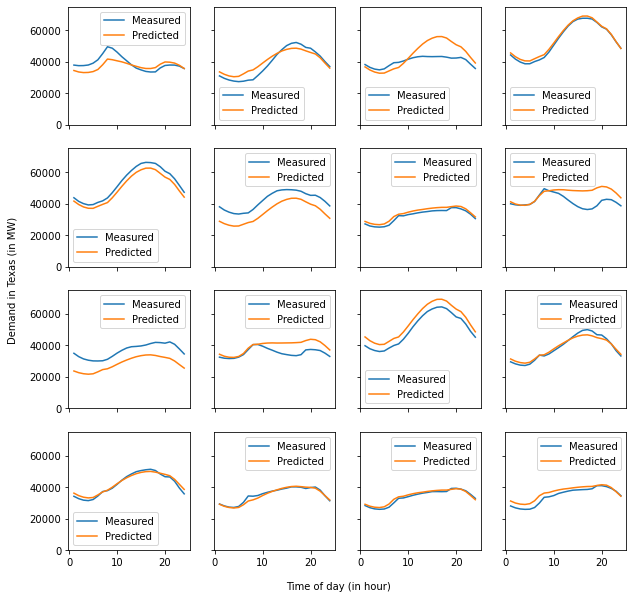

In [11]:
nHidden = 150

# Store the dimension of each row of 'X' in 'nDimX' and that of 'Y' in 'nDimY' .
nDimX = np.shape(trainX)[1]
nDimY = np.shape(trainY)[1]

# Construct the neural network using relu - https://keras.io/api/layers/activations/
inputs = keras.Input(shape=(72,), name="input")
nn_layer = keras.layers.Dense(nHidden, activation="relu", name="dense_1", use_bias=True, bias_initializer='zeros')(inputs)
nn_layer = keras.layers.Dense(nHidden, activation="relu", name="dense_2", use_bias=True, bias_initializer='zeros')(nn_layer)
outputs = keras.layers.Dense(24, name="output")(nn_layer)

model = keras.Model(inputs=inputs, outputs=outputs)

# Define the loss function (MSE) and the optimizer (AdagradOptimizer).

# insert code - define loss metric to minimize using the desired optimizer
model.compile(
    optimizer=tf.optimizers.Adagrad(learning_rate=0.01), # Optimizer - https://keras.io/api/optimizers/
    loss=keras.losses.MeanSquaredError() # Loss metric - https://keras.io/api/metrics/
)

batchSize = 75
nEpochs = 10000

# Train the model
print("Fit model on training data")

history = model.fit(
    trainX,
    trainY,
    batch_size=batchSize,
    epochs=nEpochs
)

# Output the accuracy of the regressor on the test data.
predictedY = model.predict(testX)

# Plot the predicted load and compare against the actual load from the test data.
assert(nTest >= 16)
days = random.sample(range(nTest), 16)

fig, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(10,10))
axs = axs.ravel()


for dd, day in enumerate(days):
    testYDay = testY[day]
    predictedYDay = predictedY[day]

    l1 = axs[dd].plot(range(1, 25), testYDay, label='Measured')
    l2 = axs[dd].plot(range(1, 25), predictedYDay, label='Predicted')
    
    axs[dd].set_ylim(bottom=0, top=75000)
    axs[dd].legend()

fig.text(0.5, 0.07, 'Time of day (in hour)', ha='center')
fig.text(0.04, 0.5, 'Demand in Texas (in MW)', va='center', rotation='vertical')

plt.show()

### The effect of wind energy (bonus).

In [12]:
#Let's check the raw data 
dfDemand = pd.read_csv("ERCOT_Hourly_Wind_Output_" + str(year) + ".csv")
dfDemand[:]

,time-date stamp,Date,"ERCOT Load, MW","Total Wind Output, MW","Total Wind Installed, MW","Wind Output, % of Load","Wind Output, % of Installed",1-hr MW change,1-hr % change
0,1/1/15 0:00,1-Jan,39932,871,12730,2.2,6.8,NaN,NaN
1,1/1/15 1:00,1-Jan,39134,724,12730,1.8,5.7,-147.0,-16.9
2,1/1/15 2:00,1-Jan,38560,596,12730,1.5,4.7,-127.0,-17.6
3,1/1/15 3:00,1-Jan,38334,486,12730,1.3,3.8,-110.0,-18.5
4,1/1/15 4:00,1-Jan,38392,651,12730,1.7,5.1,165.0,33.8
...,...,...,...,...,...,...,...,...,...
8755,12/31/15 19:00,31-Dec,39909,3825,16170,9.6,23.7,484.0,14.5
8756,12/31/15 20:00,31-Dec,38737,4626,16170,11.9,28.6,801.0,20.9
8757,12/31/15 21:00,31-Dec,37588,4958,16170,13.2,30.7,332.0,7.2
8758,12/31/15 22:00,31-Dec,36356,4699,16170,12.9,29.1,-259.0,-5.2


Note that in addition to the load data, we have some wind data! 

**Question (20 points).** Subtract the wind data from the load, and redo the above experiment and observe how does wind energy affect the forecasting process. How does the accuracy change? Why? Write down your MAE before and after considering wind energy. 

**After subtracting the wind energy, the accuracy of the model decreased. The accuracy decreased because wind can be very random. Some months there may be more wind energy produced and other months there may be less wind energy produced. The model has a harder time because we added another factor of randomness to consider. Before considering wind energy, the loss was almost 13 million. After taking wind energy into account, the loss was about 14 million.**

In [13]:
# Demand without the wind
no_wind = pd.DataFrame()
no_wind['New Load, MW'] = (dfDemand['ERCOT Load, MW'] - dfDemand['Total Wind Output, MW'])
no_wind

,"New Load, MW"
0,39061
1,38410
2,37964
3,37848
4,37741
...,...
8755,36084
8756,34111
8757,32630
8758,31657


In [14]:
# Acquire the data for training
daysToTrainOn = [-7, -2, -1]
rangeOfDays = range(-np.min(daysToTrainOn), numberOfDays)

X = [np.concatenate([no_wind.loc[(day + h) * 24: (day + h + 1) * 24 -1, 'New Load, MW'].values.flatten()
     for h in daysToTrainOn]) for day in rangeOfDays]
Y = [no_wind.loc[day * 24: (day + 1) * 24 - 1, 'New Load, MW'].values.flatten() for day in rangeOfDays]

# Split the data into train and test splits
X = preprocessing.StandardScaler().fit_transform(X)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2)

trainX = trainX.astype(np.float32)
testX = testX.astype(np.float32)
trainY = np.array(trainY)
testY = np.array(testY)

print("Scaled and split the data into two parts:")

nTrain = np.shape(trainX)[0]
nTest = np.shape(testX)[0]

print("Neural network will train on data from %d days, and test on %d days." % (nTrain, nTest))


Scaled and split the data into two parts:
Neural network will train on data from 286 days, and test on 72 days.


Fit model on training data
Train on 286 samples
Epoch 1/10000
286/286 [==============================] - 0s 2ms/sample - loss: 1328902634.9650
Epoch 2/10000
286/286 [==============================] - 0s 83us/sample - loss: 1325226850.9091
Epoch 3/10000
286/286 [==============================] - 0s 68us/sample - loss: 1315719488.4476
Epoch 4/10000
286/286 [==============================] - 0s 78us/sample - loss: 1300943710.8811
Epoch 5/10000
286/286 [==============================] - 0s 75us/sample - loss: 1281999078.0420
Epoch 6/10000
286/286 [==============================] - 0s 72us/sample - loss: 1259583316.5874
Epoch 7/10000
286/286 [==============================] - 0s 70us/sample - loss: 1234266539.4126
Epoch 8/10000
286/286 [==============================] - 0s 72us/sample - loss: 1206613363.0210
Epoch 9/10000
286/286 [==============================] - 0s 69us/sample - loss: 1177241022.6573
Epoch 10/10000
286/286 [==============================] - 0s 70us/sample - loss: 11462633

286/286 [==============================] - 0s 62us/sample - loss: 269120339.6923
Epoch 170/10000
286/286 [==============================] - 0s 62us/sample - loss: 268990217.1189
Epoch 171/10000
286/286 [==============================] - 0s 60us/sample - loss: 268833875.8601
Epoch 172/10000
286/286 [==============================] - 0s 61us/sample - loss: 268648984.7273
Epoch 173/10000
286/286 [==============================] - 0s 59us/sample - loss: 268559871.2727
Epoch 174/10000
286/286 [==============================] - 0s 56us/sample - loss: 268354330.0140
Epoch 175/10000
286/286 [==============================] - 0s 56us/sample - loss: 268232381.4825
Epoch 176/10000
286/286 [==============================] - 0s 63us/sample - loss: 268037601.2867
Epoch 177/10000
286/286 [==============================] - 0s 58us/sample - loss: 267855785.9580
Epoch 178/10000
286/286 [==============================] - 0s 59us/sample - loss: 267713560.6713
Epoch 179/10000
286/286 [=====================

286/286 [==============================] - 0s 56us/sample - loss: 248545222.8811
Epoch 338/10000
286/286 [==============================] - 0s 56us/sample - loss: 248370703.8322
Epoch 339/10000
286/286 [==============================] - 0s 57us/sample - loss: 248300504.2238
Epoch 340/10000
286/286 [==============================] - 0s 58us/sample - loss: 248192503.6084
Epoch 341/10000
286/286 [==============================] - 0s 57us/sample - loss: 248090612.0280
Epoch 342/10000
286/286 [==============================] - 0s 57us/sample - loss: 248018512.8951
Epoch 343/10000
286/286 [==============================] - 0s 61us/sample - loss: 247882448.7273
Epoch 344/10000
286/286 [==============================] - 0s 57us/sample - loss: 247794078.6014
Epoch 345/10000
286/286 [==============================] - 0s 61us/sample - loss: 247760217.5664
Epoch 346/10000
286/286 [==============================] - 0s 59us/sample - loss: 247597283.1329
Epoch 347/10000
286/286 [=====================

286/286 [==============================] - 0s 57us/sample - loss: 232203733.7622
Epoch 506/10000
286/286 [==============================] - 0s 60us/sample - loss: 232125907.4126
Epoch 507/10000
286/286 [==============================] - 0s 58us/sample - loss: 232004525.9301
Epoch 508/10000
286/286 [==============================] - 0s 56us/sample - loss: 231940076.3077
Epoch 509/10000
286/286 [==============================] - 0s 57us/sample - loss: 231799389.7622
Epoch 510/10000
286/286 [==============================] - 0s 57us/sample - loss: 231706313.6783
Epoch 511/10000
286/286 [==============================] - 0s 56us/sample - loss: 231601640.8951
Epoch 512/10000
286/286 [==============================] - 0s 56us/sample - loss: 231487671.8881
Epoch 513/10000
286/286 [==============================] - 0s 58us/sample - loss: 231402424.4476
Epoch 514/10000
286/286 [==============================] - 0s 55us/sample - loss: 231363343.8881
Epoch 515/10000
286/286 [=====================

286/286 [==============================] - 0s 58us/sample - loss: 215705963.7483
Epoch 674/10000
286/286 [==============================] - 0s 56us/sample - loss: 215633380.1958
Epoch 675/10000
286/286 [==============================] - 0s 57us/sample - loss: 215551201.8462
Epoch 676/10000
286/286 [==============================] - 0s 57us/sample - loss: 215412798.4895
Epoch 677/10000
286/286 [==============================] - 0s 57us/sample - loss: 215365432.3916
Epoch 678/10000
286/286 [==============================] - 0s 56us/sample - loss: 215233367.3846
Epoch 679/10000
286/286 [==============================] - 0s 57us/sample - loss: 215135174.6014
Epoch 680/10000
286/286 [==============================] - 0s 58us/sample - loss: 215077037.9860
Epoch 681/10000
286/286 [==============================] - 0s 56us/sample - loss: 214958939.6364
Epoch 682/10000
286/286 [==============================] - 0s 56us/sample - loss: 214854794.7972
Epoch 683/10000
286/286 [=====================

286/286 [==============================] - 0s 59us/sample - loss: 198574355.2448
Epoch 842/10000
286/286 [==============================] - 0s 58us/sample - loss: 198454022.3217
Epoch 843/10000
286/286 [==============================] - 0s 57us/sample - loss: 198359220.6993
Epoch 844/10000
286/286 [==============================] - 0s 57us/sample - loss: 198246058.4056
Epoch 845/10000
286/286 [==============================] - 0s 58us/sample - loss: 198118641.6224
Epoch 846/10000
286/286 [==============================] - 0s 58us/sample - loss: 197984445.6503
Epoch 847/10000
286/286 [==============================] - 0s 59us/sample - loss: 197897171.0210
Epoch 848/10000
286/286 [==============================] - 0s 56us/sample - loss: 197784963.3007
Epoch 849/10000
286/286 [==============================] - 0s 58us/sample - loss: 197742084.3636
Epoch 850/10000
286/286 [==============================] - 0s 58us/sample - loss: 197542937.0629
Epoch 851/10000
286/286 [=====================

286/286 [==============================] - 0s 58us/sample - loss: 177322372.2517
Epoch 1010/10000
286/286 [==============================] - 0s 57us/sample - loss: 177161727.9441
Epoch 1011/10000
286/286 [==============================] - 0s 55us/sample - loss: 177021898.4336
Epoch 1012/10000
286/286 [==============================] - 0s 56us/sample - loss: 176909519.0490
Epoch 1013/10000
286/286 [==============================] - 0s 58us/sample - loss: 176758965.3986
Epoch 1014/10000
286/286 [==============================] - 0s 58us/sample - loss: 176597906.0140
Epoch 1015/10000
286/286 [==============================] - 0s 56us/sample - loss: 176467183.5524
Epoch 1016/10000
286/286 [==============================] - 0s 84us/sample - loss: 176307589.0350
Epoch 1017/10000
286/286 [==============================] - 0s 56us/sample - loss: 176165719.6643
Epoch 1018/10000
286/286 [==============================] - 0s 56us/sample - loss: 176039506.6294
Epoch 1019/10000
286/286 [===========

286/286 [==============================] - 0s 58us/sample - loss: 152853116.3077
Epoch 1176/10000
286/286 [==============================] - 0s 58us/sample - loss: 152722749.4266
Epoch 1177/10000
286/286 [==============================] - 0s 57us/sample - loss: 152559531.7203
Epoch 1178/10000
286/286 [==============================] - 0s 60us/sample - loss: 152408874.7692
Epoch 1179/10000
286/286 [==============================] - 0s 62us/sample - loss: 152271538.9091
Epoch 1180/10000
286/286 [==============================] - 0s 58us/sample - loss: 152120878.9930
Epoch 1181/10000
286/286 [==============================] - 0s 58us/sample - loss: 151996713.3986
Epoch 1182/10000
286/286 [==============================] - 0s 56us/sample - loss: 151834384.2797
Epoch 1183/10000
286/286 [==============================] - 0s 56us/sample - loss: 151741560.5594
Epoch 1184/10000
286/286 [==============================] - 0s 56us/sample - loss: 151554312.2797
Epoch 1185/10000
286/286 [===========

286/286 [==============================] - 0s 59us/sample - loss: 129997465.2308
Epoch 1342/10000
286/286 [==============================] - 0s 58us/sample - loss: 129876145.9580
Epoch 1343/10000
286/286 [==============================] - 0s 56us/sample - loss: 129760373.8462
Epoch 1344/10000
286/286 [==============================] - 0s 56us/sample - loss: 129612317.8462
Epoch 1345/10000
286/286 [==============================] - 0s 55us/sample - loss: 129469623.1329
Epoch 1346/10000
286/286 [==============================] - 0s 60us/sample - loss: 129347131.1888
Epoch 1347/10000
286/286 [==============================] - 0s 57us/sample - loss: 129222071.6923
Epoch 1348/10000
286/286 [==============================] - 0s 56us/sample - loss: 129098530.5175
Epoch 1349/10000
286/286 [==============================] - 0s 56us/sample - loss: 128957962.8252
Epoch 1350/10000
286/286 [==============================] - 0s 57us/sample - loss: 128807345.8182
Epoch 1351/10000
286/286 [===========

286/286 [==============================] - 0s 59us/sample - loss: 110374759.4965
Epoch 1508/10000
286/286 [==============================] - 0s 57us/sample - loss: 110271472.6993
Epoch 1509/10000
286/286 [==============================] - 0s 59us/sample - loss: 110186568.0559
Epoch 1510/10000
286/286 [==============================] - 0s 59us/sample - loss: 110057362.6573
Epoch 1511/10000
286/286 [==============================] - 0s 59us/sample - loss: 109949971.3846
Epoch 1512/10000
286/286 [==============================] - 0s 62us/sample - loss: 109849399.1329
Epoch 1513/10000
286/286 [==============================] - 0s 58us/sample - loss: 109746813.0070
Epoch 1514/10000
286/286 [==============================] - 0s 61us/sample - loss: 109637244.0559
Epoch 1515/10000
286/286 [==============================] - 0s 61us/sample - loss: 109560075.6923
Epoch 1516/10000
286/286 [==============================] - 0s 61us/sample - loss: 109424014.7972
Epoch 1517/10000
286/286 [===========

286/286 [==============================] - 0s 54us/sample - loss: 95470679.7203
Epoch 1675/10000
286/286 [==============================] - 0s 60us/sample - loss: 95397126.6434
Epoch 1676/10000
286/286 [==============================] - 0s 57us/sample - loss: 95329128.7273
Epoch 1677/10000
286/286 [==============================] - 0s 57us/sample - loss: 95245563.7203
Epoch 1678/10000
286/286 [==============================] - 0s 57us/sample - loss: 95189212.3916
Epoch 1679/10000
286/286 [==============================] - 0s 59us/sample - loss: 95115630.5455
Epoch 1680/10000
286/286 [==============================] - 0s 57us/sample - loss: 95024465.0909
Epoch 1681/10000
286/286 [==============================] - 0s 56us/sample - loss: 94948064.6154
Epoch 1682/10000
286/286 [==============================] - 0s 61us/sample - loss: 94884386.3776
Epoch 1683/10000
286/286 [==============================] - 0s 57us/sample - loss: 94806852.3357
Epoch 1684/10000
286/286 [=====================

286/286 [==============================] - 0s 60us/sample - loss: 84420477.1748
Epoch 1843/10000
286/286 [==============================] - 0s 60us/sample - loss: 84368097.6503
Epoch 1844/10000
286/286 [==============================] - 0s 58us/sample - loss: 84313805.8462
Epoch 1845/10000
286/286 [==============================] - 0s 59us/sample - loss: 84240585.0629
Epoch 1846/10000
286/286 [==============================] - 0s 57us/sample - loss: 84223907.6364
Epoch 1847/10000
286/286 [==============================] - 0s 55us/sample - loss: 84130658.7972
Epoch 1848/10000
286/286 [==============================] - 0s 59us/sample - loss: 84069397.9580
Epoch 1849/10000
286/286 [==============================] - 0s 57us/sample - loss: 84059742.4895
Epoch 1850/10000
286/286 [==============================] - 0s 57us/sample - loss: 83951523.3846
Epoch 1851/10000
286/286 [==============================] - 0s 55us/sample - loss: 83899162.4895
Epoch 1852/10000
286/286 [=====================

286/286 [==============================] - 0s 57us/sample - loss: 75507879.1329
Epoch 2011/10000
286/286 [==============================] - 0s 56us/sample - loss: 75495123.9161
Epoch 2012/10000
286/286 [==============================] - 0s 56us/sample - loss: 75431994.7972
Epoch 2013/10000
286/286 [==============================] - 0s 55us/sample - loss: 75390676.3077
Epoch 2014/10000
286/286 [==============================] - 0s 57us/sample - loss: 75335137.8881
Epoch 2015/10000
286/286 [==============================] - 0s 54us/sample - loss: 75287277.5385
Epoch 2016/10000
286/286 [==============================] - 0s 59us/sample - loss: 75244653.2587
Epoch 2017/10000
286/286 [==============================] - 0s 57us/sample - loss: 75217328.9091
Epoch 2018/10000
286/286 [==============================] - 0s 57us/sample - loss: 75149000.6434
Epoch 2019/10000
286/286 [==============================] - 0s 58us/sample - loss: 75101198.7972
Epoch 2020/10000
286/286 [=====================

286/286 [==============================] - 0s 57us/sample - loss: 68328020.2378
Epoch 2179/10000
286/286 [==============================] - 0s 57us/sample - loss: 68279258.7972
Epoch 2180/10000
286/286 [==============================] - 0s 57us/sample - loss: 68234143.9441
Epoch 2181/10000
286/286 [==============================] - 0s 59us/sample - loss: 68209288.9510
Epoch 2182/10000
286/286 [==============================] - 0s 61us/sample - loss: 68152629.8182
Epoch 2183/10000
286/286 [==============================] - 0s 61us/sample - loss: 68117175.9580
Epoch 2184/10000
286/286 [==============================] - 0s 61us/sample - loss: 68091668.2937
Epoch 2185/10000
286/286 [==============================] - 0s 60us/sample - loss: 68062972.2657
Epoch 2186/10000
286/286 [==============================] - 0s 59us/sample - loss: 68009635.8601
Epoch 2187/10000
286/286 [==============================] - 0s 61us/sample - loss: 67981785.3287
Epoch 2188/10000
286/286 [=====================

286/286 [==============================] - 0s 62us/sample - loss: 62414480.5035
Epoch 2347/10000
286/286 [==============================] - 0s 61us/sample - loss: 62374031.4126
Epoch 2348/10000
286/286 [==============================] - 0s 59us/sample - loss: 62345599.1748
Epoch 2349/10000
286/286 [==============================] - 0s 56us/sample - loss: 62314421.3846
Epoch 2350/10000
286/286 [==============================] - 0s 57us/sample - loss: 62286010.0000
Epoch 2351/10000
286/286 [==============================] - 0s 56us/sample - loss: 62264875.2448
Epoch 2352/10000
286/286 [==============================] - 0s 56us/sample - loss: 62232418.9510
Epoch 2353/10000
286/286 [==============================] - 0s 60us/sample - loss: 62183549.5944
Epoch 2354/10000
286/286 [==============================] - 0s 57us/sample - loss: 62156283.1329
Epoch 2355/10000
286/286 [==============================] - 0s 56us/sample - loss: 62116761.0490
Epoch 2356/10000
286/286 [=====================

286/286 [==============================] - 0s 58us/sample - loss: 57735313.1189
Epoch 2515/10000
286/286 [==============================] - 0s 57us/sample - loss: 57713984.2937
Epoch 2516/10000
286/286 [==============================] - 0s 61us/sample - loss: 57676722.1818
Epoch 2517/10000
286/286 [==============================] - 0s 54us/sample - loss: 57656882.0140
Epoch 2518/10000
286/286 [==============================] - 0s 58us/sample - loss: 57636442.9231
Epoch 2519/10000
286/286 [==============================] - 0s 60us/sample - loss: 57609869.0909
Epoch 2520/10000
286/286 [==============================] - 0s 56us/sample - loss: 57583045.2867
Epoch 2521/10000
286/286 [==============================] - 0s 58us/sample - loss: 57558703.2308
Epoch 2522/10000
286/286 [==============================] - 0s 54us/sample - loss: 57533012.0000
Epoch 2523/10000
286/286 [==============================] - 0s 57us/sample - loss: 57540385.1469
Epoch 2524/10000
286/286 [=====================

286/286 [==============================] - 0s 60us/sample - loss: 54099355.1329
Epoch 2683/10000
286/286 [==============================] - 0s 58us/sample - loss: 54068048.2098
Epoch 2684/10000
286/286 [==============================] - 0s 55us/sample - loss: 54056521.1608
Epoch 2685/10000
286/286 [==============================] - 0s 56us/sample - loss: 54045585.7762
Epoch 2686/10000
286/286 [==============================] - 0s 59us/sample - loss: 54017202.6014
Epoch 2687/10000
286/286 [==============================] - 0s 60us/sample - loss: 54001565.0210
Epoch 2688/10000
286/286 [==============================] - 0s 58us/sample - loss: 53978818.4895
Epoch 2689/10000
286/286 [==============================] - 0s 55us/sample - loss: 53968077.7622
Epoch 2690/10000
286/286 [==============================] - 0s 56us/sample - loss: 53952409.1329
Epoch 2691/10000
286/286 [==============================] - 0s 57us/sample - loss: 53922119.8182
Epoch 2692/10000
286/286 [=====================

286/286 [==============================] - 0s 60us/sample - loss: 51102873.1469
Epoch 2851/10000
286/286 [==============================] - 0s 59us/sample - loss: 51075373.0350
Epoch 2852/10000
286/286 [==============================] - 0s 58us/sample - loss: 51084590.4615
Epoch 2853/10000
286/286 [==============================] - 0s 58us/sample - loss: 51040953.0629
Epoch 2854/10000
286/286 [==============================] - 0s 57us/sample - loss: 51025952.8531
Epoch 2855/10000
286/286 [==============================] - 0s 56us/sample - loss: 51016340.0420
Epoch 2856/10000
286/286 [==============================] - 0s 57us/sample - loss: 50989945.9441
Epoch 2857/10000
286/286 [==============================] - 0s 57us/sample - loss: 50971014.2098
Epoch 2858/10000
286/286 [==============================] - 0s 60us/sample - loss: 50969551.9580
Epoch 2859/10000
286/286 [==============================] - 0s 57us/sample - loss: 50934678.0000
Epoch 2860/10000
286/286 [=====================

286/286 [==============================] - 0s 58us/sample - loss: 48494590.6294
Epoch 3019/10000
286/286 [==============================] - 0s 58us/sample - loss: 48500601.5385
Epoch 3020/10000
286/286 [==============================] - 0s 57us/sample - loss: 48468534.8392
Epoch 3021/10000
286/286 [==============================] - 0s 60us/sample - loss: 48459587.8601
Epoch 3022/10000
286/286 [==============================] - 0s 55us/sample - loss: 48443848.3357
Epoch 3023/10000
286/286 [==============================] - 0s 60us/sample - loss: 48428624.5455
Epoch 3024/10000
286/286 [==============================] - 0s 60us/sample - loss: 48417063.7203
Epoch 3025/10000
286/286 [==============================] - 0s 55us/sample - loss: 48396544.9091
Epoch 3026/10000
286/286 [==============================] - 0s 57us/sample - loss: 48384841.2587
Epoch 3027/10000
286/286 [==============================] - 0s 54us/sample - loss: 48365306.0280
Epoch 3028/10000
286/286 [=====================

286/286 [==============================] - 0s 57us/sample - loss: 46186475.4406
Epoch 3187/10000
286/286 [==============================] - 0s 57us/sample - loss: 46173617.3846
Epoch 3188/10000
286/286 [==============================] - 0s 58us/sample - loss: 46157161.7762
Epoch 3189/10000
286/286 [==============================] - 0s 60us/sample - loss: 46146652.3776
Epoch 3190/10000
286/286 [==============================] - 0s 54us/sample - loss: 46140734.4895
Epoch 3191/10000
286/286 [==============================] - 0s 60us/sample - loss: 46116052.6993
Epoch 3192/10000
286/286 [==============================] - 0s 57us/sample - loss: 46109453.1329
Epoch 3193/10000
286/286 [==============================] - 0s 58us/sample - loss: 46099513.4685
Epoch 3194/10000
286/286 [==============================] - 0s 57us/sample - loss: 46076955.8462
Epoch 3195/10000
286/286 [==============================] - 0s 62us/sample - loss: 46067704.3497
Epoch 3196/10000
286/286 [=====================

286/286 [==============================] - 0s 59us/sample - loss: 44103085.3287
Epoch 3355/10000
286/286 [==============================] - 0s 58us/sample - loss: 44082362.0979
Epoch 3356/10000
286/286 [==============================] - 0s 59us/sample - loss: 44080906.2238
Epoch 3357/10000
286/286 [==============================] - 0s 59us/sample - loss: 44062155.1469
Epoch 3358/10000
286/286 [==============================] - 0s 58us/sample - loss: 44055849.7203
Epoch 3359/10000
286/286 [==============================] - 0s 59us/sample - loss: 44037068.2517
Epoch 3360/10000
286/286 [==============================] - 0s 59us/sample - loss: 44034077.1608
Epoch 3361/10000
286/286 [==============================] - 0s 59us/sample - loss: 44026062.5175
Epoch 3362/10000
286/286 [==============================] - 0s 63us/sample - loss: 44014420.8531
Epoch 3363/10000
286/286 [==============================] - 0s 62us/sample - loss: 43995539.4126
Epoch 3364/10000
286/286 [=====================

286/286 [==============================] - 0s 55us/sample - loss: 42223446.6294
Epoch 3523/10000
286/286 [==============================] - 0s 58us/sample - loss: 42198718.9510
Epoch 3524/10000
286/286 [==============================] - 0s 57us/sample - loss: 42177706.2098
Epoch 3525/10000
286/286 [==============================] - 0s 61us/sample - loss: 42170155.2587
Epoch 3526/10000
286/286 [==============================] - 0s 56us/sample - loss: 42157747.3846
Epoch 3527/10000
286/286 [==============================] - 0s 57us/sample - loss: 42156602.1538
Epoch 3528/10000
286/286 [==============================] - 0s 56us/sample - loss: 42142615.4545
Epoch 3529/10000
286/286 [==============================] - 0s 55us/sample - loss: 42125806.4196
Epoch 3530/10000
286/286 [==============================] - 0s 57us/sample - loss: 42130196.7552
Epoch 3531/10000
286/286 [==============================] - 0s 56us/sample - loss: 42104296.7622
Epoch 3532/10000
286/286 [=====================

286/286 [==============================] - 0s 55us/sample - loss: 40477015.6643
Epoch 3691/10000
286/286 [==============================] - 0s 59us/sample - loss: 40462611.9860
Epoch 3692/10000
286/286 [==============================] - 0s 58us/sample - loss: 40462510.7203
Epoch 3693/10000
286/286 [==============================] - 0s 58us/sample - loss: 40447504.1608
Epoch 3694/10000
286/286 [==============================] - 0s 63us/sample - loss: 40429533.3427
Epoch 3695/10000
286/286 [==============================] - 0s 63us/sample - loss: 40418292.7692
Epoch 3696/10000
286/286 [==============================] - 0s 65us/sample - loss: 40415611.6503
Epoch 3697/10000
286/286 [==============================] - 0s 62us/sample - loss: 40408804.5594
Epoch 3698/10000
286/286 [==============================] - 0s 63us/sample - loss: 40388501.6224
Epoch 3699/10000
286/286 [==============================] - 0s 66us/sample - loss: 40382359.2727
Epoch 3700/10000
286/286 [=====================

286/286 [==============================] - 0s 58us/sample - loss: 38864183.8392
Epoch 3859/10000
286/286 [==============================] - 0s 59us/sample - loss: 38842806.9371
Epoch 3860/10000
286/286 [==============================] - 0s 59us/sample - loss: 38849899.0699
Epoch 3861/10000
286/286 [==============================] - 0s 57us/sample - loss: 38827187.2867
Epoch 3862/10000
286/286 [==============================] - 0s 56us/sample - loss: 38822711.7063
Epoch 3863/10000
286/286 [==============================] - 0s 57us/sample - loss: 38807484.6573
Epoch 3864/10000
286/286 [==============================] - 0s 59us/sample - loss: 38818873.9371
Epoch 3865/10000
286/286 [==============================] - 0s 61us/sample - loss: 38801734.9371
Epoch 3866/10000
286/286 [==============================] - 0s 60us/sample - loss: 38789167.3566
Epoch 3867/10000
286/286 [==============================] - 0s 62us/sample - loss: 38770923.3986
Epoch 3868/10000
286/286 [=====================

286/286 [==============================] - 0s 58us/sample - loss: 37335263.9510
Epoch 4027/10000
286/286 [==============================] - 0s 57us/sample - loss: 37324888.3147
Epoch 4028/10000
286/286 [==============================] - 0s 57us/sample - loss: 37315424.5594
Epoch 4029/10000
286/286 [==============================] - 0s 59us/sample - loss: 37307463.3287
Epoch 4030/10000
286/286 [==============================] - 0s 57us/sample - loss: 37299942.3357
Epoch 4031/10000
286/286 [==============================] - 0s 57us/sample - loss: 37289592.1678
Epoch 4032/10000
286/286 [==============================] - 0s 57us/sample - loss: 37276495.6643
Epoch 4033/10000
286/286 [==============================] - 0s 60us/sample - loss: 37270033.7552
Epoch 4034/10000
286/286 [==============================] - 0s 59us/sample - loss: 37259271.1399
Epoch 4035/10000
286/286 [==============================] - 0s 57us/sample - loss: 37254538.1119
Epoch 4036/10000
286/286 [=====================

286/286 [==============================] - 0s 58us/sample - loss: 35892336.2657
Epoch 4195/10000
286/286 [==============================] - 0s 58us/sample - loss: 35888405.2308
Epoch 4196/10000
286/286 [==============================] - 0s 58us/sample - loss: 35880710.4336
Epoch 4197/10000
286/286 [==============================] - 0s 58us/sample - loss: 35881184.6923
Epoch 4198/10000
286/286 [==============================] - 0s 59us/sample - loss: 35863401.7762
Epoch 4199/10000
286/286 [==============================] - 0s 64us/sample - loss: 35861054.9650
Epoch 4200/10000
286/286 [==============================] - 0s 63us/sample - loss: 35845297.1748
Epoch 4201/10000
286/286 [==============================] - 0s 63us/sample - loss: 35836722.3916
Epoch 4202/10000
286/286 [==============================] - 0s 58us/sample - loss: 35826509.6084
Epoch 4203/10000
286/286 [==============================] - 0s 60us/sample - loss: 35818899.2168
Epoch 4204/10000
286/286 [=====================

286/286 [==============================] - 0s 66us/sample - loss: 34523223.1818
Epoch 4363/10000
286/286 [==============================] - 0s 65us/sample - loss: 34518996.8811
Epoch 4364/10000
286/286 [==============================] - 0s 58us/sample - loss: 34509570.0839
Epoch 4365/10000
286/286 [==============================] - 0s 67us/sample - loss: 34509612.4895
Epoch 4366/10000
286/286 [==============================] - 0s 61us/sample - loss: 34494731.5944
Epoch 4367/10000
286/286 [==============================] - 0s 64us/sample - loss: 34492221.9790
Epoch 4368/10000
286/286 [==============================] - 0s 69us/sample - loss: 34479822.7622
Epoch 4369/10000
286/286 [==============================] - 0s 64us/sample - loss: 34480647.4266
Epoch 4370/10000
286/286 [==============================] - 0s 66us/sample - loss: 34466064.5105
Epoch 4371/10000
286/286 [==============================] - 0s 63us/sample - loss: 34482121.8182
Epoch 4372/10000
286/286 [=====================

286/286 [==============================] - 0s 59us/sample - loss: 33226904.9930
Epoch 4531/10000
286/286 [==============================] - 0s 60us/sample - loss: 33216163.0909
Epoch 4532/10000
286/286 [==============================] - 0s 62us/sample - loss: 33214650.6923
Epoch 4533/10000
286/286 [==============================] - 0s 59us/sample - loss: 33201703.8741
Epoch 4534/10000
286/286 [==============================] - 0s 60us/sample - loss: 33201508.3706
Epoch 4535/10000
286/286 [==============================] - 0s 63us/sample - loss: 33188704.8112
Epoch 4536/10000
286/286 [==============================] - 0s 62us/sample - loss: 33203754.5455
Epoch 4537/10000
286/286 [==============================] - 0s 61us/sample - loss: 33166632.8811
Epoch 4538/10000
286/286 [==============================] - 0s 58us/sample - loss: 33167230.6154
Epoch 4539/10000
286/286 [==============================] - 0s 63us/sample - loss: 33156241.7832
Epoch 4540/10000
286/286 [=====================

286/286 [==============================] - 0s 56us/sample - loss: 32006924.3986
Epoch 4699/10000
286/286 [==============================] - 0s 60us/sample - loss: 32002460.6154
Epoch 4700/10000
286/286 [==============================] - 0s 55us/sample - loss: 31987570.7343
Epoch 4701/10000
286/286 [==============================] - 0s 58us/sample - loss: 31984125.1399
Epoch 4702/10000
286/286 [==============================] - 0s 57us/sample - loss: 31973207.6224
Epoch 4703/10000
286/286 [==============================] - 0s 60us/sample - loss: 31961013.5035
Epoch 4704/10000
286/286 [==============================] - 0s 56us/sample - loss: 31964241.9021
Epoch 4705/10000
286/286 [==============================] - 0s 56us/sample - loss: 31948302.4266
Epoch 4706/10000
286/286 [==============================] - 0s 60us/sample - loss: 31935908.2448
Epoch 4707/10000
286/286 [==============================] - 0s 60us/sample - loss: 31940922.3287
Epoch 4708/10000
286/286 [=====================

286/286 [==============================] - 0s 57us/sample - loss: 30817346.4755
Epoch 4867/10000
286/286 [==============================] - 0s 59us/sample - loss: 30808342.7413
Epoch 4868/10000
286/286 [==============================] - 0s 60us/sample - loss: 30815197.6294
Epoch 4869/10000
286/286 [==============================] - 0s 58us/sample - loss: 30798999.1119
Epoch 4870/10000
286/286 [==============================] - 0s 55us/sample - loss: 30793912.9371
Epoch 4871/10000
286/286 [==============================] - 0s 59us/sample - loss: 30785550.5245
Epoch 4872/10000
286/286 [==============================] - 0s 59us/sample - loss: 30776656.7832
Epoch 4873/10000
286/286 [==============================] - 0s 58us/sample - loss: 30765344.4056
Epoch 4874/10000
286/286 [==============================] - 0s 58us/sample - loss: 30764323.9231
Epoch 4875/10000
286/286 [==============================] - 0s 60us/sample - loss: 30755540.5804
Epoch 4876/10000
286/286 [=====================

286/286 [==============================] - 0s 60us/sample - loss: 29718847.4196
Epoch 5035/10000
286/286 [==============================] - 0s 58us/sample - loss: 29701466.8042
Epoch 5036/10000
286/286 [==============================] - 0s 57us/sample - loss: 29699118.5245
Epoch 5037/10000
286/286 [==============================] - 0s 57us/sample - loss: 29688324.2657
Epoch 5038/10000
286/286 [==============================] - 0s 56us/sample - loss: 29689799.2098
Epoch 5039/10000
286/286 [==============================] - 0s 55us/sample - loss: 29681554.1608
Epoch 5040/10000
286/286 [==============================] - 0s 60us/sample - loss: 29674869.7483
Epoch 5041/10000
286/286 [==============================] - 0s 62us/sample - loss: 29665603.9580
Epoch 5042/10000
286/286 [==============================] - 0s 60us/sample - loss: 29665506.8601
Epoch 5043/10000
286/286 [==============================] - 0s 60us/sample - loss: 29667212.6783
Epoch 5044/10000
286/286 [=====================

286/286 [==============================] - 0s 60us/sample - loss: 28686324.7692
Epoch 5203/10000
286/286 [==============================] - 0s 59us/sample - loss: 28689978.3427
Epoch 5204/10000
286/286 [==============================] - 0s 58us/sample - loss: 28673628.1678
Epoch 5205/10000
286/286 [==============================] - 0s 57us/sample - loss: 28680119.7762
Epoch 5206/10000
286/286 [==============================] - 0s 58us/sample - loss: 28665910.6643
Epoch 5207/10000
286/286 [==============================] - 0s 58us/sample - loss: 28674516.1329
Epoch 5208/10000
286/286 [==============================] - 0s 57us/sample - loss: 28648718.6853
Epoch 5209/10000
286/286 [==============================] - 0s 85us/sample - loss: 28642485.4895
Epoch 5210/10000
286/286 [==============================] - 0s 62us/sample - loss: 28639060.4965
Epoch 5211/10000
286/286 [==============================] - 0s 59us/sample - loss: 28641144.6923
Epoch 5212/10000
286/286 [=====================

286/286 [==============================] - 0s 64us/sample - loss: 27738143.6154
Epoch 5371/10000
286/286 [==============================] - 0s 57us/sample - loss: 27719796.1259
Epoch 5372/10000
286/286 [==============================] - 0s 61us/sample - loss: 27719077.6573
Epoch 5373/10000
286/286 [==============================] - 0s 60us/sample - loss: 27707139.7063
Epoch 5374/10000
286/286 [==============================] - 0s 60us/sample - loss: 27711792.6154
Epoch 5375/10000
286/286 [==============================] - 0s 62us/sample - loss: 27709287.7622
Epoch 5376/10000
286/286 [==============================] - 0s 63us/sample - loss: 27693748.2937
Epoch 5377/10000
286/286 [==============================] - 0s 61us/sample - loss: 27692701.9790
Epoch 5378/10000
286/286 [==============================] - 0s 63us/sample - loss: 27683776.1469
Epoch 5379/10000
286/286 [==============================] - 0s 64us/sample - loss: 27688071.1678
Epoch 5380/10000
286/286 [=====================

286/286 [==============================] - 0s 65us/sample - loss: 26800278.1748
Epoch 5539/10000
286/286 [==============================] - 0s 65us/sample - loss: 26787320.8182
Epoch 5540/10000
286/286 [==============================] - 0s 74us/sample - loss: 26792997.5245
Epoch 5541/10000
286/286 [==============================] - 0s 72us/sample - loss: 26779983.4965
Epoch 5542/10000
286/286 [==============================] - 0s 66us/sample - loss: 26781064.7902
Epoch 5543/10000
286/286 [==============================] - 0s 71us/sample - loss: 26771814.4615
Epoch 5544/10000
286/286 [==============================] - 0s 67us/sample - loss: 26774940.9021
Epoch 5545/10000
286/286 [==============================] - 0s 65us/sample - loss: 26759631.5455
Epoch 5546/10000
286/286 [==============================] - 0s 69us/sample - loss: 26756567.9580
Epoch 5547/10000
286/286 [==============================] - 0s 67us/sample - loss: 26756086.8182
Epoch 5548/10000
286/286 [=====================

286/286 [==============================] - 0s 82us/sample - loss: 25900351.4895
Epoch 5707/10000
286/286 [==============================] - 0s 67us/sample - loss: 25893314.1678
Epoch 5708/10000
286/286 [==============================] - 0s 79us/sample - loss: 25898018.3147
Epoch 5709/10000
286/286 [==============================] - 0s 83us/sample - loss: 25886027.7902
Epoch 5710/10000
286/286 [==============================] - 0s 74us/sample - loss: 25879055.2587
Epoch 5711/10000
286/286 [==============================] - 0s 73us/sample - loss: 25880737.6084
Epoch 5712/10000
286/286 [==============================] - 0s 72us/sample - loss: 25871122.8671
Epoch 5713/10000
286/286 [==============================] - 0s 68us/sample - loss: 25865167.8811
Epoch 5714/10000
286/286 [==============================] - 0s 68us/sample - loss: 25863130.5734
Epoch 5715/10000
286/286 [==============================] - 0s 73us/sample - loss: 25853924.1189
Epoch 5716/10000
286/286 [=====================

286/286 [==============================] - 0s 68us/sample - loss: 25056402.3636
Epoch 5875/10000
286/286 [==============================] - 0s 72us/sample - loss: 25049441.6923
Epoch 5876/10000
286/286 [==============================] - 0s 65us/sample - loss: 25046773.0769
Epoch 5877/10000
286/286 [==============================] - 0s 66us/sample - loss: 25037963.4266
Epoch 5878/10000
286/286 [==============================] - 0s 66us/sample - loss: 25037507.8042
Epoch 5879/10000
286/286 [==============================] - 0s 70us/sample - loss: 25034254.6014
Epoch 5880/10000
286/286 [==============================] - 0s 69us/sample - loss: 25040199.9580
Epoch 5881/10000
286/286 [==============================] - 0s 71us/sample - loss: 25021155.8951
Epoch 5882/10000
286/286 [==============================] - 0s 65us/sample - loss: 25013098.7622
Epoch 5883/10000
286/286 [==============================] - 0s 70us/sample - loss: 25027541.6993
Epoch 5884/10000
286/286 [=====================

286/286 [==============================] - 0s 65us/sample - loss: 24263110.4336
Epoch 6043/10000
286/286 [==============================] - 0s 64us/sample - loss: 24259312.2448
Epoch 6044/10000
286/286 [==============================] - 0s 68us/sample - loss: 24254651.5594
Epoch 6045/10000
286/286 [==============================] - 0s 66us/sample - loss: 24250144.0000
Epoch 6046/10000
286/286 [==============================] - 0s 60us/sample - loss: 24245066.5524
Epoch 6047/10000
286/286 [==============================] - 0s 64us/sample - loss: 24246218.4126
Epoch 6048/10000
286/286 [==============================] - 0s 62us/sample - loss: 24247111.6364
Epoch 6049/10000
286/286 [==============================] - 0s 59us/sample - loss: 24231044.1259
Epoch 6050/10000
286/286 [==============================] - 0s 62us/sample - loss: 24228705.4056
Epoch 6051/10000
286/286 [==============================] - 0s 92us/sample - loss: 24222926.7972
Epoch 6052/10000
286/286 [=====================

286/286 [==============================] - 0s 60us/sample - loss: 23488934.1259
Epoch 6211/10000
286/286 [==============================] - 0s 64us/sample - loss: 23473159.5594
Epoch 6212/10000
286/286 [==============================] - 0s 66us/sample - loss: 23467820.7483
Epoch 6213/10000
286/286 [==============================] - 0s 69us/sample - loss: 23464455.3776
Epoch 6214/10000
286/286 [==============================] - 0s 66us/sample - loss: 23462789.7343
Epoch 6215/10000
286/286 [==============================] - 0s 64us/sample - loss: 23464160.8042
Epoch 6216/10000
286/286 [==============================] - 0s 62us/sample - loss: 23458947.5524
Epoch 6217/10000
286/286 [==============================] - 0s 63us/sample - loss: 23453856.0140
Epoch 6218/10000
286/286 [==============================] - 0s 61us/sample - loss: 23446347.6573
Epoch 6219/10000
286/286 [==============================] - 0s 60us/sample - loss: 23447949.9930
Epoch 6220/10000
286/286 [=====================

286/286 [==============================] - 0s 60us/sample - loss: 22771470.1538
Epoch 6379/10000
286/286 [==============================] - 0s 59us/sample - loss: 22778086.1049
Epoch 6380/10000
286/286 [==============================] - 0s 60us/sample - loss: 22773020.4126
Epoch 6381/10000
286/286 [==============================] - 0s 61us/sample - loss: 22758041.4545
Epoch 6382/10000
286/286 [==============================] - 0s 63us/sample - loss: 22768610.9161
Epoch 6383/10000
286/286 [==============================] - 0s 61us/sample - loss: 22757393.4266
Epoch 6384/10000
286/286 [==============================] - 0s 66us/sample - loss: 22749731.4266
Epoch 6385/10000
286/286 [==============================] - 0s 62us/sample - loss: 22748447.5734
Epoch 6386/10000
286/286 [==============================] - 0s 64us/sample - loss: 22752263.4406
Epoch 6387/10000
286/286 [==============================] - 0s 64us/sample - loss: 22738799.5594
Epoch 6388/10000
286/286 [=====================

286/286 [==============================] - 0s 66us/sample - loss: 22112722.3077
Epoch 6547/10000
286/286 [==============================] - 0s 65us/sample - loss: 22111725.4266
Epoch 6548/10000
286/286 [==============================] - 0s 57us/sample - loss: 22106859.2098
Epoch 6549/10000
286/286 [==============================] - 0s 59us/sample - loss: 22098642.0280
Epoch 6550/10000
286/286 [==============================] - 0s 63us/sample - loss: 22091222.5664
Epoch 6551/10000
286/286 [==============================] - 0s 62us/sample - loss: 22088038.0280
Epoch 6552/10000
286/286 [==============================] - 0s 59us/sample - loss: 22088807.3147
Epoch 6553/10000
286/286 [==============================] - 0s 62us/sample - loss: 22089305.6084
Epoch 6554/10000
286/286 [==============================] - 0s 64us/sample - loss: 22079662.8112
Epoch 6555/10000
286/286 [==============================] - 0s 66us/sample - loss: 22073541.6853
Epoch 6556/10000
286/286 [=====================

286/286 [==============================] - 0s 63us/sample - loss: 21484044.0140
Epoch 6715/10000
286/286 [==============================] - 0s 59us/sample - loss: 21479908.5524
Epoch 6716/10000
286/286 [==============================] - 0s 59us/sample - loss: 21472757.0000
Epoch 6717/10000
286/286 [==============================] - 0s 59us/sample - loss: 21472100.3497
Epoch 6718/10000
286/286 [==============================] - 0s 60us/sample - loss: 21475186.7972
Epoch 6719/10000
286/286 [==============================] - 0s 60us/sample - loss: 21467845.4476
Epoch 6720/10000
286/286 [==============================] - 0s 61us/sample - loss: 21462141.0350
Epoch 6721/10000
286/286 [==============================] - 0s 58us/sample - loss: 21456806.0629
Epoch 6722/10000
286/286 [==============================] - 0s 60us/sample - loss: 21456243.9860
Epoch 6723/10000
286/286 [==============================] - 0s 60us/sample - loss: 21452045.1049
Epoch 6724/10000
286/286 [=====================

286/286 [==============================] - 0s 60us/sample - loss: 20888606.7972
Epoch 6883/10000
286/286 [==============================] - 0s 61us/sample - loss: 20879498.7203
Epoch 6884/10000
286/286 [==============================] - 0s 61us/sample - loss: 20885044.9720
Epoch 6885/10000
286/286 [==============================] - 0s 60us/sample - loss: 20876876.4545
Epoch 6886/10000
286/286 [==============================] - 0s 58us/sample - loss: 20876446.2448
Epoch 6887/10000
286/286 [==============================] - 0s 57us/sample - loss: 20871255.8986
Epoch 6888/10000
286/286 [==============================] - 0s 59us/sample - loss: 20865461.2238
Epoch 6889/10000
286/286 [==============================] - 0s 59us/sample - loss: 20863340.6573
Epoch 6890/10000
286/286 [==============================] - 0s 60us/sample - loss: 20867725.4615
Epoch 6891/10000
286/286 [==============================] - 0s 58us/sample - loss: 20855204.5594
Epoch 6892/10000
286/286 [=====================

286/286 [==============================] - 0s 64us/sample - loss: 20327986.8741
Epoch 7051/10000
286/286 [==============================] - 0s 65us/sample - loss: 20323466.5664
Epoch 7052/10000
286/286 [==============================] - 0s 63us/sample - loss: 20319233.3007
Epoch 7053/10000
286/286 [==============================] - 0s 64us/sample - loss: 20320654.7762
Epoch 7054/10000
286/286 [==============================] - 0s 65us/sample - loss: 20314246.0140
Epoch 7055/10000
286/286 [==============================] - 0s 64us/sample - loss: 20311271.6434
Epoch 7056/10000
286/286 [==============================] - 0s 60us/sample - loss: 20323774.5734
Epoch 7057/10000
286/286 [==============================] - 0s 65us/sample - loss: 20305705.6084
Epoch 7058/10000
286/286 [==============================] - 0s 66us/sample - loss: 20304801.7343
Epoch 7059/10000
286/286 [==============================] - 0s 59us/sample - loss: 20294998.9790
Epoch 7060/10000
286/286 [=====================

286/286 [==============================] - 0s 60us/sample - loss: 19805860.6014
Epoch 7219/10000
286/286 [==============================] - 0s 62us/sample - loss: 19803012.6783
Epoch 7220/10000
286/286 [==============================] - 0s 61us/sample - loss: 19795124.2797
Epoch 7221/10000
286/286 [==============================] - 0s 56us/sample - loss: 19795523.1189
Epoch 7222/10000
286/286 [==============================] - 0s 58us/sample - loss: 19802092.7622
Epoch 7223/10000
286/286 [==============================] - 0s 58us/sample - loss: 19783924.3217
Epoch 7224/10000
286/286 [==============================] - 0s 58us/sample - loss: 19788055.4825
Epoch 7225/10000
286/286 [==============================] - 0s 60us/sample - loss: 19785408.9510
Epoch 7226/10000
286/286 [==============================] - 0s 60us/sample - loss: 19784639.6084
Epoch 7227/10000
286/286 [==============================] - 0s 62us/sample - loss: 19773137.0979
Epoch 7228/10000
286/286 [=====================

286/286 [==============================] - 0s 69us/sample - loss: 19320302.3846
Epoch 7387/10000
286/286 [==============================] - 0s 67us/sample - loss: 19309639.4895
Epoch 7388/10000
286/286 [==============================] - 0s 75us/sample - loss: 19302780.3601
Epoch 7389/10000
286/286 [==============================] - 0s 69us/sample - loss: 19301068.5175
Epoch 7390/10000
286/286 [==============================] - 0s 67us/sample - loss: 19296474.4056
Epoch 7391/10000
286/286 [==============================] - 0s 67us/sample - loss: 19300693.4266
Epoch 7392/10000
286/286 [==============================] - 0s 70us/sample - loss: 19293131.7622
Epoch 7393/10000
286/286 [==============================] - 0s 78us/sample - loss: 19292039.9580
Epoch 7394/10000
286/286 [==============================] - 0s 71us/sample - loss: 19286973.8811
Epoch 7395/10000
286/286 [==============================] - 0s 70us/sample - loss: 19289014.1399
Epoch 7396/10000
286/286 [=====================

286/286 [==============================] - 0s 61us/sample - loss: 18848264.3916
Epoch 7555/10000
286/286 [==============================] - 0s 61us/sample - loss: 18844871.5385
Epoch 7556/10000
286/286 [==============================] - 0s 61us/sample - loss: 18842720.9161
Epoch 7557/10000
286/286 [==============================] - 0s 61us/sample - loss: 18837790.9091
Epoch 7558/10000
286/286 [==============================] - 0s 63us/sample - loss: 18838498.2413
Epoch 7559/10000
286/286 [==============================] - 0s 63us/sample - loss: 18834608.4860
Epoch 7560/10000
286/286 [==============================] - 0s 61us/sample - loss: 18834206.0070
Epoch 7561/10000
286/286 [==============================] - 0s 64us/sample - loss: 18830614.6643
Epoch 7562/10000
286/286 [==============================] - 0s 59us/sample - loss: 18823288.2308
Epoch 7563/10000
286/286 [==============================] - 0s 64us/sample - loss: 18832669.7902
Epoch 7564/10000
286/286 [=====================

286/286 [==============================] - 0s 66us/sample - loss: 18406205.4056
Epoch 7723/10000
286/286 [==============================] - 0s 65us/sample - loss: 18403762.4266
Epoch 7724/10000
286/286 [==============================] - 0s 63us/sample - loss: 18403342.7133
Epoch 7725/10000
286/286 [==============================] - 0s 61us/sample - loss: 18400482.3916
Epoch 7726/10000
286/286 [==============================] - 0s 58us/sample - loss: 18404735.5105
Epoch 7727/10000
286/286 [==============================] - 0s 64us/sample - loss: 18391984.7308
Epoch 7728/10000
286/286 [==============================] - 0s 67us/sample - loss: 18390162.4476
Epoch 7729/10000
286/286 [==============================] - 0s 64us/sample - loss: 18387356.2343
Epoch 7730/10000
286/286 [==============================] - 0s 59us/sample - loss: 18389004.1119
Epoch 7731/10000
286/286 [==============================] - 0s 57us/sample - loss: 18382736.6259
Epoch 7732/10000
286/286 [=====================

286/286 [==============================] - 0s 59us/sample - loss: 17987803.4615
Epoch 7891/10000
286/286 [==============================] - 0s 60us/sample - loss: 17982218.4196
Epoch 7892/10000
286/286 [==============================] - 0s 59us/sample - loss: 17976345.1748
Epoch 7893/10000
286/286 [==============================] - 0s 57us/sample - loss: 17991424.6783
Epoch 7894/10000
286/286 [==============================] - 0s 58us/sample - loss: 17978985.0350
Epoch 7895/10000
286/286 [==============================] - 0s 62us/sample - loss: 17971640.4545
Epoch 7896/10000
286/286 [==============================] - 0s 61us/sample - loss: 17971327.5035
Epoch 7897/10000
286/286 [==============================] - 0s 61us/sample - loss: 17975300.8182
Epoch 7898/10000
286/286 [==============================] - 0s 63us/sample - loss: 17962130.9266
Epoch 7899/10000
286/286 [==============================] - 0s 62us/sample - loss: 17964290.5524
Epoch 7900/10000
286/286 [=====================

286/286 [==============================] - 0s 63us/sample - loss: 17582507.4580
Epoch 8059/10000
286/286 [==============================] - 0s 70us/sample - loss: 17584166.7517
Epoch 8060/10000
286/286 [==============================] - 0s 68us/sample - loss: 17577958.8147
Epoch 8061/10000
286/286 [==============================] - 0s 70us/sample - loss: 17574685.9301
Epoch 8062/10000
286/286 [==============================] - 0s 69us/sample - loss: 17569335.1259
Epoch 8063/10000
286/286 [==============================] - 0s 66us/sample - loss: 17567887.0734
Epoch 8064/10000
286/286 [==============================] - 0s 69us/sample - loss: 17572758.1469
Epoch 8065/10000
286/286 [==============================] - 0s 73us/sample - loss: 17566521.0105
Epoch 8066/10000
286/286 [==============================] - 0s 76us/sample - loss: 17560404.0245
Epoch 8067/10000
286/286 [==============================] - 0s 72us/sample - loss: 17566278.3287
Epoch 8068/10000
286/286 [=====================

286/286 [==============================] - 0s 77us/sample - loss: 17196853.7343
Epoch 8227/10000
286/286 [==============================] - 0s 75us/sample - loss: 17191134.0979
Epoch 8228/10000
286/286 [==============================] - 0s 80us/sample - loss: 17190813.6154
Epoch 8229/10000
286/286 [==============================] - 0s 89us/sample - loss: 17192255.2168
Epoch 8230/10000
286/286 [==============================] - 0s 79us/sample - loss: 17185385.5874
Epoch 8231/10000
286/286 [==============================] - 0s 79us/sample - loss: 17183392.3671
Epoch 8232/10000
286/286 [==============================] - 0s 70us/sample - loss: 17180309.8741
Epoch 8233/10000
286/286 [==============================] - 0s 70us/sample - loss: 17188635.2203
Epoch 8234/10000
286/286 [==============================] - 0s 82us/sample - loss: 17184191.0385
Epoch 8235/10000
286/286 [==============================] - 0s 82us/sample - loss: 17175289.3531
Epoch 8236/10000
286/286 [=====================

286/286 [==============================] - 0s 74us/sample - loss: 16820244.6888
Epoch 8395/10000
286/286 [==============================] - 0s 70us/sample - loss: 16827605.0979
Epoch 8396/10000
286/286 [==============================] - 0s 64us/sample - loss: 16835816.1119
Epoch 8397/10000
286/286 [==============================] - 0s 63us/sample - loss: 16819380.9790
Epoch 8398/10000
286/286 [==============================] - 0s 64us/sample - loss: 16818524.0559
Epoch 8399/10000
286/286 [==============================] - 0s 68us/sample - loss: 16808474.0175
Epoch 8400/10000
286/286 [==============================] - 0s 67us/sample - loss: 16812243.6818
Epoch 8401/10000
286/286 [==============================] - 0s 66us/sample - loss: 16808019.1259
Epoch 8402/10000
286/286 [==============================] - 0s 69us/sample - loss: 16804432.4790
Epoch 8403/10000
286/286 [==============================] - 0s 70us/sample - loss: 16801280.7413
Epoch 8404/10000
286/286 [=====================

286/286 [==============================] - 0s 66us/sample - loss: 16454859.2028
Epoch 8563/10000
286/286 [==============================] - 0s 68us/sample - loss: 16451581.8811
Epoch 8564/10000
286/286 [==============================] - 0s 66us/sample - loss: 16448966.4231
Epoch 8565/10000
286/286 [==============================] - 0s 61us/sample - loss: 16449506.9301
Epoch 8566/10000
286/286 [==============================] - 0s 63us/sample - loss: 16452408.3462
Epoch 8567/10000
286/286 [==============================] - 0s 64us/sample - loss: 16446456.1084
Epoch 8568/10000
286/286 [==============================] - 0s 62us/sample - loss: 16442898.2972
Epoch 8569/10000
286/286 [==============================] - 0s 62us/sample - loss: 16440748.8846
Epoch 8570/10000
286/286 [==============================] - 0s 67us/sample - loss: 16437304.3182
Epoch 8571/10000
286/286 [==============================] - 0s 63us/sample - loss: 16435537.0350
Epoch 8572/10000
286/286 [=====================

286/286 [==============================] - 0s 67us/sample - loss: 16095432.8287
Epoch 8731/10000
286/286 [==============================] - 0s 68us/sample - loss: 16102511.0420
Epoch 8732/10000
286/286 [==============================] - 0s 67us/sample - loss: 16094498.2483
Epoch 8733/10000
286/286 [==============================] - 0s 63us/sample - loss: 16093624.0769
Epoch 8734/10000
286/286 [==============================] - 0s 63us/sample - loss: 16088343.1713
Epoch 8735/10000
286/286 [==============================] - 0s 66us/sample - loss: 16096358.8671
Epoch 8736/10000
286/286 [==============================] - 0s 68us/sample - loss: 16084978.7692
Epoch 8737/10000
286/286 [==============================] - 0s 67us/sample - loss: 16081111.0490
Epoch 8738/10000
286/286 [==============================] - 0s 67us/sample - loss: 16081436.6888
Epoch 8739/10000
286/286 [==============================] - 0s 73us/sample - loss: 16079703.0629
Epoch 8740/10000
286/286 [=====================

286/286 [==============================] - 0s 65us/sample - loss: 15765749.7063
Epoch 8899/10000
286/286 [==============================] - 0s 66us/sample - loss: 15767275.8287
Epoch 8900/10000
286/286 [==============================] - 0s 70us/sample - loss: 15760144.3147
Epoch 8901/10000
286/286 [==============================] - 0s 67us/sample - loss: 15757965.0839
Epoch 8902/10000
286/286 [==============================] - 0s 67us/sample - loss: 15763021.8601
Epoch 8903/10000
286/286 [==============================] - 0s 67us/sample - loss: 15754973.8741
Epoch 8904/10000
286/286 [==============================] - 0s 68us/sample - loss: 15758270.6713
Epoch 8905/10000
286/286 [==============================] - 0s 69us/sample - loss: 15756150.2692
Epoch 8906/10000
286/286 [==============================] - 0s 71us/sample - loss: 15755892.1923
Epoch 8907/10000
286/286 [==============================] - 0s 65us/sample - loss: 15750639.4441
Epoch 8908/10000
286/286 [=====================

286/286 [==============================] - 0s 70us/sample - loss: 15461600.5070
Epoch 9067/10000
286/286 [==============================] - 0s 70us/sample - loss: 15454601.4720
Epoch 9068/10000
286/286 [==============================] - 0s 68us/sample - loss: 15451195.2238
Epoch 9069/10000
286/286 [==============================] - 0s 62us/sample - loss: 15457666.9406
Epoch 9070/10000
286/286 [==============================] - 0s 75us/sample - loss: 15453618.9161
Epoch 9071/10000
286/286 [==============================] - 0s 64us/sample - loss: 15453303.0944
Epoch 9072/10000
286/286 [==============================] - 0s 62us/sample - loss: 15446790.5979
Epoch 9073/10000
286/286 [==============================] - 0s 61us/sample - loss: 15448369.4895
Epoch 9074/10000
286/286 [==============================] - 0s 63us/sample - loss: 15444168.3042
Epoch 9075/10000
286/286 [==============================] - 0s 64us/sample - loss: 15436513.9930
Epoch 9076/10000
286/286 [=====================

286/286 [==============================] - 0s 63us/sample - loss: 15161447.2937
Epoch 9235/10000
286/286 [==============================] - 0s 62us/sample - loss: 15156684.6364
Epoch 9236/10000
286/286 [==============================] - 0s 64us/sample - loss: 15149287.4895
Epoch 9237/10000
286/286 [==============================] - 0s 61us/sample - loss: 15151103.3951
Epoch 9238/10000
286/286 [==============================] - 0s 62us/sample - loss: 15147176.3811
Epoch 9239/10000
286/286 [==============================] - 0s 87us/sample - loss: 15149210.5245
Epoch 9240/10000
286/286 [==============================] - 0s 62us/sample - loss: 15145927.4336
Epoch 9241/10000
286/286 [==============================] - 0s 60us/sample - loss: 15143569.5874
Epoch 9242/10000
286/286 [==============================] - 0s 64us/sample - loss: 15152381.7832
Epoch 9243/10000
286/286 [==============================] - 0s 62us/sample - loss: 15143916.3322
Epoch 9244/10000
286/286 [=====================

286/286 [==============================] - 0s 64us/sample - loss: 14878933.1469
Epoch 9403/10000
286/286 [==============================] - 0s 62us/sample - loss: 14876063.9231
Epoch 9404/10000
286/286 [==============================] - 0s 61us/sample - loss: 14868344.4755
Epoch 9405/10000
286/286 [==============================] - 0s 71us/sample - loss: 14869212.6259
Epoch 9406/10000
286/286 [==============================] - 0s 72us/sample - loss: 14863201.1643
Epoch 9407/10000
286/286 [==============================] - 0s 69us/sample - loss: 14863963.4231
Epoch 9408/10000
286/286 [==============================] - 0s 70us/sample - loss: 14860337.6049
Epoch 9409/10000
286/286 [==============================] - 0s 72us/sample - loss: 14861246.2727
Epoch 9410/10000
286/286 [==============================] - 0s 72us/sample - loss: 14857530.8741
Epoch 9411/10000
286/286 [==============================] - 0s 70us/sample - loss: 14855682.3531
Epoch 9412/10000
286/286 [=====================

286/286 [==============================] - 0s 64us/sample - loss: 14600927.1224
Epoch 9571/10000
286/286 [==============================] - 0s 66us/sample - loss: 14599762.1923
Epoch 9572/10000
286/286 [==============================] - 0s 68us/sample - loss: 14595989.4615
Epoch 9573/10000
286/286 [==============================] - 0s 63us/sample - loss: 14598335.6923
Epoch 9574/10000
286/286 [==============================] - 0s 65us/sample - loss: 14601910.1154
Epoch 9575/10000
286/286 [==============================] - 0s 64us/sample - loss: 14590635.0280
Epoch 9576/10000
286/286 [==============================] - 0s 64us/sample - loss: 14594017.1084
Epoch 9577/10000
286/286 [==============================] - 0s 61us/sample - loss: 14598706.6923
Epoch 9578/10000
286/286 [==============================] - 0s 62us/sample - loss: 14590160.7098
Epoch 9579/10000
286/286 [==============================] - 0s 60us/sample - loss: 14591301.1154
Epoch 9580/10000
286/286 [=====================

286/286 [==============================] - 0s 69us/sample - loss: 14342991.1993
Epoch 9739/10000
286/286 [==============================] - 0s 66us/sample - loss: 14343886.3287
Epoch 9740/10000
286/286 [==============================] - 0s 64us/sample - loss: 14339801.3566
Epoch 9741/10000
286/286 [==============================] - 0s 59us/sample - loss: 14338354.9266
Epoch 9742/10000
286/286 [==============================] - 0s 61us/sample - loss: 14338451.6643
Epoch 9743/10000
286/286 [==============================] - 0s 61us/sample - loss: 14332697.6958
Epoch 9744/10000
286/286 [==============================] - 0s 61us/sample - loss: 14331416.3531
Epoch 9745/10000
286/286 [==============================] - 0s 62us/sample - loss: 14333219.4301
Epoch 9746/10000
286/286 [==============================] - 0s 66us/sample - loss: 14328677.8462
Epoch 9747/10000
286/286 [==============================] - 0s 64us/sample - loss: 14327819.3601
Epoch 9748/10000
286/286 [=====================

286/286 [==============================] - 0s 65us/sample - loss: 14093798.6678
Epoch 9907/10000
286/286 [==============================] - 0s 65us/sample - loss: 14093202.4406
Epoch 9908/10000
286/286 [==============================] - 0s 68us/sample - loss: 14090852.9720
Epoch 9909/10000
286/286 [==============================] - 0s 59us/sample - loss: 14095574.3217
Epoch 9910/10000
286/286 [==============================] - 0s 61us/sample - loss: 14090354.6573
Epoch 9911/10000
286/286 [==============================] - 0s 64us/sample - loss: 14091378.6503
Epoch 9912/10000
286/286 [==============================] - 0s 59us/sample - loss: 14085043.2308
Epoch 9913/10000
286/286 [==============================] - 0s 59us/sample - loss: 14094336.3497
Epoch 9914/10000
286/286 [==============================] - 0s 61us/sample - loss: 14086108.8147
Epoch 9915/10000
286/286 [==============================] - 0s 62us/sample - loss: 14085478.2413
Epoch 9916/10000
286/286 [=====================

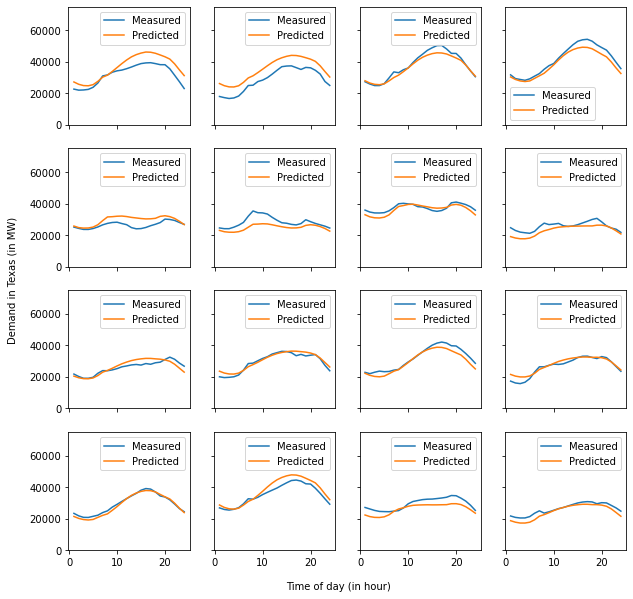

In [15]:
# Create Neural Network
nHidden = 150

# Store the dimension of each row of 'X' in 'nDimX' and that of 'Y' in 'nDimY' .
nDimX = np.shape(trainX)[1]
nDimY = np.shape(trainY)[1]

# Construct the neural network using relu - https://keras.io/api/layers/activations/
inputs = keras.Input(shape=(72,), name="input")
nn_layer = keras.layers.Dense(nHidden, activation="relu", name="dense_1", use_bias=True, bias_initializer='zeros')(inputs)
nn_layer = keras.layers.Dense(nHidden, activation="relu", name="dense_2", use_bias=True, bias_initializer='zeros')(nn_layer)
outputs = keras.layers.Dense(24, name="output")(nn_layer)

model = keras.Model(inputs=inputs, outputs=outputs)

# Define the loss function (MSE) and the optimizer (AdagradOptimizer).

# insert code - define loss metric to minimize using the desired optimizer
model.compile(
    optimizer=tf.optimizers.Adagrad(learning_rate=0.01), # Optimizer - https://keras.io/api/optimizers/
    loss=keras.losses.MeanSquaredError() # Loss metric - https://keras.io/api/metrics/
)

batchSize = 75
nEpochs = 10000

# Train the model
print("Fit model on training data")

history = model.fit(
    trainX,
    trainY,
    batch_size=batchSize,
    epochs=nEpochs
)

# Output the accuracy of the regressor on the test data.
predictedY = model.predict(testX)

# Plot the predicted load and compare against the actual load from the test data.
assert(nTest >= 16)
days = random.sample(range(nTest), 16)

fig, axs = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(10,10))
axs = axs.ravel()


for dd, day in enumerate(days):
    testYDay = testY[day]
    predictedYDay = predictedY[day]

    l1 = axs[dd].plot(range(1, 25), testYDay, label='Measured')
    l2 = axs[dd].plot(range(1, 25), predictedYDay, label='Predicted')
    
    axs[dd].set_ylim(bottom=0, top=75000)
    axs[dd].legend()

fig.text(0.5, 0.07, 'Time of day (in hour)', ha='center')
fig.text(0.04, 0.5, 'Demand in Texas (in MW)', va='center', rotation='vertical')

plt.show()